Davi Lage Borges Souza  2018054400 \
Fernando Vilela Brandão 2021421907

Perguntas: \
Qual a cultura mais rentável? \
Continentes mais eficientes em produtividade \
Qual continente é o maior produtor de cada produto \
Qual a produção esperada para cada continente? \
Qual o rendimento total esperado para o Brasil?

Sources: \
 Área, Produção por país : https://www.fao.org/faostat/en/#data/QCL

Preços:

Milho:https://www.macrotrends.net/2532/corn-prices-historical-chart-data

Soja: https://www.macrotrends.net/2531/soybean-prices-historical-chart-data

Trigo: https://www.macrotrends.net/2534/wheat-prices-historical-chart-data

Cafe: https://www.macrotrends.net/2535/coffee-prices-historical-chart-data

Indice de deflação: https://fred.stlouisfed.org/series/CPIAUCSL


Link YouTube: https://youtu.be/DY0vSMQP1gQ

## Motivação

A população mundial está em constante crescimento e com isso a produção de alimentos também tem de crescer. E como crescer? Simplesmente aumentar a área plantada ou também é necessário estratégias para aumentar a produtividade? Além disso as pessoas terão acesso aos alimentos devido aos preços e será rentável produzir grãos a base da alimentação mundial (utilizada diretamente para a alimentação humana ou então para produção de ração animal). \
Com isso analisamos o dataset da FAO (food and agriculture organization) com a produção de  milho, soja, trigo e café,por país por ano de 1961 a 2020, para a análise de preços foi utilizado o valor da cotação diária no mercado internacional de commodities da macrotrends deflacionados para dezembro de 2021 utilizando o CPI (Consumer Price Index da Federal Reserve Economic Data) 
- Analise exploratória (Brasil)

1) Concluir que conforme analisado para o Brasil vemos uma tendencia de crescimento de produção absoluta.

2) É possível extrapolar esse crescimento na produção para os outros grandes produtores?

3) Esse crescimento decorre da expansão da fronteira agrícola ou do aumento de eficiência de produção?

4) Esse crescimento de produção se reverteu em um custo mais baixo para o consumidor e para o produtor?

## Metodologia

Foram utilizadas tres bases de dados: 
* FAO
* macrotrends
* Federal Reserve Economic Data







1. Seleção dos produtos a serem analisados (Soja, Café, Milho e Tigo)
2. Escopo da analise (1961-2021)
3. Tópicos analisados:produção, valor do produto, área


* Bootstrap para intervalo de confiança para produção total de cada continente
* Verificar as diferenças de produção entre os continentes
* Calcular eficiencia para cada país -> continente
* Regressão para encontrar previsão de preço de mercado
* Regressão para encontrar expectativa de produção

#### Federal Reserve Economic Data

Da base da Federal Reserve Economic Data foi extraída 1 tabela contendo a série histórica do indice de inflação

  DATE: string - Data referente

  CPIAUCSL: float64 - Preço do produto

#### FAO


Da base da FAO foram extraídas 1 tabela contendo os dados dos 4 produtos (soja, trigo, milho e café) e dos 6 continentes (américa do sul, américa do norte, oceania, europa, asia, africa) analisados.

  Domain Code: string - Código do domínio dos dados 

  Domain: string -Domínio dos dados

  Area Code (FAO): int- Identificador do país  

  Area: string - Nome do país

  Element Code: int64 - Identificador de qual informação se trata(area ou produção)  

  Element: string - Qual informação se trata(area ou produção)

  Item Code (FAO): int64  - Identificador do produto

  Item: string  - Nome do produto

  Year Code: int64 - Identificador do ano

  Year: int64 - Ano

  Unit: string -Unidade de medida

  Value: float64 - Quantidade (area plantada e produção)

  Flag: string - Flag das fontes

  Flag Description: string - Fonte dos dados

#### Macrotrends

Da base da macrotrends foram extraídas 4 tabelas cada uma contendo a série histórica do preço de um produto analisado (soja, trigo, milho e café).

  date: string - Data referente

   value: float64 - Preço do produto

### Imports e funções auxiliares

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from sklearn.linear_model import LinearRegression

In [ ]:
def plot_mundo(prod_anual, area_anual, produto):
  fig, axs = plt.subplots(nrows=2, figsize=(22, 12))
  plt.tight_layout()

  axs[0].plot(prod_anual["Year"], prod_anual["Value"], label=f"{produto}", 
          linewidth=3)
  axs[0].set_title(f"Série Temporal Produção {produto}")
  axs[0].set_ylabel("Produção em 10 milhões de toneladas")
  axs[0].legend()

  axs[1].plot(area_anual["Year"], area_anual["Value"], label=f"{produto}", 
          linewidth=3)
  axs[1].set_title(f"Série Temporal Área {produto}")
  axs[1].set_ylabel("Area em milhoes hectares")
  axs[1].legend()

  plt.show()

In [ ]:
def fix_prod(df):
  df_copy = df.copy()
  df_copy = df_copy.transpose().reset_index()
  df_copy.rename(columns={'index': 'Data'}, inplace=True)
  # df_copy.loc[-1][0] = '2022'
  return df_copy

In [ ]:
# Executa bootstrap sobre um dataset na coluna predefinida
# utilizando n_sub de sub-amostras
def bootstrap(data, col, n_sub, size, t):
  values = []
  data_copy = data.copy()
  # random_seed fixa garante replicabilidade do experimento
  random.seed(16769023)
  for i in range(n_sub):
    # replace = TRUE garanta amostras com reposição
    sample = data_copy.sample(size, replace=True, random_state=random.randint(0, i)%23456) 
    
    # Lembre que podemos utilizar mediana, média ou qualquer outra estatística agregada
    if t == 'mean':
      values.append(sample[col].mean())
    elif t == 'median' or t == 50:
      values.append(sample[col].median())
    else:
      values.append(sample[col].quantile(t))
  
  # Gerando valores inferior e superior para um nível de confiança de 95%
  LI = np.percentile(values, 2.5)
  LS = np.percentile(values, 97.5)
  return (values, LI, LS)

In [ ]:
def get_continentes(df):
  df_asia = df[df['Area'].isin(asia)]
  df_africa = df[df['Area'].isin(africa)]
  df_europa = df[df['Area'].isin(europa)]
  df_oceania = df[df['Area'].isin(oceania)]
  df_america_norte= df[df['Area'].isin(america_norte)]
  df_america_sul= df[df['Area'].isin(america_sul)]
  return {"asia": df_asia, 
          "africa": df_africa, 
          "europa": df_europa, 
          "oceania": df_oceania, 
          "america_n": df_america_norte, 
          "america_s": df_america_sul}

In [ ]:
def getRank(means, li_90, ls_10):
  top10 = []
  bot10 = []
  for country in means:
    if means[country] >= li_90:
      top10.append((country, means[country]))
    elif means[country] <= ls_10:
      bot10.append((country, means[country]))

  top10.sort(key=lambda tup: tup[1], reverse=True)
  bot10.sort(key=lambda tup: tup[1], reverse=True)
  print("Top 10%")
  for i in top10:
    print(i)
  print("Bottom 10%")
  for i in bot10:
    print(i)

In [ ]:
def get_status_continente(data, continente, produto, sum=True):
  values_a, li_median, ls_median = bootstrap(data, 'Value', 10000, len(data), 'median')
  values_a_90, li_90, ls_90 = bootstrap(data, 'Value', 10000, len(data), 0.9)
  values_a_10, li_10, ls_10 = bootstrap(data, 'Value', 10000, len(data), 0.1)
  if sum:
    sum_data = data.groupby('Year').sum()
    values_a_sum, li_sum, ls_sum = bootstrap(sum_data, 'Value', 10000, len(data), 'median')
  # Gera IC para cada pais e um estimador
  means = {}
  for country in data['Area'].unique():
    values, li, ls = bootstrap(data[data['Area'] == country], 'Value', len(data), len(data), 'median')
    means[country] = pd.Series(values).mean()
  getRank(means, li_90, ls_10)
  #Serie temporal variacao da produção
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  plt.tight_layout(w_pad=2)


  axs[0].boxplot(values_a)
  axs[1].boxplot(values_a_90)
  axs[2].boxplot(values_a_10)

  axs[0].set_title(f"Mediana de produção de {produto} - {continente}")
  axs[1].set_title(f"Top 10% de produção de {produto} - {continente}")
  axs[2].set_title(f"Bottom 10% de produção de {produto} - {continente}")
  axs[0].set_ylabel('Produção em milhões de toneladas')
  if not sum:
    return values_a, li_median, ls_median
  return values_a_sum, li_sum, ls_sum

In [ ]:
#importando os arquivos csv
producao=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/TP_Agricultura_ICD/main/Sources/FAOSTAT_data_6-1-2022.csv')
producao = producao[producao['Flag'] != 'M']
preco_milho=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/TP_Agricultura_ICD/main/Sources/corn-prices-historical-chart-data%20(1).csv')
preco_cafe=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/TP_Agricultura_ICD/main/Sources/coffee-prices-historical-chart-data%20(1).csv')
preco_soja=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/TP_Agricultura_ICD/main/Sources/soybean-prices-historical-chart-data%20(1).csv')
preco_trigo=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/TP_Agricultura_ICD/main/Sources/wheat-prices-historical-chart-data.csv')
inflacao=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/TP_Agricultura_ICD/main/Sources/CPIAUCSL%20(1).csv')

In [ ]:
producao[(producao['Unit'] == 'tonnes') & (producao['Item'] == 'Coffee, green') & (producao['Area'] == 'Cabo Verde')]

Domain Code                        Domain  Area Code (FAO)        Area  \
7117         QCL  Crops and livestock products               35  Cabo Verde   
7118         QCL  Crops and livestock products               35  Cabo Verde   
7119         QCL  Crops and livestock products               35  Cabo Verde   
7120         QCL  Crops and livestock products               35  Cabo Verde   
7121         QCL  Crops and livestock products               35  Cabo Verde   
7122         QCL  Crops and livestock products               35  Cabo Verde   
7123         QCL  Crops and livestock products               35  Cabo Verde   
7124         QCL  Crops and livestock products               35  Cabo Verde   
7125         QCL  Crops and livestock products               35  Cabo Verde   
7126         QCL  Crops and livestock products               35  Cabo Verde   
7127         QCL  Crops and livestock products               35  Cabo Verde   
7128         QCL  Crops and livestock products               35  Cabo Verde   
7129         QCL  Crops and livestock products               35  Cabo Verde   
7130         QCL  Crops and livestock products               35  Cabo Verde   
7131         QCL  Crops and livestock products               35  Cabo Verde   
7132         QCL  Crops and livestock products               35  Cabo Verde   
7133         QCL  Crops and livestock products               35  Cabo Verde   
7134         QCL  Crops and livestock products               35  Cabo Verde   
7135         QCL  Crops and livestock products               35  Cabo Verde   
7136         QCL  Crops and livestock products               35  Cabo Verde   
7137         QCL  Crops and livestock products               35  Cabo Verde   
7138         QCL  Crops and livestock products               35  Cabo Verde   
7139         QCL  Crops and livestock products               35  Cabo Verde   
7140         QCL  Crops and livestock products               35  Cabo Verde   
7141         QCL  Crops and livestock products               35  Cabo Verde   
7142         QCL  Crops and livestock products               35  Cabo Verde   
7143         QCL  Crops and livestock products               35  Cabo Verde   
7144         QCL  Crops and livestock products               35  Cabo Verde   
7145         QCL  Crops and livestock products               35  Cabo Verde   
7146         QCL  Crops and livestock products               35  Cabo Verde   
7147         QCL  Crops and livestock products               35  Cabo Verde   
7148         QCL  Crops and livestock products               35  Cabo Verde   
7167         QCL  Crops and livestock products               35  Cabo Verde   
7168         QCL  Crops and livestock products               35  Cabo Verde   
7169         QCL  Crops and livestock products               35  Cabo Verde   
7170         QCL  Crops and livestock products               35  Cabo Verde   
7171         QCL  Crops and livestock products               35  Cabo Verde   
7172         QCL  Crops and livestock products               35  Cabo Verde   
7173         QCL  Crops and livestock products               35  Cabo Verde   
7174         QCL  Crops and livestock products               35  Cabo Verde   
7175         QCL  Crops and livestock products               35  Cabo Verde   
7176         QCL  Crops and livestock products               35  Cabo Verde   

      Element Code     Element  Item Code (FAO)           Item  Year Code  \
7117          5510  Production              656  Coffee, green       1961   
7118          5510  Production              656  Coffee, green       1962   
7119          5510  Production              656  Coffee, green       1963   
7120          5510  Production              656  Coffee, green       1964   
7121          5510  Production              656  Coffee, green       1965   
7122          5510  Production              656  Coffee, green       1966   
7123          5510  Production              656  Coffee, green      

In [ ]:
producao['Item'].unique()

array(['Maize', 'Wheat', 'Soybeans', 'Coffee, green'], dtype=object)

In [ ]:
producao['Area'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'China, mainland', 'China, Taiwan Province of', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "C?te d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 

### Paises por continente

In [ ]:
africa = [
    "Algeria",
    "Angola",
    "Benin",
    "Botswana",
    "Burkina Faso",
    "Burundi",
    "Cabo Verde",
    "Cameroon",
    "Central African Republic",
    "Chad",
    "Comoros",
    "Congo",
    "Democratic Republic of the Congo",
    "Djibouti",
    "Egypt",
    "Equatorial Guinea",
    "Eritrea",
    "Eswatini", # formerly Swaziland
    "Ethiopia",
    "Ethiopia PDR",
    "Gabon",
    "Gambia",
    "Ghana",
    "Guinea",
    "Guinea-Bissau",
    "C?te d'Ivoire",
    "Ivory Coast", # Côte d"Ivoire
    "Kenya",
    "Lesotho",
    "Liberia",
    "Libya",
    "Madagascar",
    "Malawi",
    "Mali",
    "Mauritania",
    "Mauritius",
    "Morocco",
    "Mozambique",
    "Namibia",
    "Niger",
    "Nigeria",
    "Rwanda",
    "Sao Tome and Principe",
    "Senegal",
    "Seychelles",
    "Sierra Leone",
    "Somalia",
    "South Africa",
    "South Sudan",
    "Sudan",
    "Tanzania",
    "Togo",
    "Tunisia",
    "Uganda",
    "Zambia",
    "Zimbabwe"
]
asia = [
    "Afghanistan",
    "Armenia",
    "Azerbaijan",
    "Bahrain",
    "Bangladesh",
    "Bhutan",
    "British Indian Ocean Territory",
    "Brunei",
    "Cambodia",
    "China",
    "Georgia",
    "Hong Kong",
    "India",
    "Indonesia",
    "Iran (Islamic Republic of)",
    "Iraq",
    "Israel",
    "Japan",
    "Jordan",
    "Kazakhstan",
    "Kuwait",
    "Kyrgyzstan",
    "Laos",
    "Lebanon",
    "Macau",
    "Malaysia",
    "Maldives",
    "Mongolia",
    "Myanmar", # formerly Burma
    "Nepal",
    "Democratic People's Republic of Korea",
    "Oman",
    "Pakistan",
    "Palestine",
    "Philippines",
    "Qatar",
    "Saudi Arabia",
    "Singapore",
    "Republic of Korea",
    "Sri Lanka",
    "Syria",
    "Taiwan" ,
    "Tajikistan",
    "Thailand",
    "Timor-Leste",
    "Turkmenistan",
    "United Arab Emirates",
    "Uzbekistan",
    "Viet Nam",
    "Yemen"
]
europa = [
    "Albania",
    "Andorra",
    "Austria",
    "Belarus",
    "Belgium",
    "Bosnia and Herzegovina",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Czechia",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Italy",
    "Latvia",
    "Liechtenstein",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Moldova",
    "Monaco",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Russia",
    "San Marino",
    "Serbia",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "Turkey",
    "Ukraine",
    "United Kingdom",
    "Vatican City", #(Holy See)
    "Yugoslav SFR"
]
america_norte = [
    "Antigua and Barbuda",
    "Bahamas",
    "Barbados",
    "Belize",
    "Canada",
    "Costa Rica",
    "Cuba",
    "Dominica",
    "Dominican Republic",
    "El Salvador",
    "Grenada",
    "Guatemala",
    "Haiti",
    "Honduras",
    "Jamaica",
    "Mexico",
    "Nicaragua",
    "Panama",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Vincent and the Grenadines",
    "Trinidad and Tobago",
    "United States of America"
]
america_sul = [
    "Argentina",
    "Bolivia",
    "Chile",
    "Colombia",
    "Ecuador",
    "Guyana",
    "Paraguay",
    "Peru",
    "Suriname",
    "Uruguay",
    "Venezuela (Bolivarian Republic of)"
]
oceania = [
    "Australia",
    "Fiji",
    "Kiribati",
    "Marshall Islands",
    "Micronesia",
    "Nauru",
    "New Zealand",
    "Palau",
    "Papua New Guinea",
    "Samoa",
    "Solomon Islands",
    "Tonga",
    "Tuvalu",
    "Vanuatu"
]

In [ ]:
df_africa = producao[producao['Area'].isin(africa)]
df_africa

Domain Code                        Domain  Area Code (FAO)      Area  \
562           QCL  Crops and livestock products                4   Algeria   
563           QCL  Crops and livestock products                4   Algeria   
564           QCL  Crops and livestock products                4   Algeria   
565           QCL  Crops and livestock products                4   Algeria   
566           QCL  Crops and livestock products                4   Algeria   
...           ...                           ...              ...       ...   
52373         QCL  Crops and livestock products              181  Zimbabwe   
52374         QCL  Crops and livestock products              181  Zimbabwe   
52375         QCL  Crops and livestock products              181  Zimbabwe   
52376         QCL  Crops and livestock products              181  Zimbabwe   
52377         QCL  Crops and livestock products              181  Zimbabwe   

       Element Code         Element  Item Code (FAO)   Item  Year Code  Year  \
562            5312  Area harvested               56  Maize       1961  1961   
563            5312  Area harvested               56  Maize       1962  1962   
564            5312  Area harvested               56  Maize       1963  1963   
565            5312  Area harvested               56  Maize       1964  1964   
566            5312  Area harvested               56  Maize       1965  1965   
...             ...             ...              ...    ...        ...   ...   
52373          5510      Production               15  Wheat       2016  2016   
52374          5510      Production               15  Wheat       2017  2017   
52375          5510      Production               15  Wheat       2018  2018   
52376          5510      Production               15  Wheat       2019  2019   
52377          5510      Production               15  Wheat       2020  2020   

         Unit     Value Flag   Flag Description  
562        ha    5837.0  NaN      Official data  
563        ha    5000.0  NaN      Official data  
564        ha    3797.0  NaN      Official data  
565        ha    4990.0  NaN      Official data  
566        ha    3800.0  NaN      Official data  
...       ...       ...  ...                ...  
52373  tonnes   42008.0  NaN      Official data  
52374  tonnes   38715.0  NaN      Official data  
52375  tonnes   45000.0    F       FAO estimate  
52376  tonnes   80000.0    *  Unofficial figure  
52377  tonnes  150000.0    *  Unofficial figure  

[14453 rows x 14 columns]

## Análise explorátoria de dados

De acordo com com a diretora geral da OMS o mundo não sobrevive sem a produção de alimentos agrícola brasileira.

https://www.cnnbrasil.com.br/business/mundo-nao-sobrevive-sem-agricultura-brasileira-diz-diretora-geral-da-omc/

Dessa forma analisaremos os três grãos que o Brasil mais produz: Soja, café e milho

In [ ]:
producao_brasil=producao[(producao['Area'] == 'Brazil') & (producao['Element'] == 'Production')]
milho_brasil=producao_brasil[producao_brasil['Item']=='Maize']
cafe_brasil= producao_brasil[producao_brasil['Item']=='Coffee, green']
soja_brasil=producao_brasil[producao_brasil['Item']=='Soybeans']

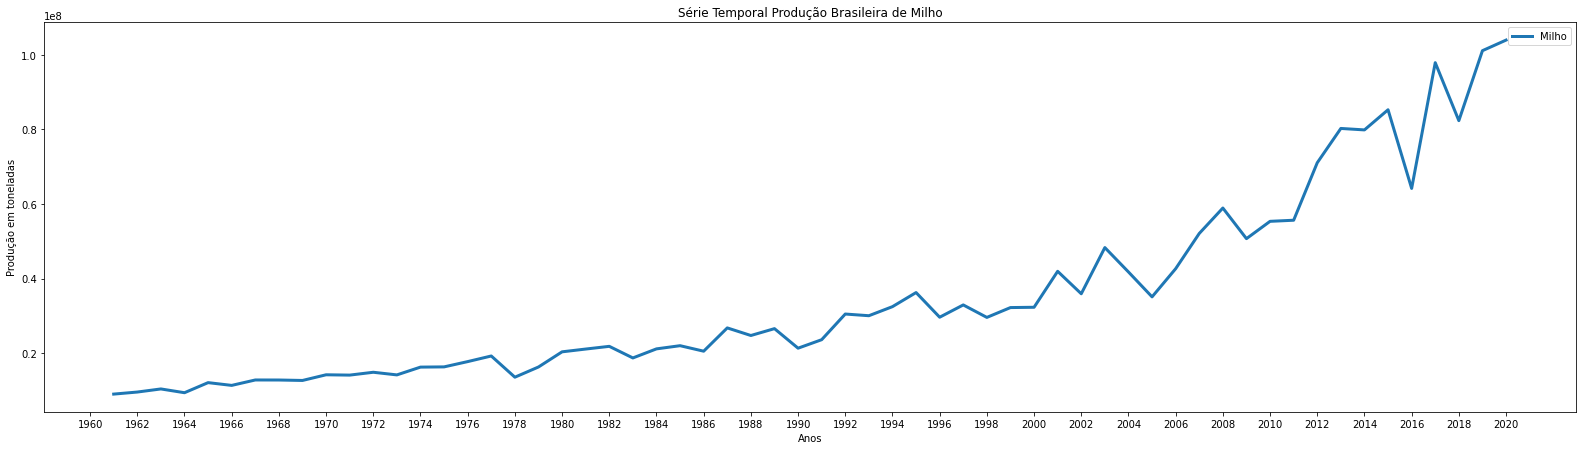

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(milho_brasil['Year Code'], milho_brasil['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produção Brasileira de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))


plt.show()

Pela análise do gráfico é perceptível o grande aumento da produção a partir de 2000, esse aumento se deve principalmente a dois fatores incentivos governamentais para modernização agricola, como a criação do Programa de Modernização da Frota de Tratores Agrícolas e Implementos Associados e Colheitadeiras (MODERFROTA) que facilitou não só a compra de maquinários mais eficientes mas principalmente a sistemas de irrigação que possibilitaram a produção de 3 safras anuais, além do programa o grande investimeto em melhoras genéticas e estratégias de plantio fizeram com que houvesse um aumento gigantesco na produção do grão.

https://periodicos.uem.br/ojs/index.php/EconRev/article/view/50212/pdf

https://www.scielo.br/j/rceres/a/N8fCSz8xJw7gy98s8nkTqmJ/?lang=pt

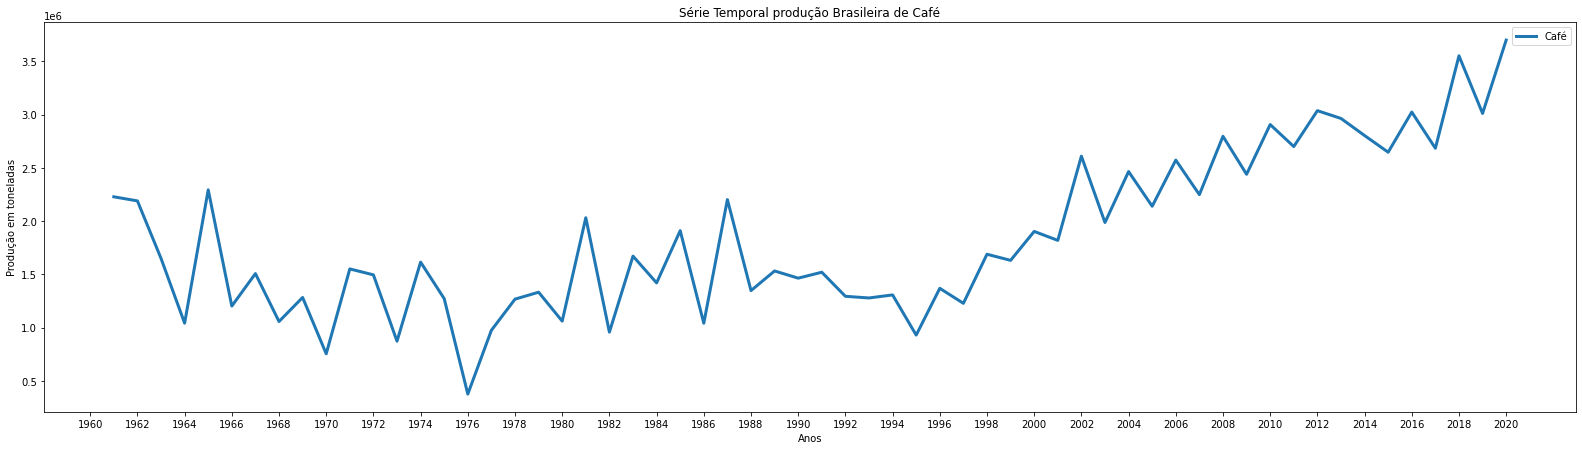

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(cafe_brasil['Year Code'], cafe_brasil['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal produção Brasileira de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
plt.show()

No gráfico é evidente que a produção de café no Brasil é cíclica poŕem três momentos ficam evidentes quebras de safra, em 1964, 1966 e em 1975. Essas quebras se justificam principalmente por fatores políticos e climáticos, tanto em 1964 e 1966 no governo Castelo Branco o café foi utilizado para ajudar no controle da inflação por meio de diversificação de produção. A grande produção em 1960,1962,1965 gerou uma quantidade muito grande de estoques, para controlar o preço do produto a produção de café foi fortemente controlada. Ja em 1976 a baixa produção se deve ao fato da geada negra em 1975 que afetou o estado do Paraná (o maior produtor do grão nessa época) e destruiu grande parte da produção. 

https://revistacafeicultura.com.br/?mat=66568

https://www.eco.unicamp.br/images/arquivos/artigos/882/formacao3-2.pdf

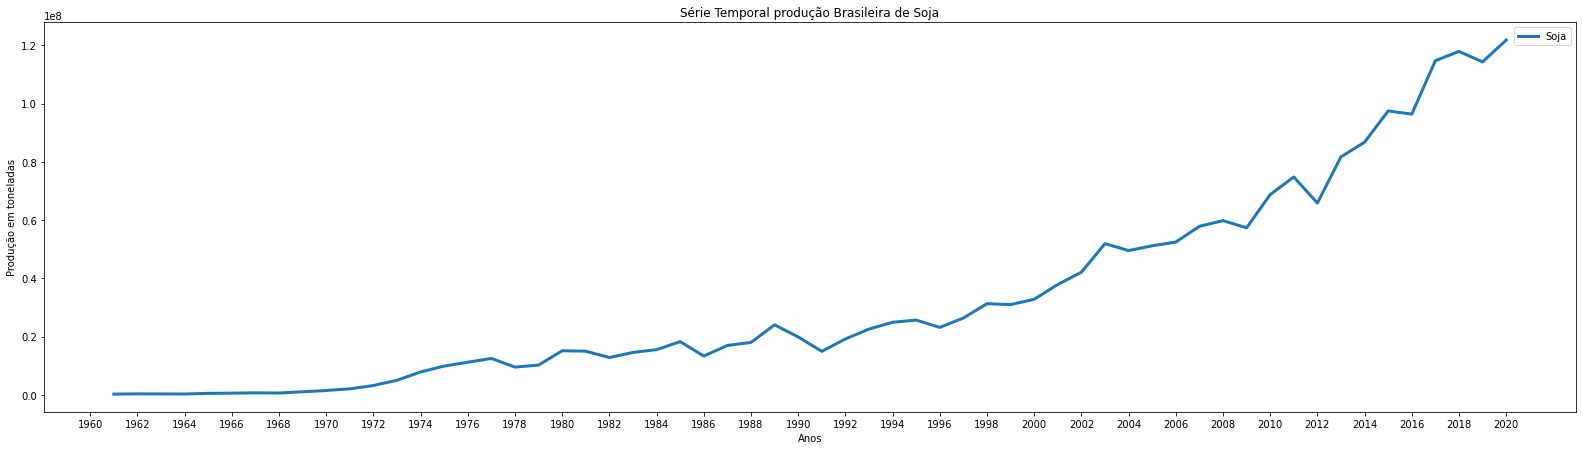

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(soja_brasil['Year Code'], soja_brasil['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal produção Brasileira de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))


plt.show()

Apesar da soja ter sido introduzida no país em 1908 o primeiro aumento consideravel na produção da soja foi na decada de 1970 pois em 1975 a Embrapa (Empresa Brasileira de Pesquisa Agropecuária) desenvolveu uma variedade do grão que é mais adaptada ao clima brasileiro, outro aumento de produção perceptivel no meio da decada de 1990 se deve a liberação a produção de cultivares transgênicas de maneira que a soja mais resistente a herbicidas começou a ser cultivada em fins experimentais e futuramente, em 2005, é liberada a comercialização dessa variedade. https://aprosojabrasil.com.br/a-soja/

## Café Arábica


In [ ]:
# 5312 - Area Harvested (hectares)
# 5510 - Total production (tonnes)
df_cafe = producao[producao['Item'] == 'Coffee, green']
area_cafe = df_cafe[df_cafe['Element Code'] == 5312]
prod_cafe = df_cafe[df_cafe['Element Code'] == 5510]
preco_cafe['date'] = pd.to_datetime(preco_cafe['date'], format='%Y-%m-%d')
preco_cafe[' value']=33.3*preco_cafe[' value'] #converte bushel para tonelada

Variação dos Preços do café





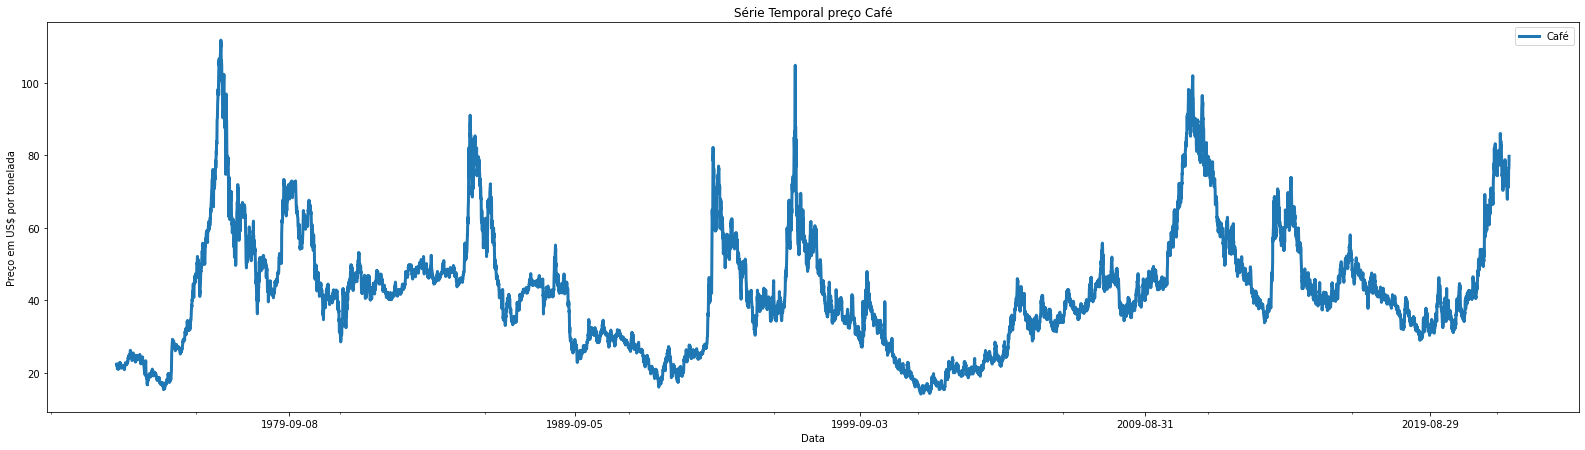

In [ ]:
#Serie temporal variacao de preco
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(preco_cafe['date'], preco_cafe[' value'], label='Café', 
         linewidth=3)

axs.set_title('Série Temporal preço Café')
axs.set_xlabel('Data')
axs.xaxis.set_major_locator(MultipleLocator(3650))
axs.xaxis.set_minor_locator(MultipleLocator(1850))
axs.set_ylabel('Preço em US$ por tonelada')

axs.legend()
axs.locator_params ('Data', nbins = 10) 

plt.show()

### Mundo

#### Variação produção mundial

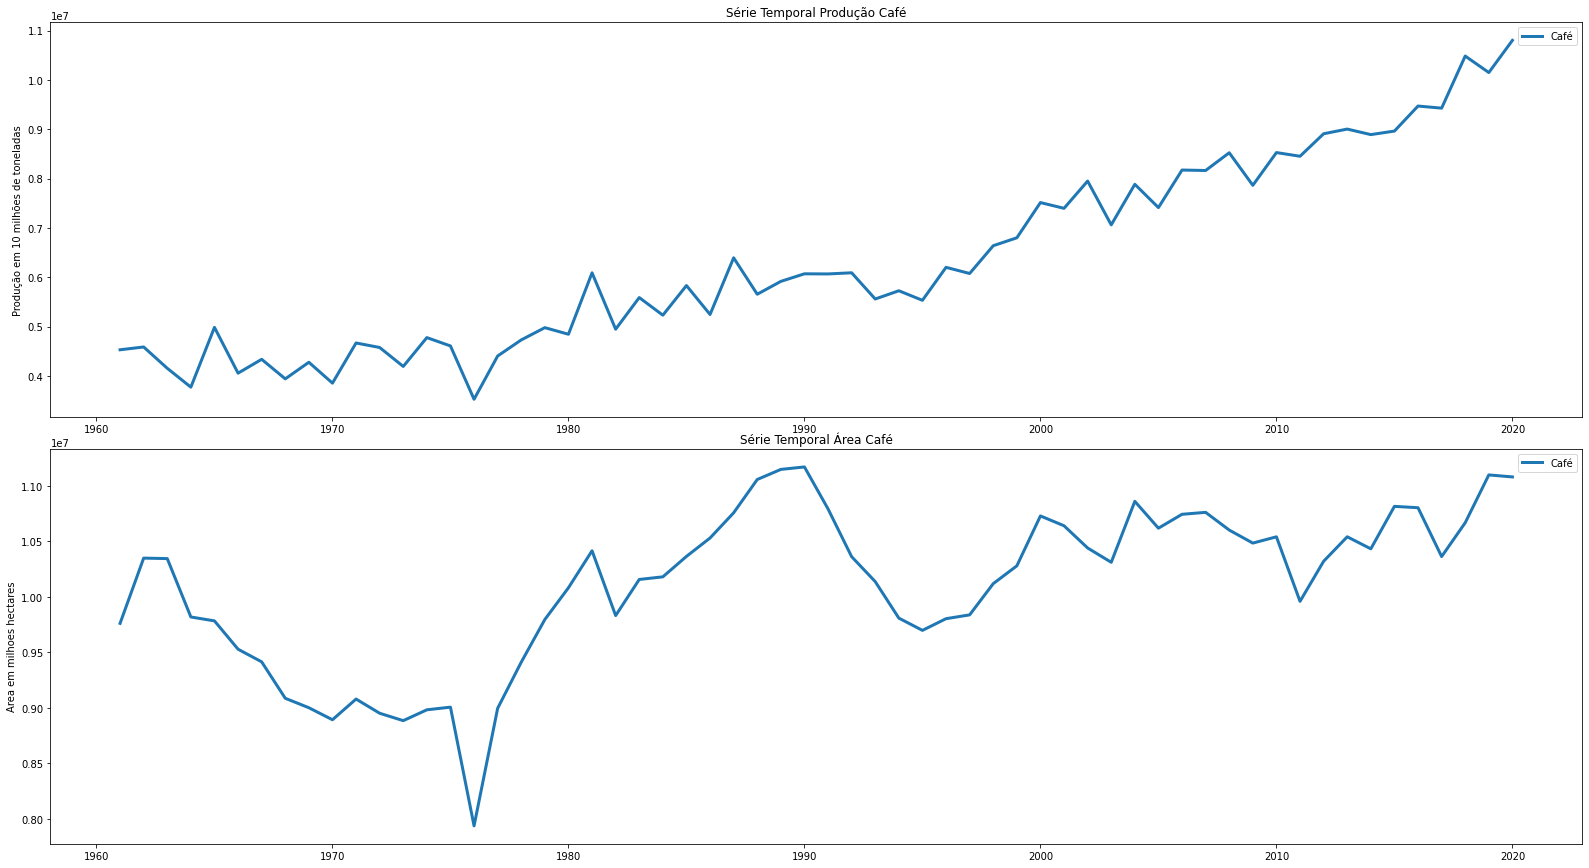

In [ ]:
#Serie temporal variacao da produção
prod_cafe_anual = prod_cafe[['Year', 'Value']].groupby('Year').sum()
prod_cafe_anual = prod_cafe_anual.reset_index()
#Serie temporal variacao da area
area_cafe_anual = area_cafe[['Year', 'Value']].groupby('Year').sum()
area_cafe_anual = area_cafe_anual.reset_index()
plot_mundo(prod_cafe_anual, area_cafe_anual, 'Café')

#### Análise de produtividade

In [ ]:
world_efficiency = []
for year in range(1961, 2021):
  prod = prod_cafe_anual[prod_cafe_anual['Year'] == year].iloc[0]['Value']
  area = area_cafe_anual[area_cafe_anual['Year'] == year].iloc[0]['Value']
  world_efficiency.append(round((prod / area), 2))
world_efficiency
df_eff = pd.DataFrame({"Year": [y for y in range(1961, 2021)], "Prod/Hec": world_efficiency})

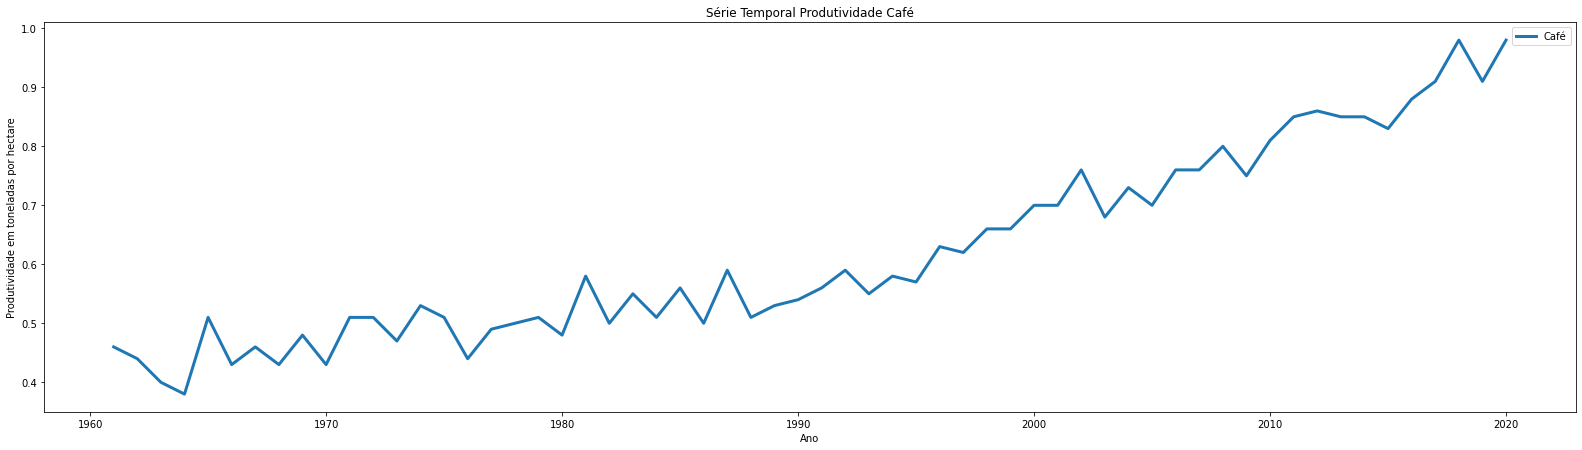

In [ ]:
#Serie temporal variacao da produção
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(df_eff['Year'], df_eff['Prod/Hec'], label='Café', 
         linewidth=3)

axs.set_title('Série Temporal Produtividade Café')
axs.set_xlabel('Ano')
axs.set_ylabel('Produtividade em toneladas por hectare')

axs.legend()

plt.show()

### Continentes

In [ ]:
continentes_prod = get_continentes(prod_cafe)
continentes_area = get_continentes(area_cafe)

#### Africa

Top 10%
('Ethiopia', 251092.3550242131)
("C?te d'Ivoire", 197828.94794188862)
('Ethiopia PDR', 174952.37288135593)
('Uganda', 169623.30720338982)
Bottom 10%
('Comoros', 100.0796004842615)
('Cabo Verde', 51.958837772397096)
('Sao Tome and Principe', 28.096549636803875)


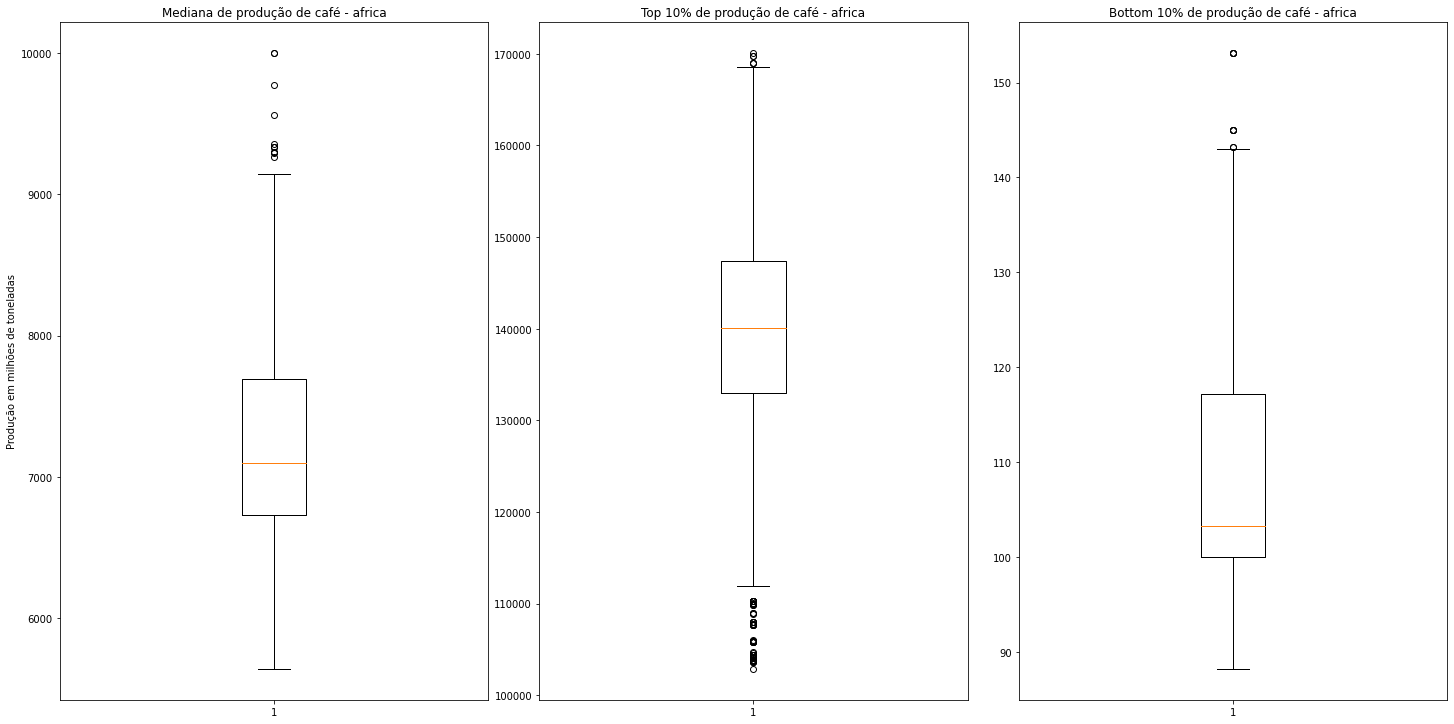

In [ ]:
# Africa
africa_prod = continentes_prod['africa']
africa_prod = africa_prod[africa_prod['Area'] != 'Mauritius']
values_a, li_a_median, ls_a_median = get_status_continente(africa_prod, 'africa', 'café')

#### Asia

Top 10%
('Indonesia', 415278.18079800496)
Bottom 10%
('Saudi Arabia', 0.12468827930174564)


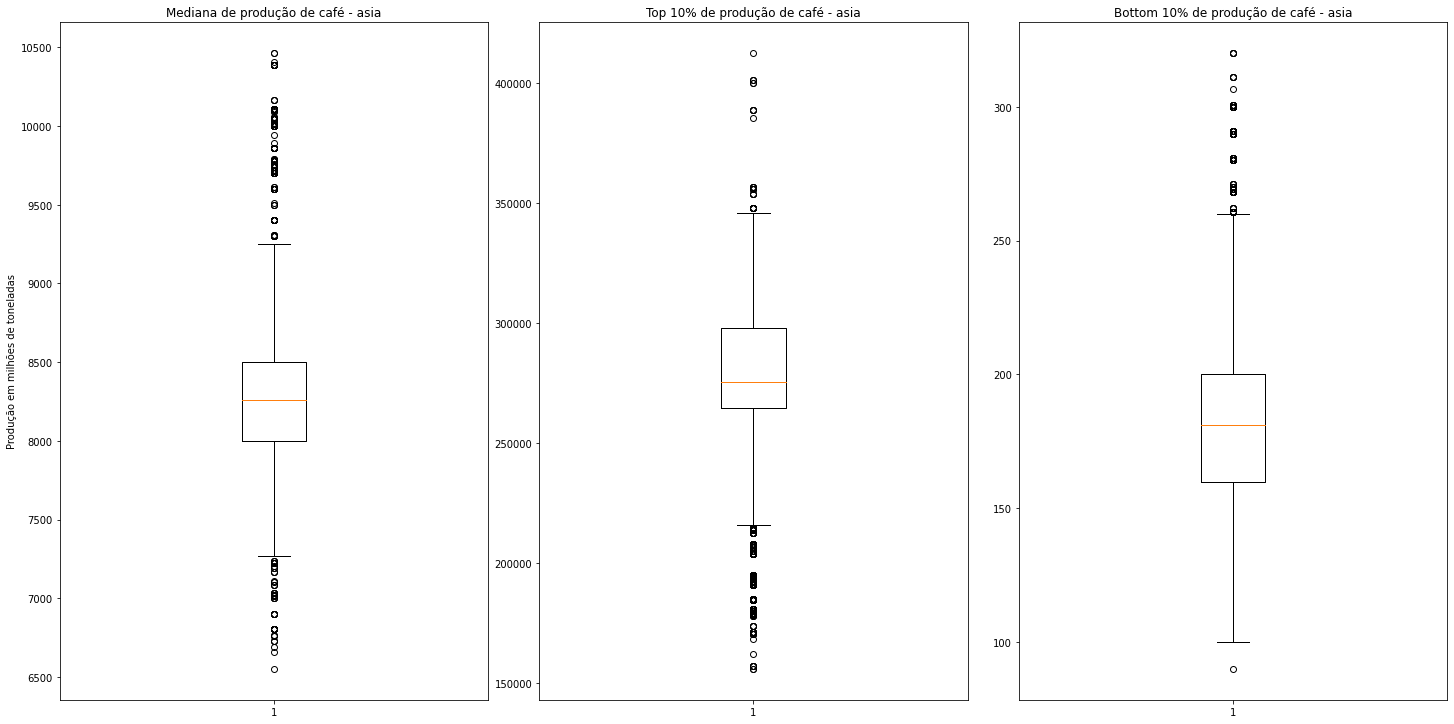

In [ ]:
# Asia
asia_prod = continentes_prod['asia']
values_asi, li_asi_median, ls_asi_median = get_status_continente(asia_prod, 'asia', 'café')

#### America

##### Norte

Top 10%
('Mexico', 243630.16381156316)
('Guatemala', 200157.97858672377)
Bottom 10%
('Saint Vincent and the Grenadines', 147.40899357601714)
('Belize', 89.90578158458244)
('Saint Lucia', 21.978051391862955)


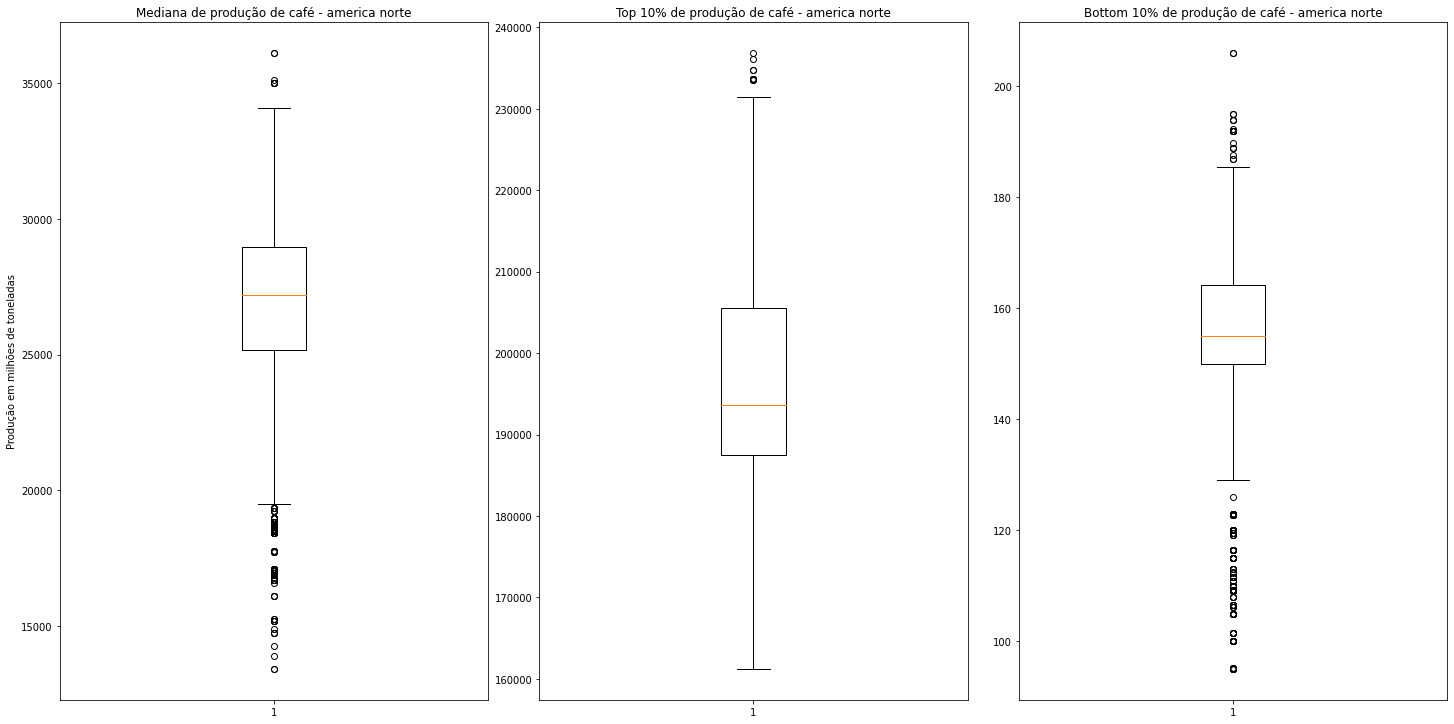

In [ ]:
# America Norte
america_norte_prod = continentes_prod['america_n']
values_an, li_an_median, ls_an_median = get_status_continente(america_norte_prod, 'america norte', 'café')

##### Sul


Top 10%
('Colombia', 670721.6095238095)
Bottom 10%
('Suriname', 42.23452380952381)


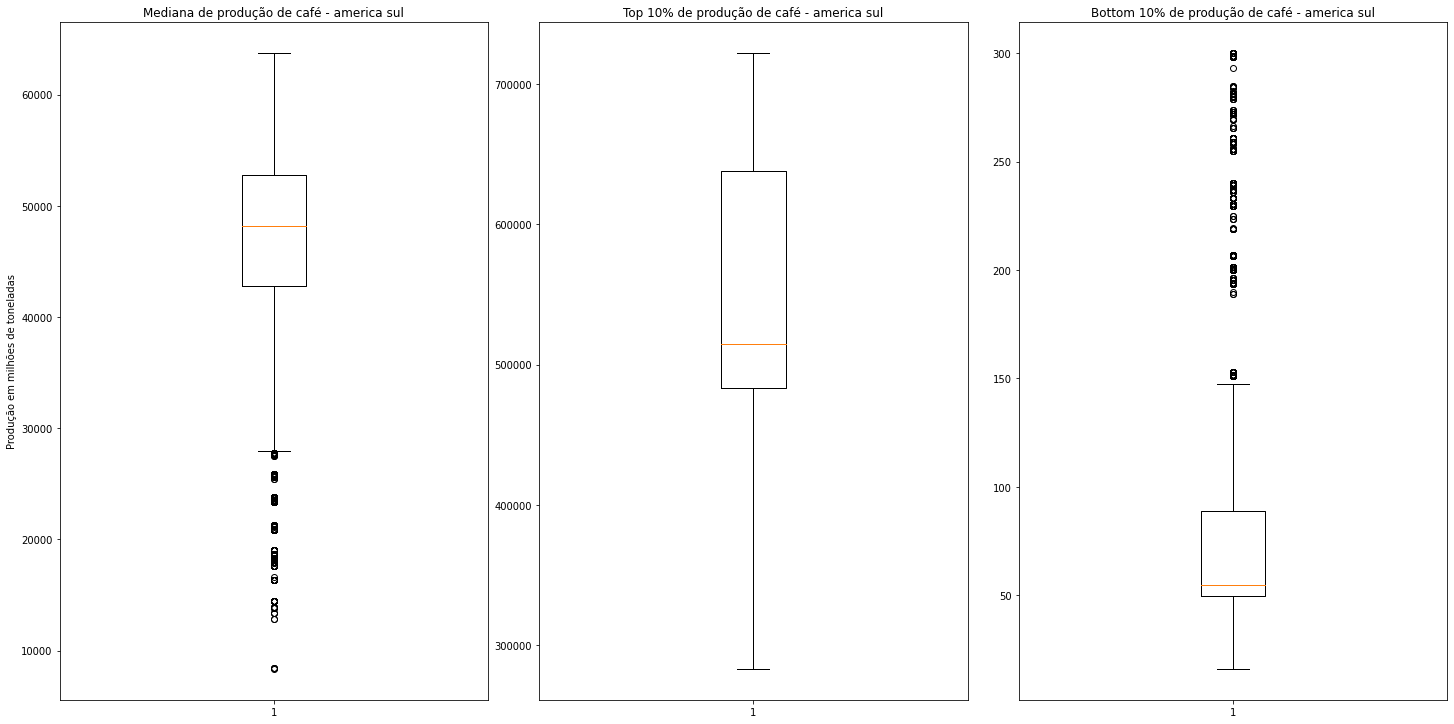

In [ ]:
# America Sul
america_sul_prod = continentes_prod['america_s']
values_as, li_as_median, ls_as_median = get_status_continente(america_sul_prod, 'america sul', 'café')

#### Europa

Top 10%
Bottom 10%


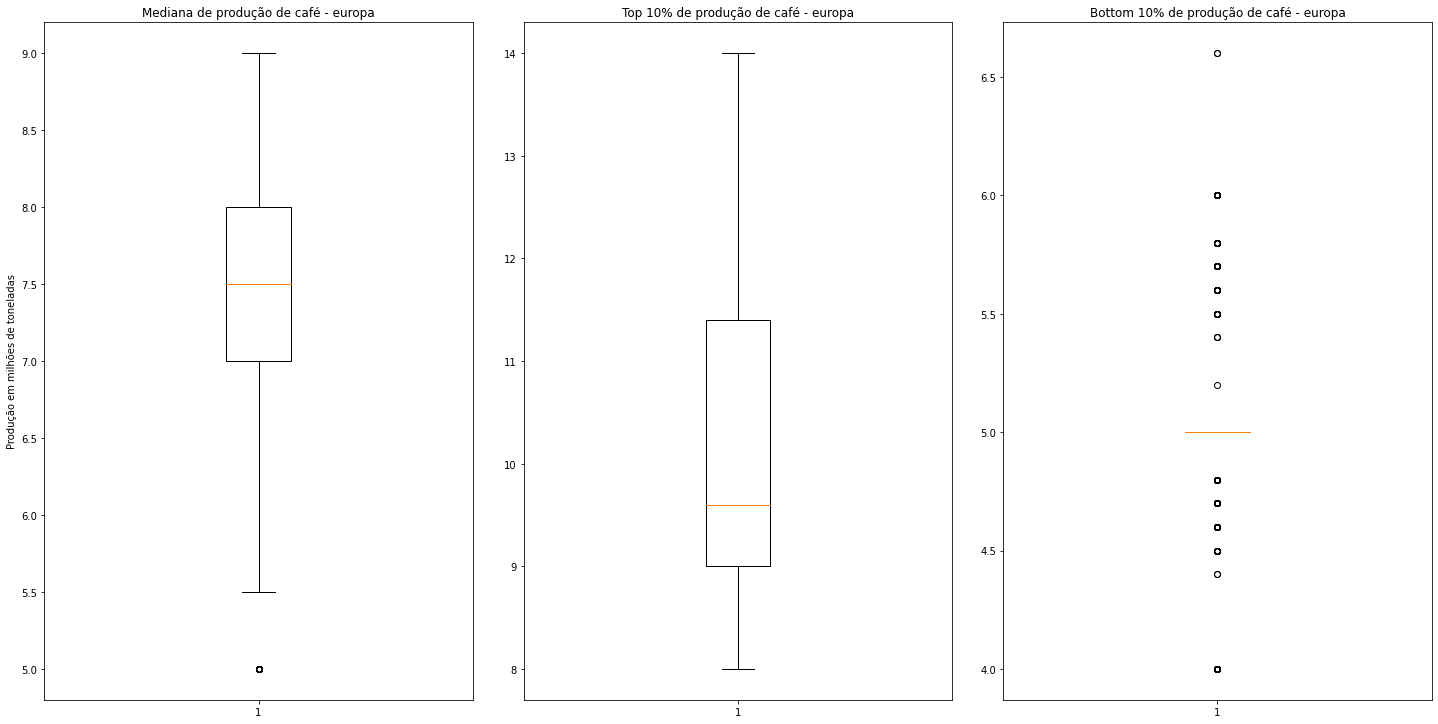

In [ ]:
# Europa
europa_prod = continentes_prod['europa']
values_eu, li_eu_median, ls_eu_median = get_status_continente(europa_prod, 'europa', 'café')

#### Oceania

Top 10%
('Papua New Guinea', 50716.22743682311)
Bottom 10%


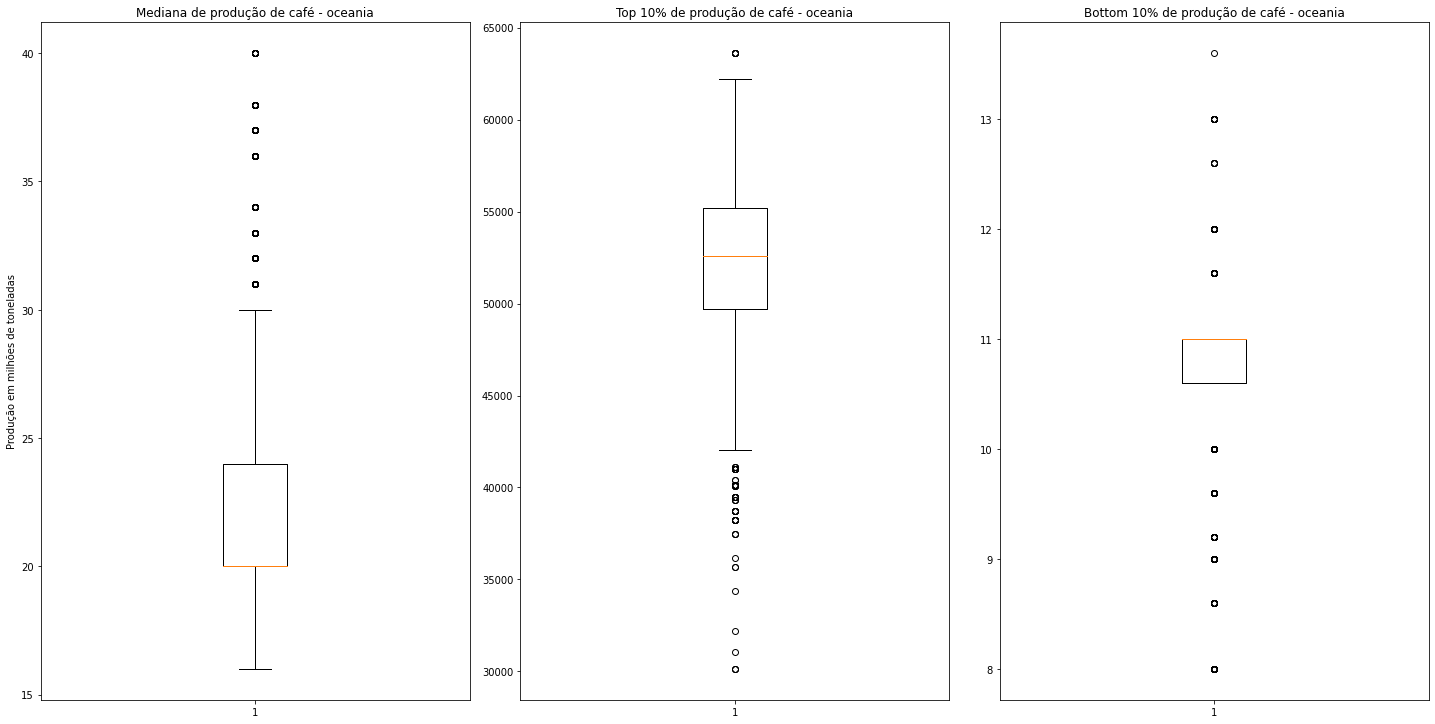

In [ ]:
# Oceania
oceania_prod = continentes_prod['oceania']
values_oc, li_oc_median, ls_oc_median = get_status_continente(oceania_prod, 'oceania', 'café')

###Comparação

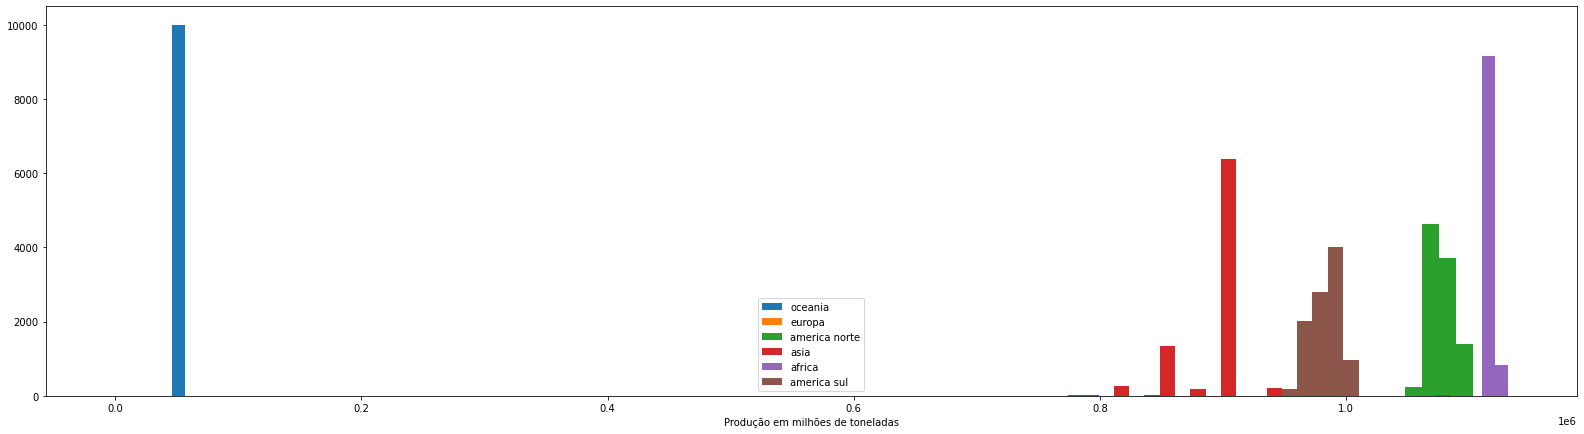

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()

axs.hist(values_oc, bins=1, label='oceania')
axs.hist(values_eu, bins=1, label='europa')
axs.hist(values_an, bins=5, label='america norte')
axs.hist(values_asi, bins=25, label='asia')
axs.hist(values_a, bins=2, label='africa')
axs.hist(values_as, bins=5, label='america sul')

axs.set_xlabel('Produção em milhões de toneladas')
axs.legend()
plt.show()

É perceptível que a América do Sul não se posiciona em primeiro sem a produção do Brasil. Como a África se posiciona como primeira colocada basta verificar se a tendência observada no Brasil se repete nela. 

0.017431535972211143


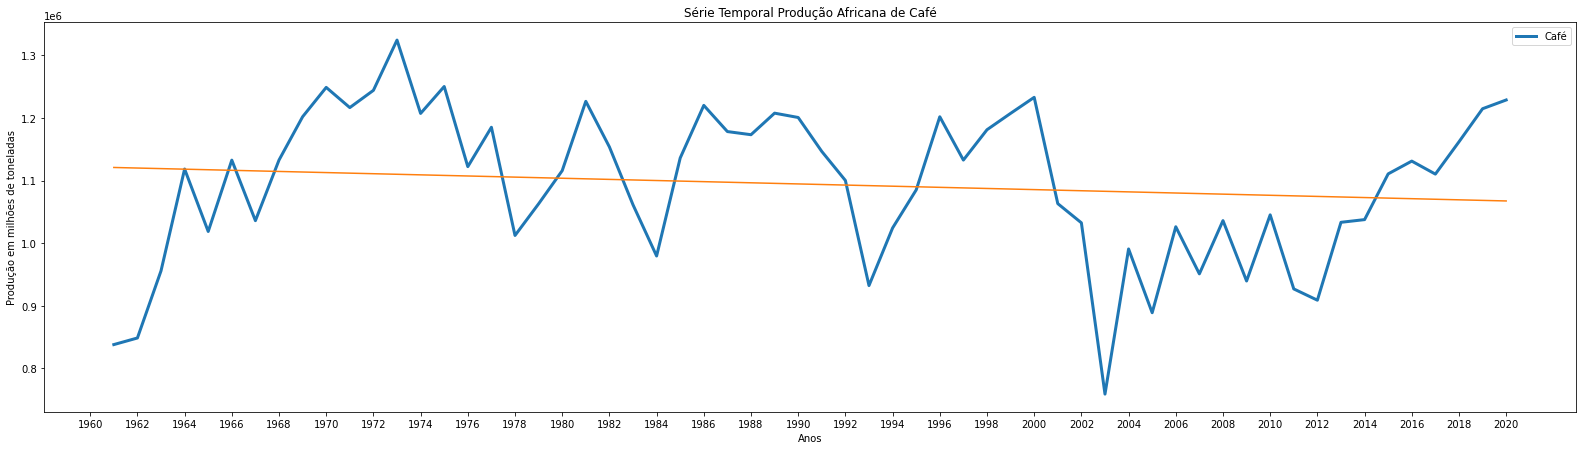

In [ ]:
cafe_a = continentes_prod['africa'].groupby('Year').sum()
cafe_a = cafe_a.reset_index()
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(cafe_a['Year'], cafe_a['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal Produção Africana de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em milhões de toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
reg = LinearRegression().fit(np.array(cafe_a['Year']).reshape(-1, 1), cafe_a['Value'])
print(reg.score(np.array(cafe_a['Year']).reshape(-1, 1), cafe_a['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

Por mais que a África seja a maior produtora quando removemos o Brasil do cenário vemos uma leve tendência de diminuição na produção de café africano ao longo dos anos.

### Produtividade

In [ ]:
produtividade = []
for country in prod_cafe['Area'].unique():
  for year in prod_cafe['Year'].unique():
    v = prod_cafe[(prod_cafe['Year'] == year) & (prod_cafe['Area'] == country)]
    a = area_cafe[(area_cafe['Year'] == year) & (area_cafe['Area'] == country)]
    if (len(v) > 0) and (len(a) > 0):
      if v.isna().iloc[0]['Value']:
        continue
      elif a.isna().iloc[0]['Value']:
        continue
      else:
        v = v.iloc[0]['Value']
        a = a.iloc[0]['Value']
        if a > 0:
          produtividade.append([year, country, (v/a)])

In [ ]:
df_prod = pd.DataFrame(produtividade, columns=['Year', 'Area', 'Value'])

#### Continentes

In [ ]:
continentes_produtiv = get_continentes(df_prod)

##### Africa

Desconsideramos as ilhas Maurício por estarem afetando a análise de produtividade da África, uma vez que o valor de 13 ton/ha está fora da realidade da maioria dos países africanos, mesmo os grandes produtores.

Top 10%
('Sierra Leone', 1.6925007568298824)
('Zimbabwe', 1.1724248099463628)
('Malawi', 0.978431414613574)
Bottom 10%
('Comoros', 0.1481320490351099)
('Sao Tome and Principe', 0.11999428897772704)


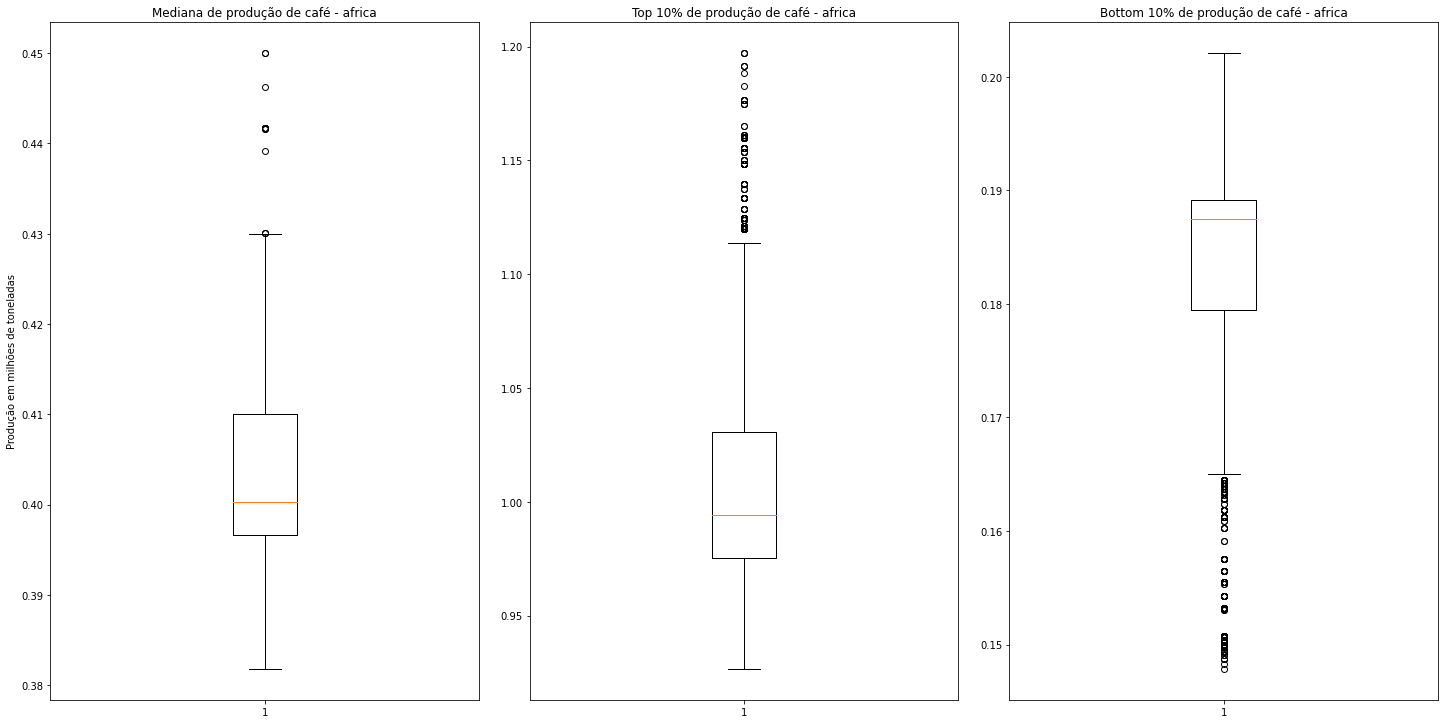

In [ ]:
# Africa
africa_produtiv = continentes_produtiv['africa']
africa_produtiv = africa_produtiv[africa_produtiv['Area'] != 'Mauritius']
values_a_p, li_a_p_median, ls_a_p_median = get_status_continente(africa_produtiv, 'africa', 'café', False)
africa_prod = continentes_prod['africa'].groupby('Year').sum()
africa_area = continentes_area['africa'].groupby('Year').sum()

0.3754467784291843


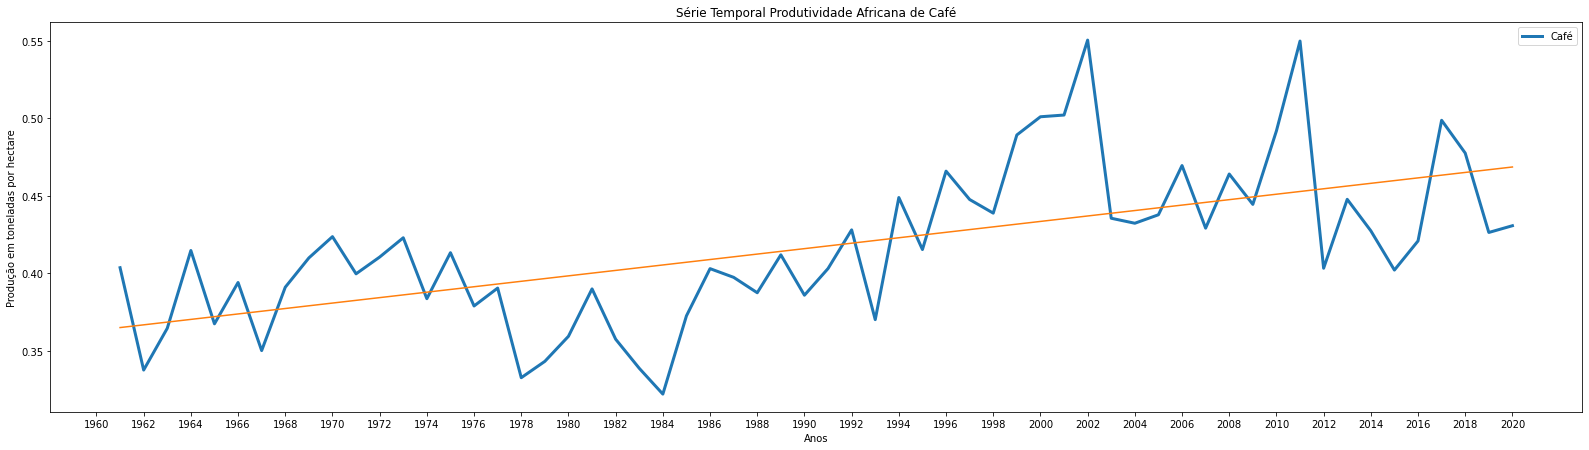

In [ ]:
africa_c_produtiv = (africa_prod / africa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(africa_c_produtiv['Year'], africa_c_produtiv['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Africana de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
cafe_a_reg = LinearRegression().fit(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value'])
print(cafe_a_reg.score(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = cafe_a_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Asia

Top 10%
('Viet Nam', 1.386568204560157)
Bottom 10%
('Timor-Leste', 0.22462232586054212)
('Nepal', 0.2097030759177)


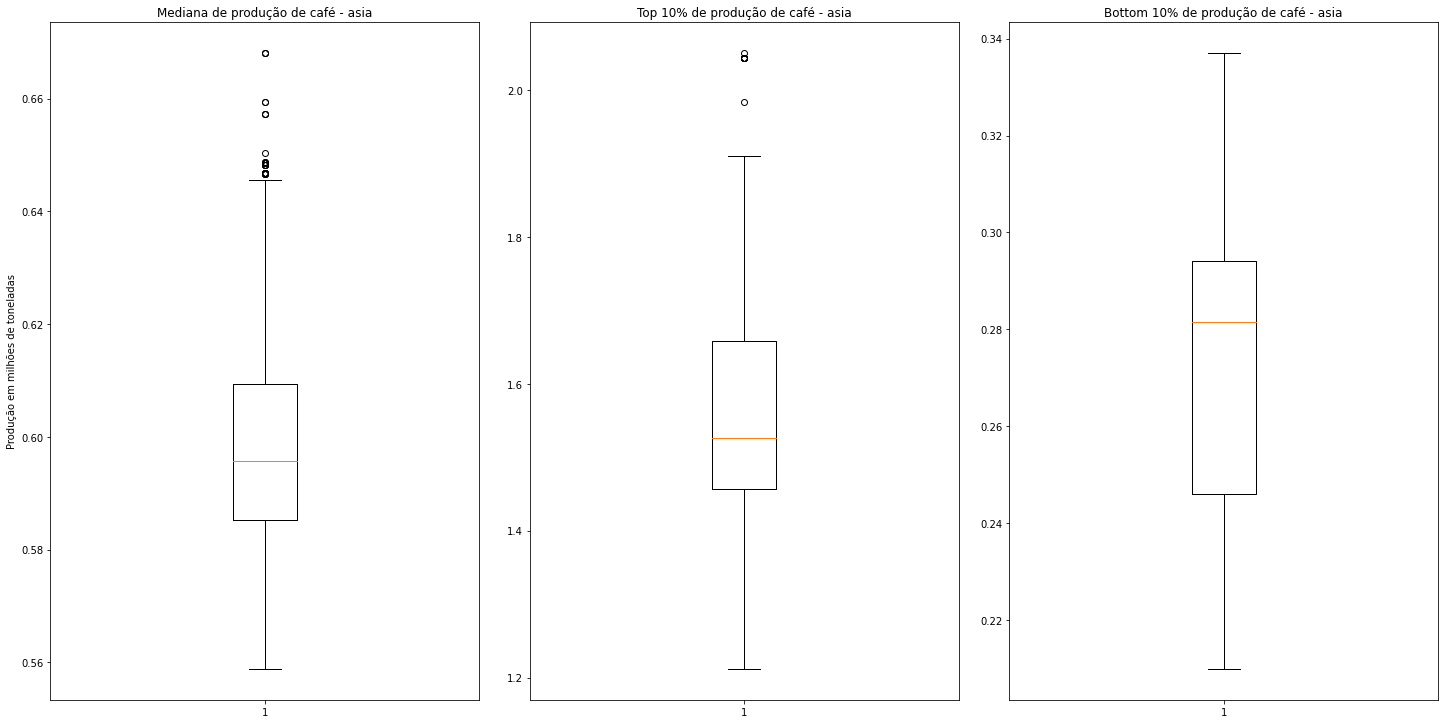

In [ ]:
# Asia
asia_produtiv = continentes_produtiv['asia']
values_asi_p, li_asi_p_median, ls_asi_p_median = get_status_continente(asia_produtiv, 'asia', 'café', False)
asia_prod = continentes_prod['asia'].groupby('Year').sum()
asia_area = continentes_area['asia'].groupby('Year').sum()

0.8590234765737399


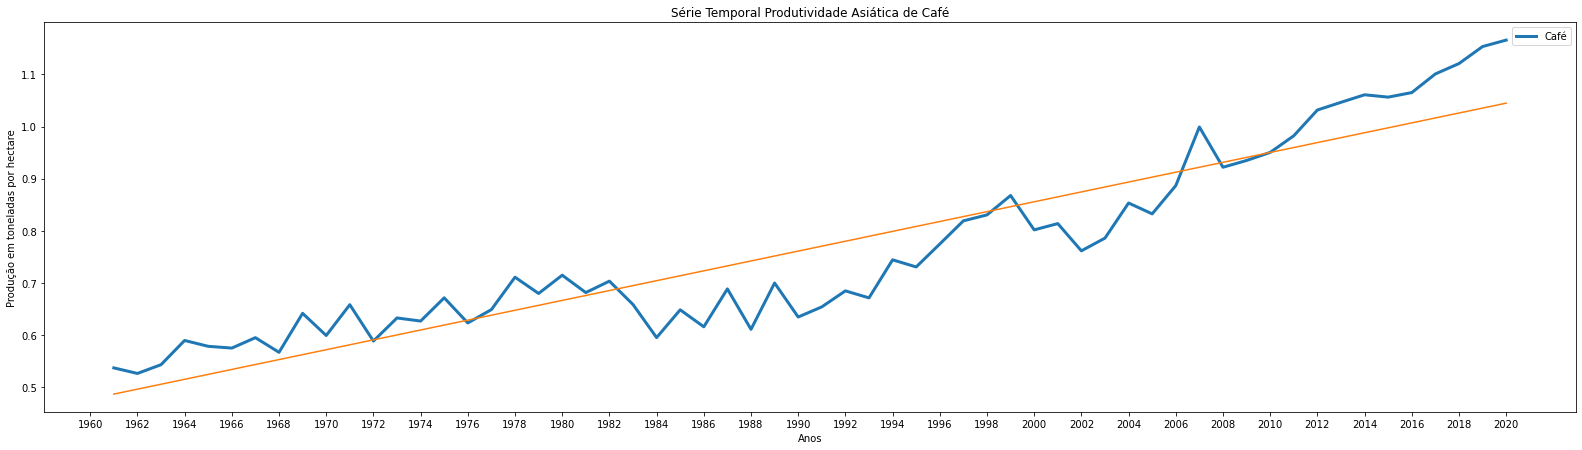

In [ ]:
asia_c_produtiv = (asia_prod / asia_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(asia_c_produtiv['Year'], asia_c_produtiv['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Asiática de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
cafe_asi_reg = LinearRegression().fit(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value'])
print(cafe_asi_reg.score(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = cafe_asi_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### America


###### Norte

Top 10%
('Belize', 1.7468186690051644)
('Costa Rica', 1.1647180208854822)
('United States of America', 1.1320406242503833)
Bottom 10%
('Cuba', 0.2346589881728959)
('Trinidad and Tobago', 0.1610274483822715)


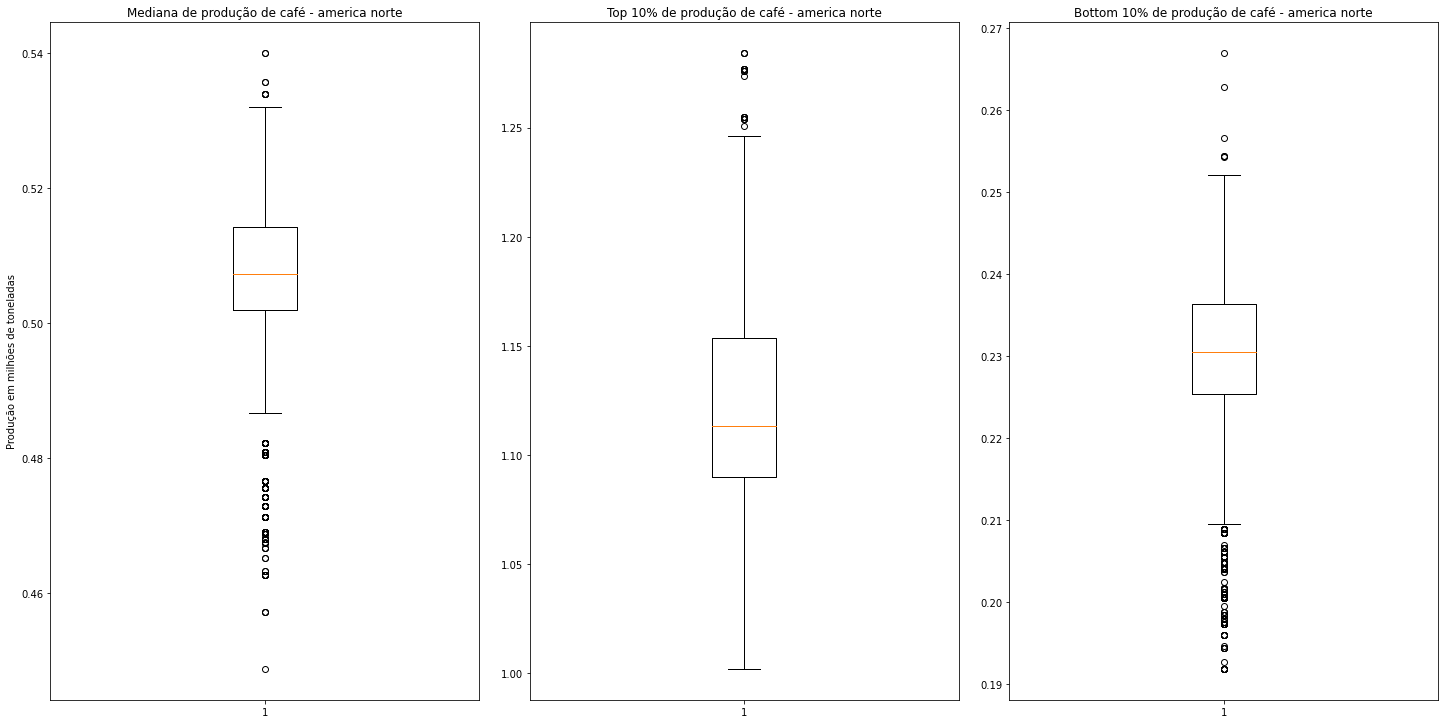

In [ ]:
# America Norte
america_n_produtiv = continentes_produtiv['america_n']
values_a_n_p, li_a_n_p_median, ls_a_n_p_median = get_status_continente(america_n_produtiv, 'america norte', 'café', False)
america_n_prod = continentes_prod['america_n'].groupby('Year').sum()
america_n_area = continentes_area['america_n'].groupby('Year').sum()

0.37032530975697764


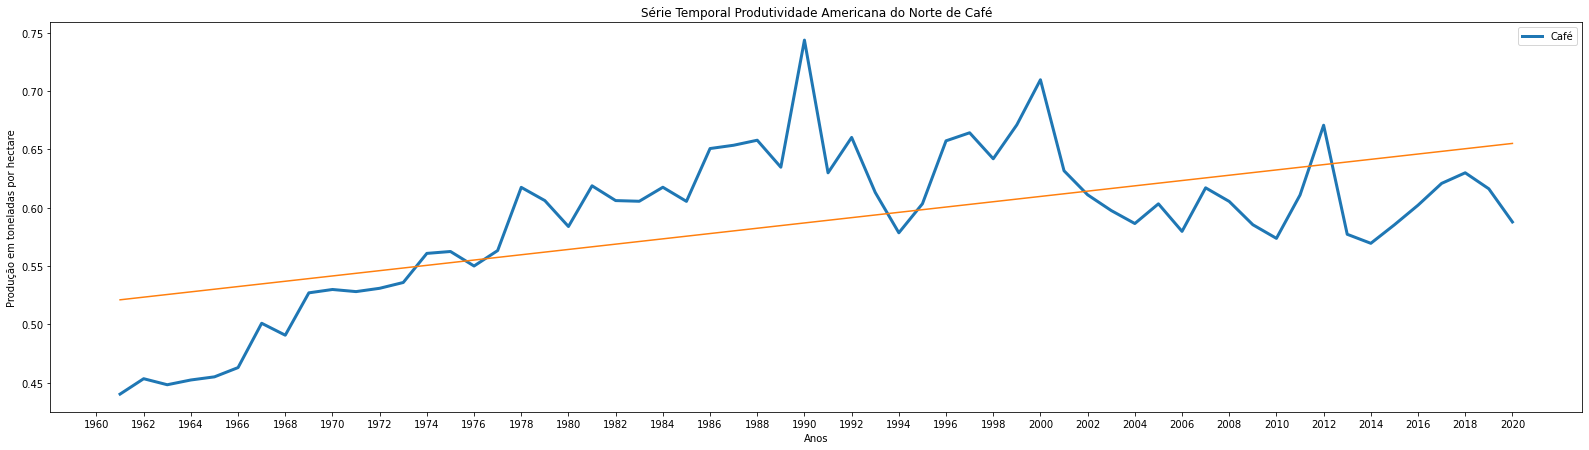

In [ ]:
america_n_c_produtiv = (america_n_prod / america_n_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_n_c_produtiv['Year'], america_n_c_produtiv['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Americana do Norte de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
cafe_a_n_reg = LinearRegression().fit(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value'])
print(cafe_a_n_reg.score(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = cafe_a_n_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

###### Sul

Top 10%
('Paraguay', 0.9312726265672363)
Bottom 10%
('Suriname', 0.16858701710781793)


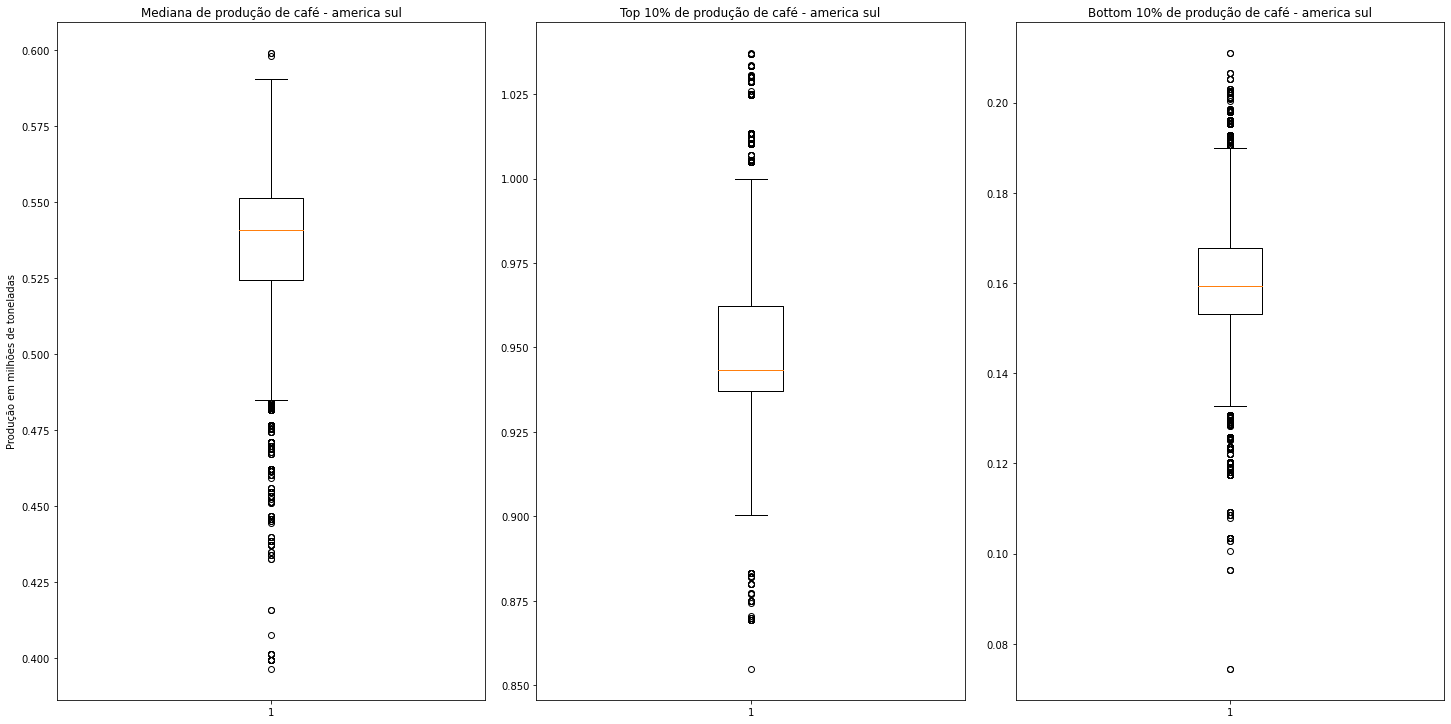

In [ ]:
# America sul
america_s_produtiv = continentes_produtiv['america_s']
values_a_s_p, li_a_s_p_median, ls_a_s_p_median = get_status_continente(america_s_produtiv, 'america sul', 'café', False)
america_s_prod = continentes_prod['america_s'].groupby('Year').sum()
america_s_area = continentes_area['america_s'].groupby('Year').sum()

0.8065089287457748


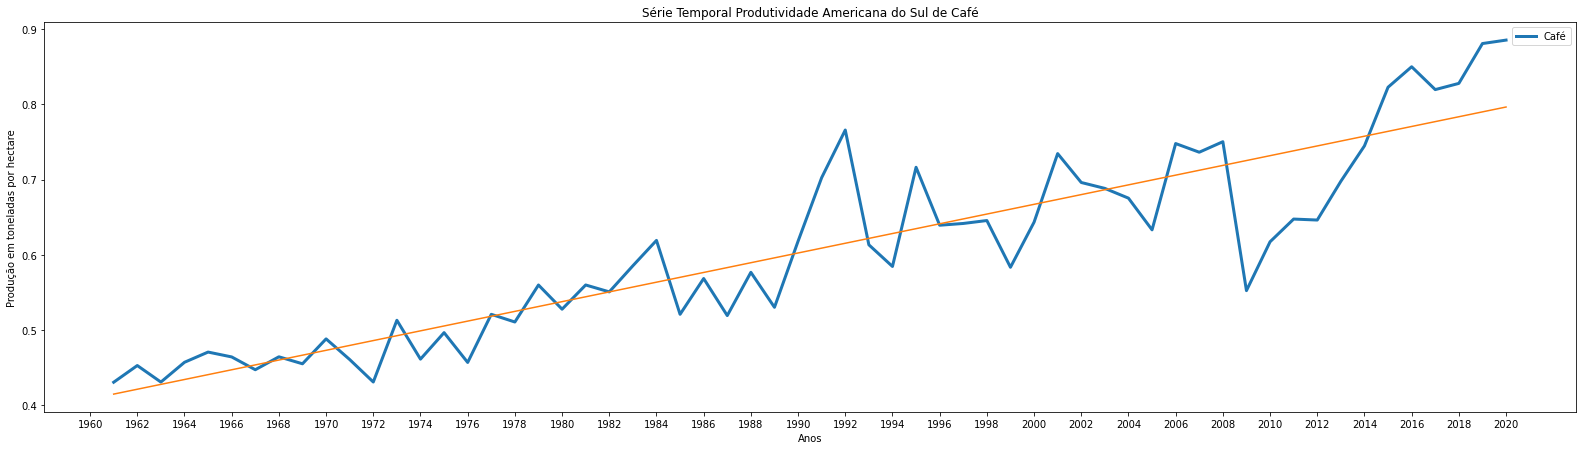

In [ ]:
america_s_c_produtiv = (america_s_prod / america_s_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_s_c_produtiv['Year'], america_s_c_produtiv['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Americana do Sul de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
cafe_a_s_reg = LinearRegression().fit(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value'])
print(cafe_a_s_reg.score(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = cafe_a_s_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Europa

A Europa não possui uma produção de café expressiva. O único país que consta na base é a Espanha, cujos dados não estão completos faltando as informações sobre a área plantada.

##### Oceania

Top 10%
('Tonga', 1.7443269726663229)
Bottom 10%


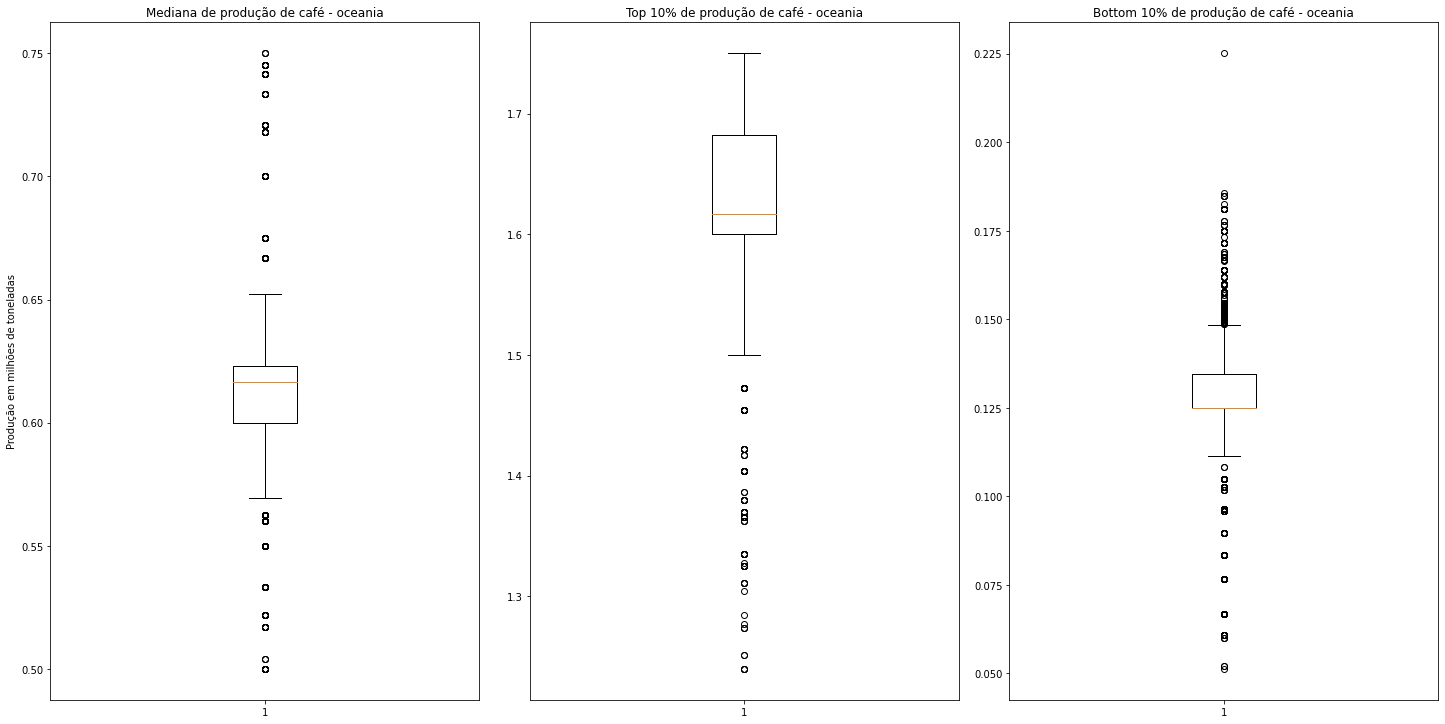

In [ ]:
# Oceania
oceania_produtiv = continentes_produtiv['oceania']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(oceania_produtiv, 'oceania', 'café', False)
oceania_prod = continentes_prod['oceania'].groupby('Year').sum()
oceania_area = continentes_area['oceania'].groupby('Year').sum()

0.008933212197044016


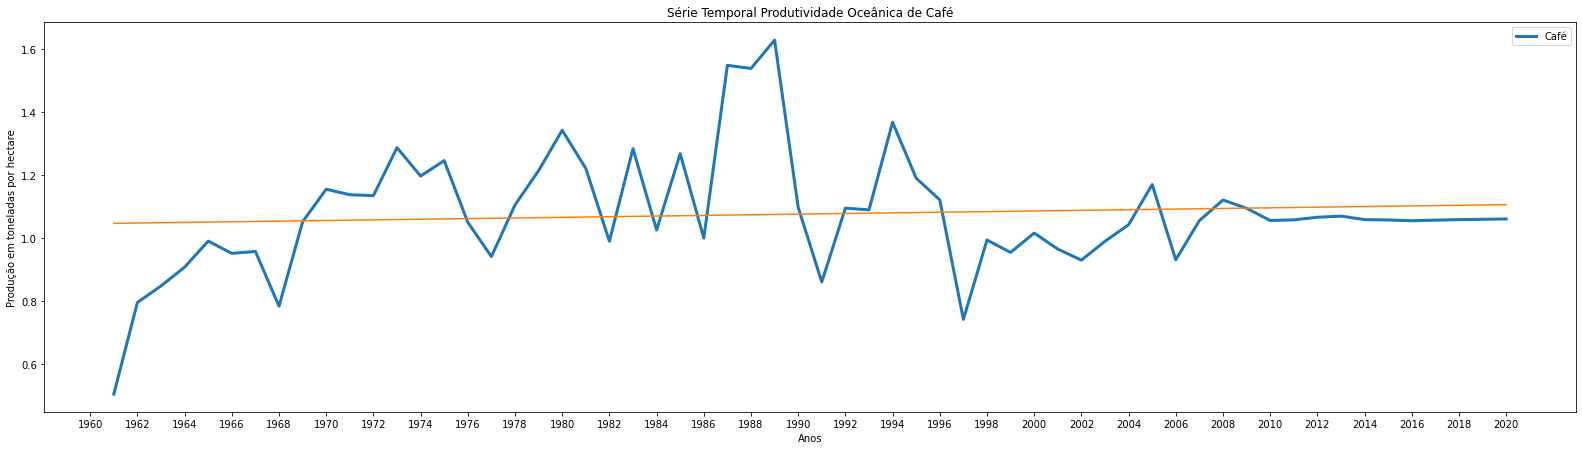

In [ ]:
oceania_c_produtiv = (oceania_prod / oceania_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(oceania_c_produtiv['Year'], oceania_c_produtiv['Value'], label='Café', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Oceânica de Café')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
cafe_oc_reg = LinearRegression().fit(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value'])
print(cafe_oc_reg.score(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = cafe_oc_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

Podemos concluir então, que para a produção de café mundial vemos uma tendência do aumento de produtividade, ou seja, mais toneladas de café sendo produzidos por hectare plantado. Apesar de na Oceania esse crescimento não ser significativo.

Continente   | LI (ton/ha) | LS (ton/ha)  
---|---|---
Asia |  0.57 | 0.63
Oceania   | 0.55  |   0.65
America sul | 0.48  | 0.56  |
America norte| 0.49  |  0.52 |
Africa | 0.39  |  0.42   


## Trigo

In [ ]:
# 5312 - Area Harvested (hectares)
# 5510 - Total production (tonnes)
df_trigo = producao[producao['Item'] == 'Wheat']
area_trigo = df_trigo[df_trigo['Element Code'] == 5312]
prod_trigo = df_trigo[df_trigo['Element Code'] == 5510]
preco_trigo['date'] = pd.to_datetime(preco_trigo['date'], format='%Y-%m-%d')
preco_trigo[' value']=33.3*preco_trigo[' value'] #converte bushel para tonelada

Variação dos Preços do Trigo


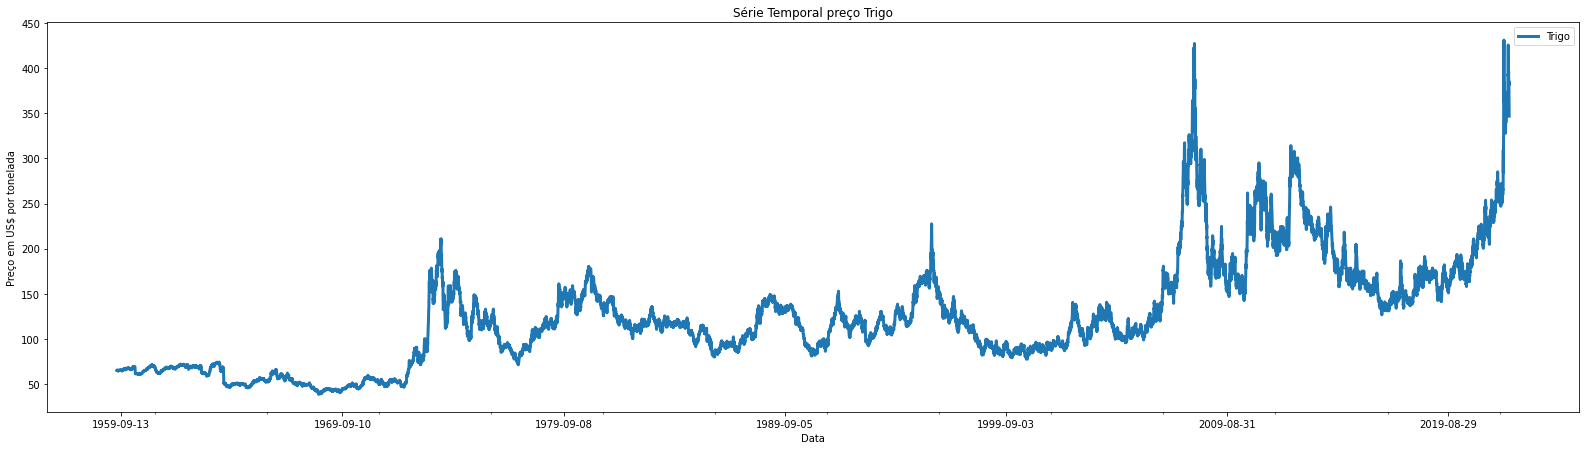

In [ ]:
#Serie temporal variacao de preco
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(preco_trigo['date'], preco_trigo[' value'], label='Trigo', 
         linewidth=3)

axs.set_title('Série Temporal preço Trigo')
axs.set_xlabel('Data')
axs.xaxis.set_major_locator(MultipleLocator(3650))
axs.xaxis.set_minor_locator(MultipleLocator(1850))
axs.set_ylabel('Preço em US$ por tonelada')

axs.legend()
axs.locator_params ('Data', nbins = 10) 

plt.show()

Variação produção mundial

### Mundo

#### Variação produção mundial

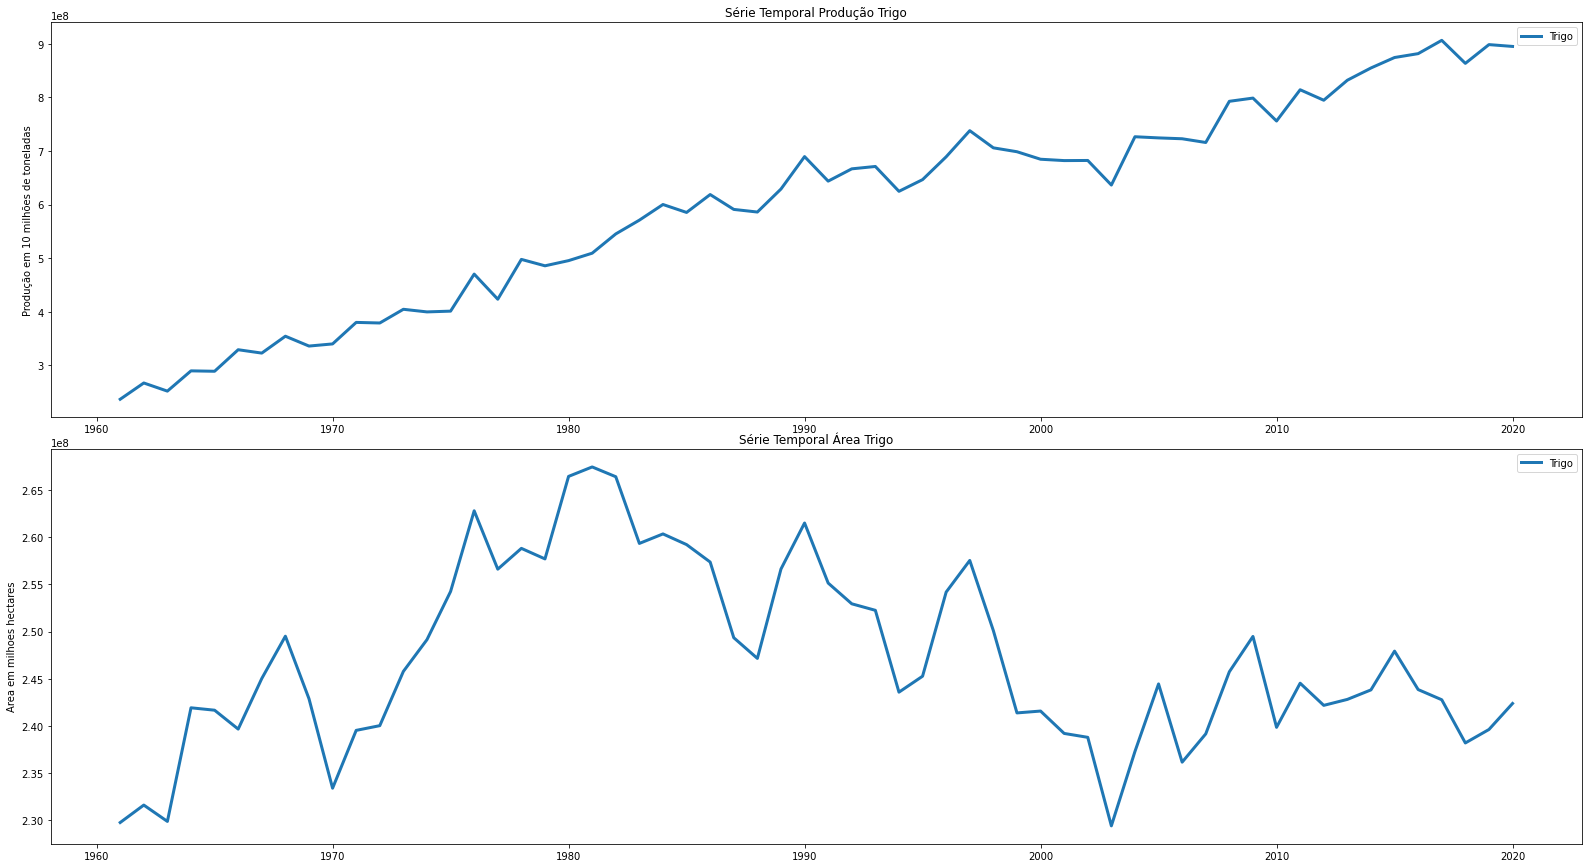

In [ ]:
#Serie temporal variacao da produção
prod_trigo_anual = prod_trigo[['Year', 'Value']].groupby('Year').sum()
prod_trigo_anual = prod_trigo_anual.reset_index()
#Serie temporal variacao da area
area_trigo_anual = area_trigo[['Year', 'Value']].groupby('Year').sum()
area_trigo_anual = area_trigo_anual.reset_index()
plot_mundo(prod_trigo_anual, area_trigo_anual, 'Trigo')

### Ánalise de produtividade

In [ ]:
world_efficiency = []
for year in range(1961, 2021):
  prod = prod_trigo_anual[prod_trigo_anual['Year'] == year].iloc[0]['Value']
  area = area_trigo_anual[area_trigo_anual['Year'] == year].iloc[0]['Value']
  world_efficiency.append(round((prod / area), 2))
world_efficiency
df_eff = pd.DataFrame({"Year": [y for y in range(1961, 2021)], "Prod/Hec": world_efficiency})

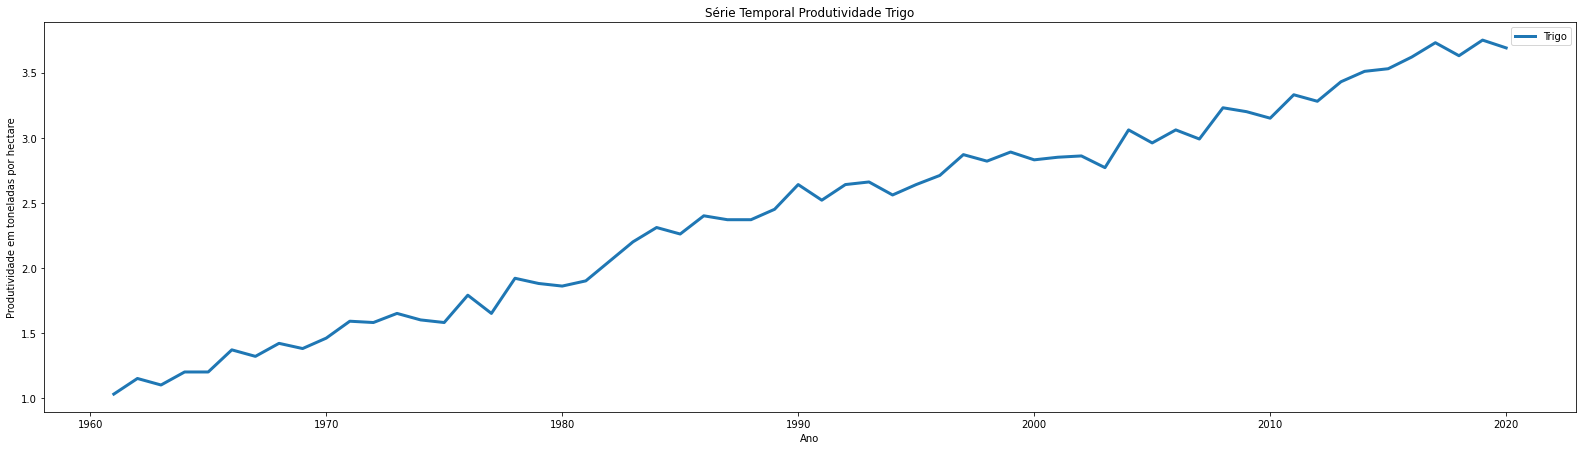

In [ ]:
#Serie temporal variacao da produção
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(df_eff['Year'], df_eff['Prod/Hec'], label='Trigo', 
         linewidth=3)

axs.set_title('Série Temporal Produtividade Trigo')
axs.set_xlabel('Ano')
axs.set_ylabel('Produtividade em toneladas por hectare')

axs.legend()

plt.show()

### Continentes

In [ ]:
continentes_prod = get_continentes(prod_trigo)
continentes_area = get_continentes(area_trigo)

#### Africa

Top 10%
('Egypt', 4259482.684025746)
('Morocco', 2334184.7045055586)
('Ethiopia', 2267387.2381509654)
('South Africa', 1866399.3914569924)
Bottom 10%
('Cameroon', 649.1691047396138)
('Botswana', 500.0983031012288)
('Mauritania', 482.3943826799298)


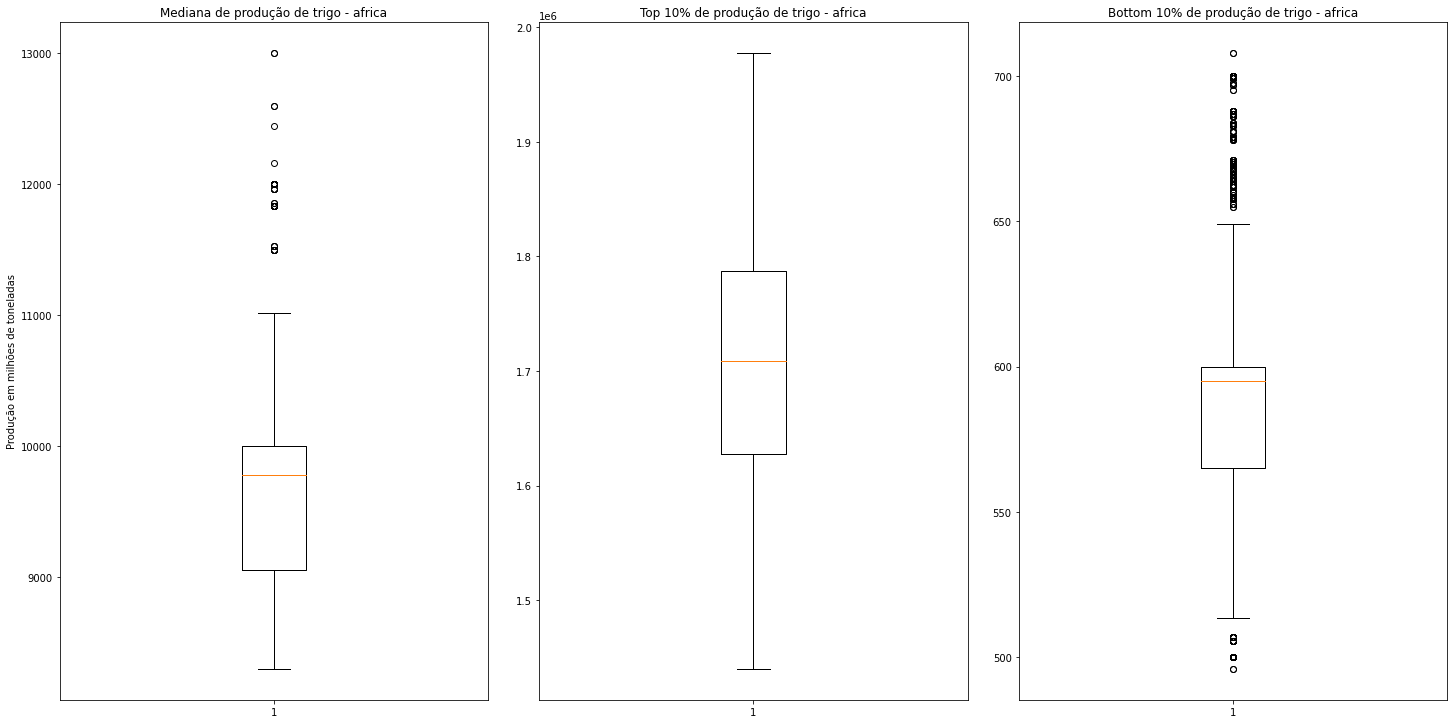

In [ ]:
# Africa
africa_prod = continentes_prod['africa']
values_a, li_a_median, ls_a_median = get_status_continente(africa_prod, 'africa', 'trigo')

#### Asia

Top 10%
('China', 90624570.58002481)
('India', 54209056.78660049)
('Pakistan', 14536408.591811415)
('Kazakhstan', 12479922.59305211)
Bottom 10%
('Oman', 1386.4302109181142)
('Thailand', 879.1786600496278)
('United Arab Emirates', 671.4975186104218)
('Kuwait', 64.91625310173697)
('Qatar', 53.567617866004966)


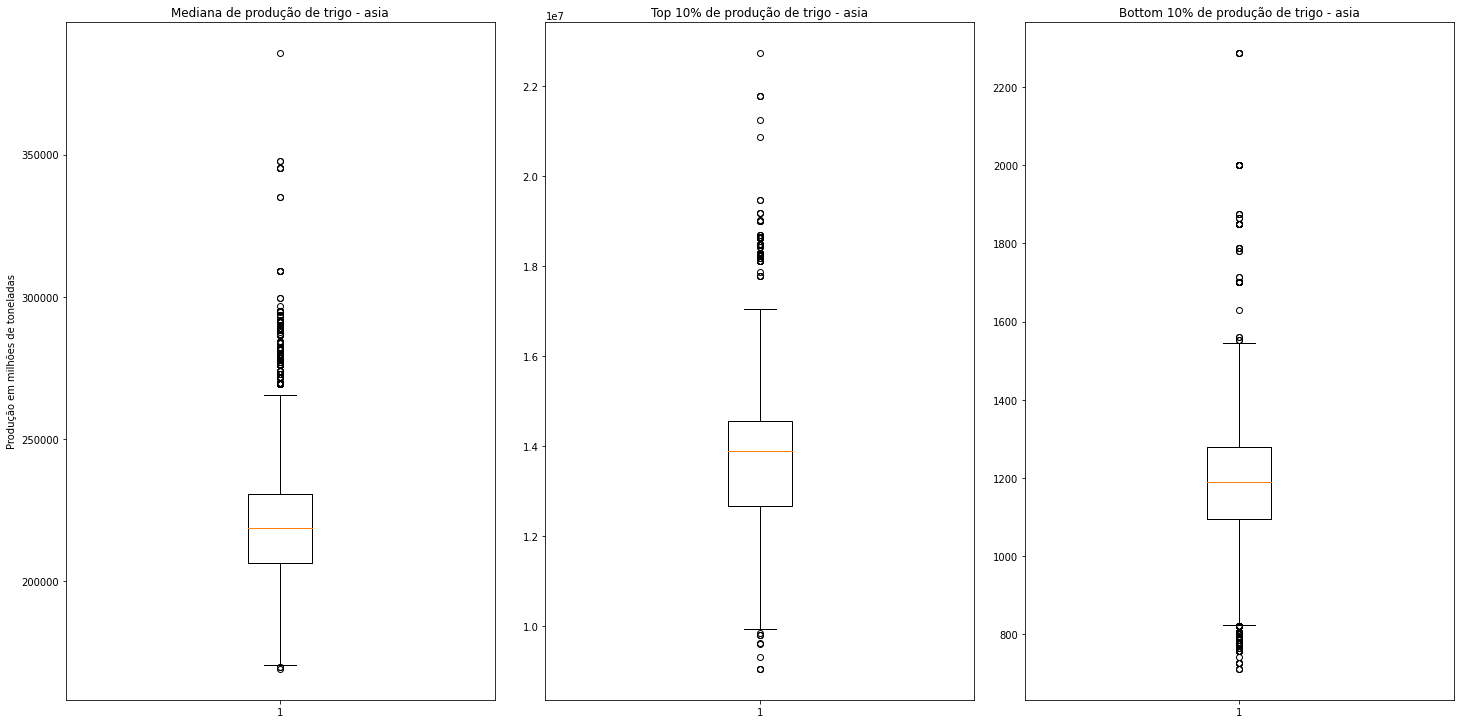

In [ ]:
# Asia
asia_prod = continentes_prod['asia']
values_asi, li_asi_median, ls_asi_median = get_status_continente(asia_prod, 'asia', 'trigo')

#### America

##### Norte

Top 10%
('United States of America', 56570619.04)
Bottom 10%
('Honduras', 802.265)


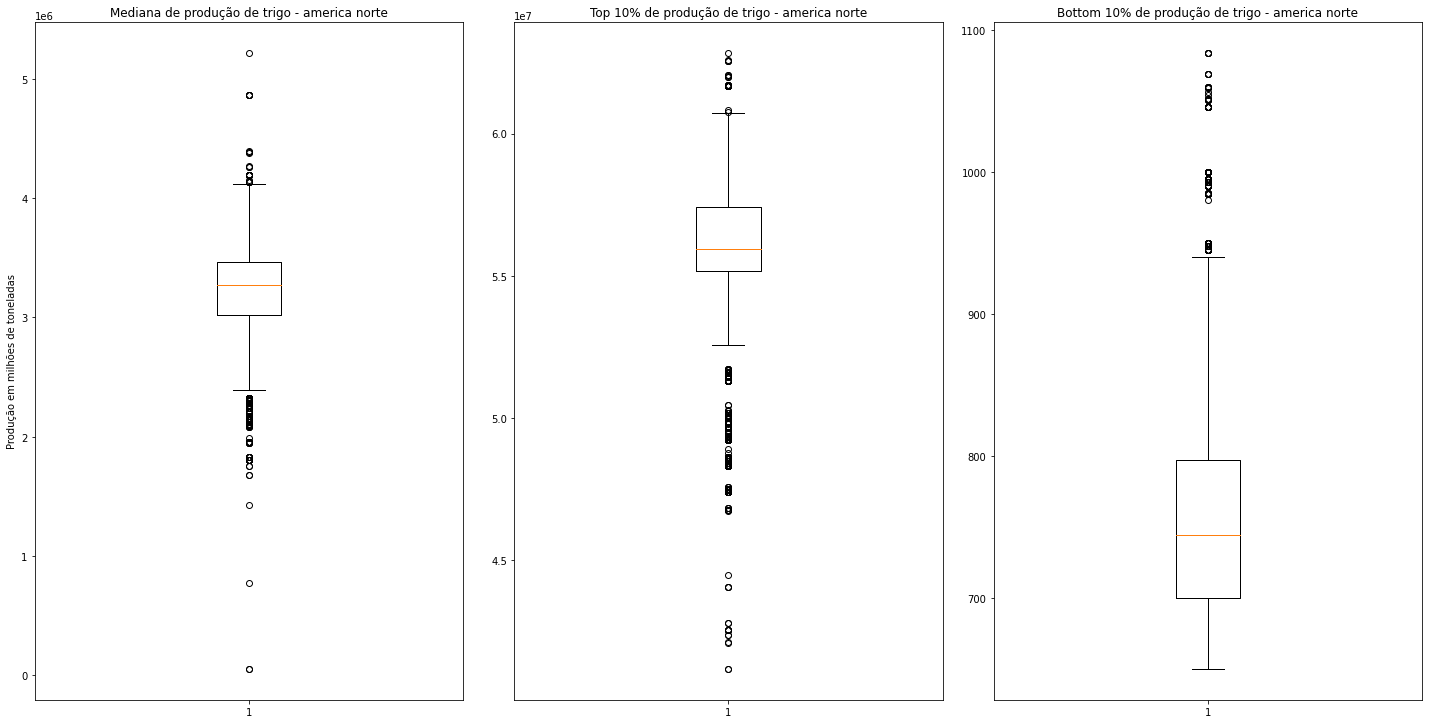

In [ ]:
# America Norte
america_n_prod = continentes_prod['america_n']
values_a_n, li_a_n_median, ls_a_n_median = get_status_continente(america_n_prod, 'america norte', 'trigo')

##### Sul

Top 10%
('Argentina', 9948878.507291667)
Bottom 10%
('Venezuela (Bolivarian Republic of)', 458.6197916666667)


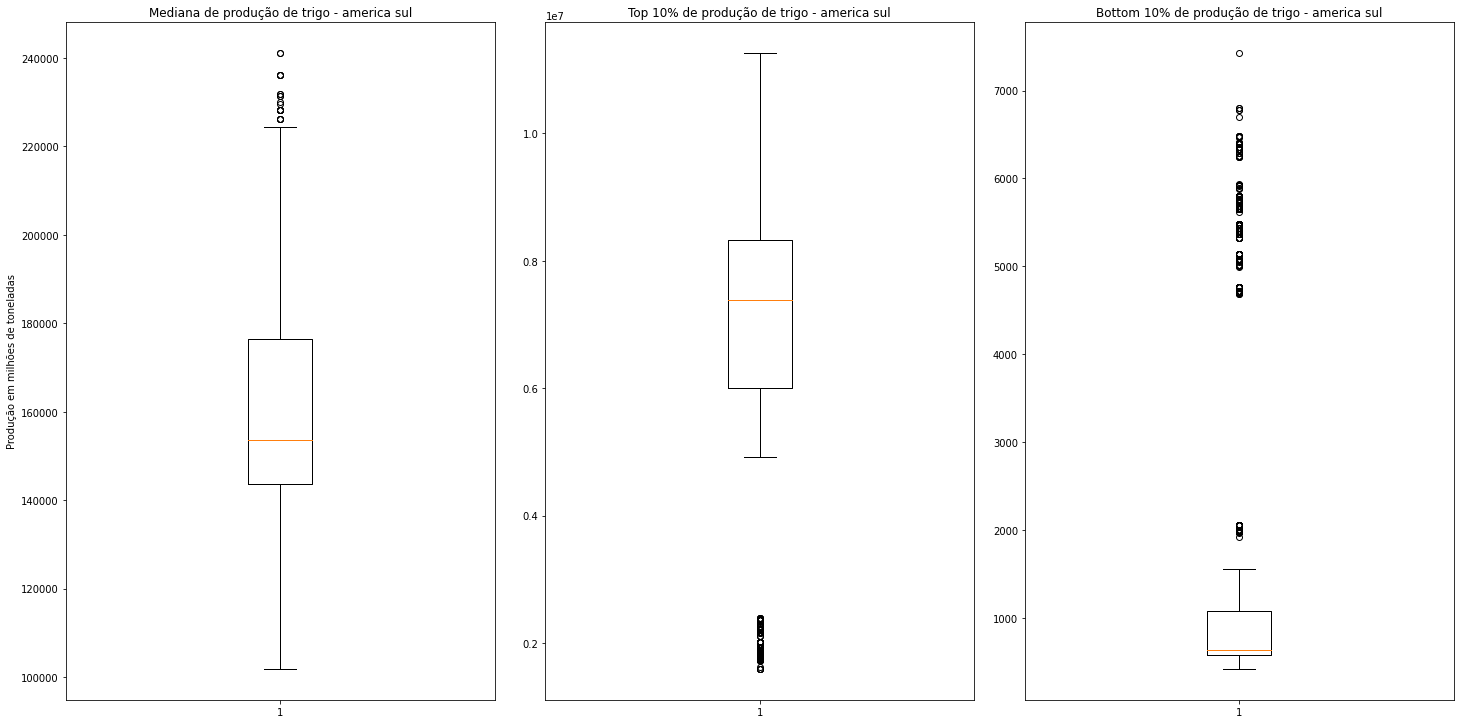

In [ ]:
# America sul
america_s_prod = continentes_prod['america_s']
values_a_s, li_a_s_median, ls_a_s_median = get_status_continente(america_s_prod, 'america sul', 'trigo')

#### Europa

Top 10%
('France', 30242251.791091952)
('Ukraine', 19526078.07816092)
('Turkey', 18017955.177011494)
('Germany', 15562658.955172414)
Bottom 10%
('Luxembourg', 77755.49310344827)
('Cyprus', 13381.763218390804)
('Malta', 4989.576149425287)
('Montenegro', 2159.0)


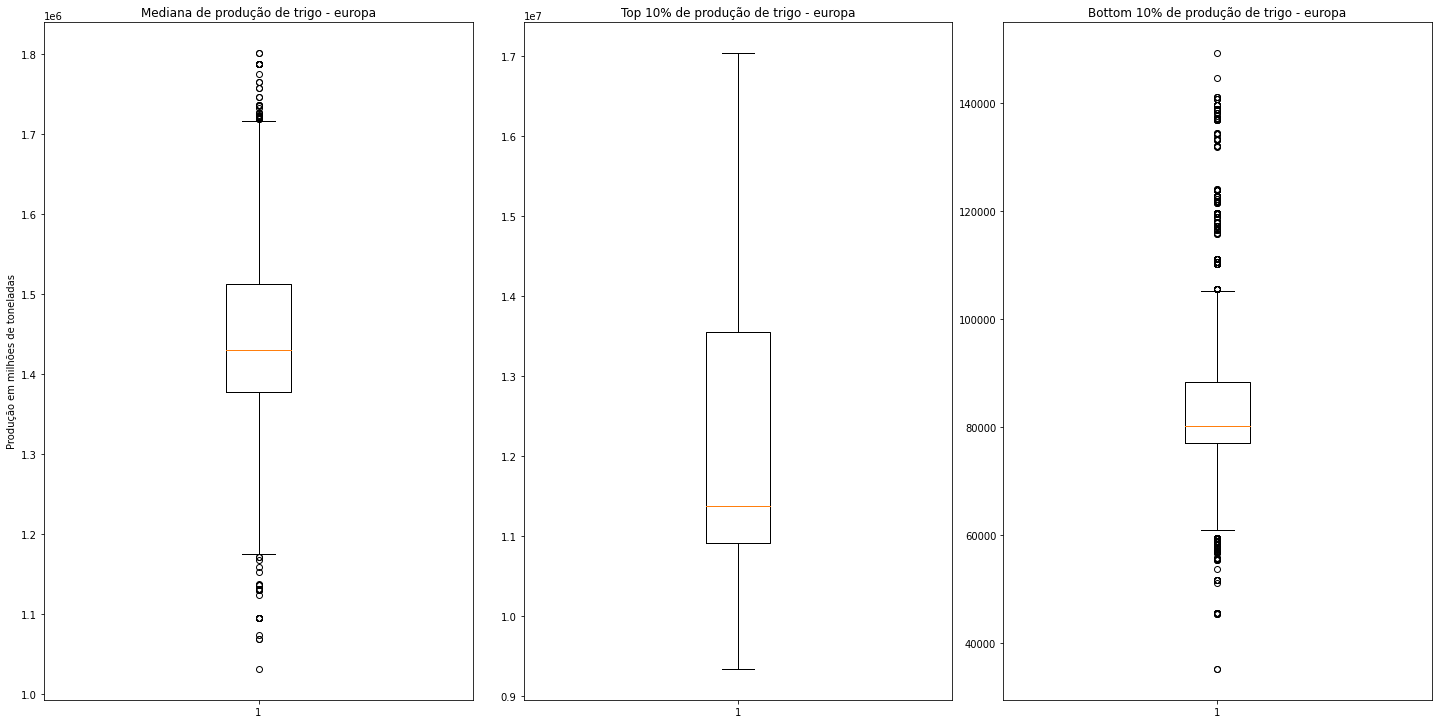

In [ ]:
# Europa
europa_prod = continentes_prod['europa']
values_eu, li_eu_median, ls_eu_median = get_status_continente(europa_prod, 'europa', 'trigo')

#### Oceania

Top 10%
Bottom 10%


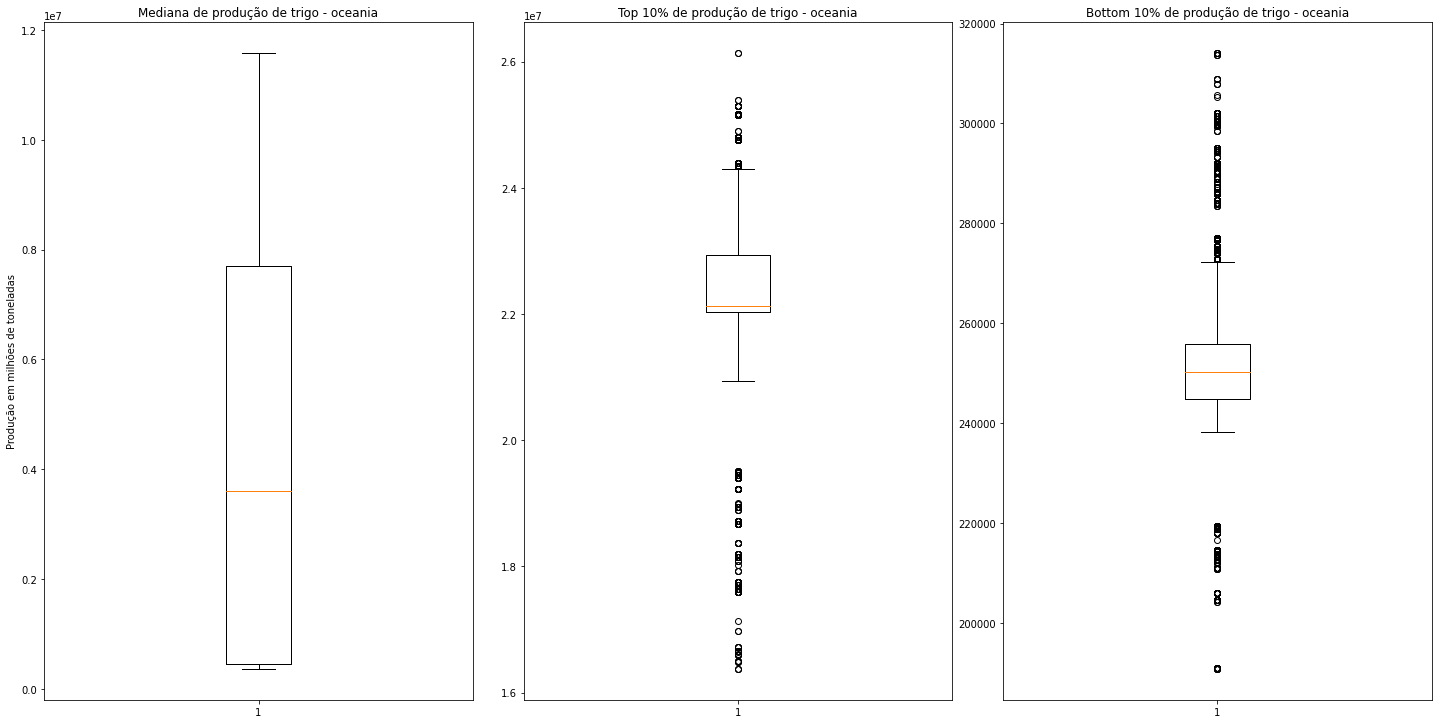

In [ ]:
# Oceania
oceania_prod = continentes_prod['oceania']
values_oc, li_oc_median, ls_oc_median = get_status_continente(oceania_prod, 'oceania', 'trigo')

###Comparação

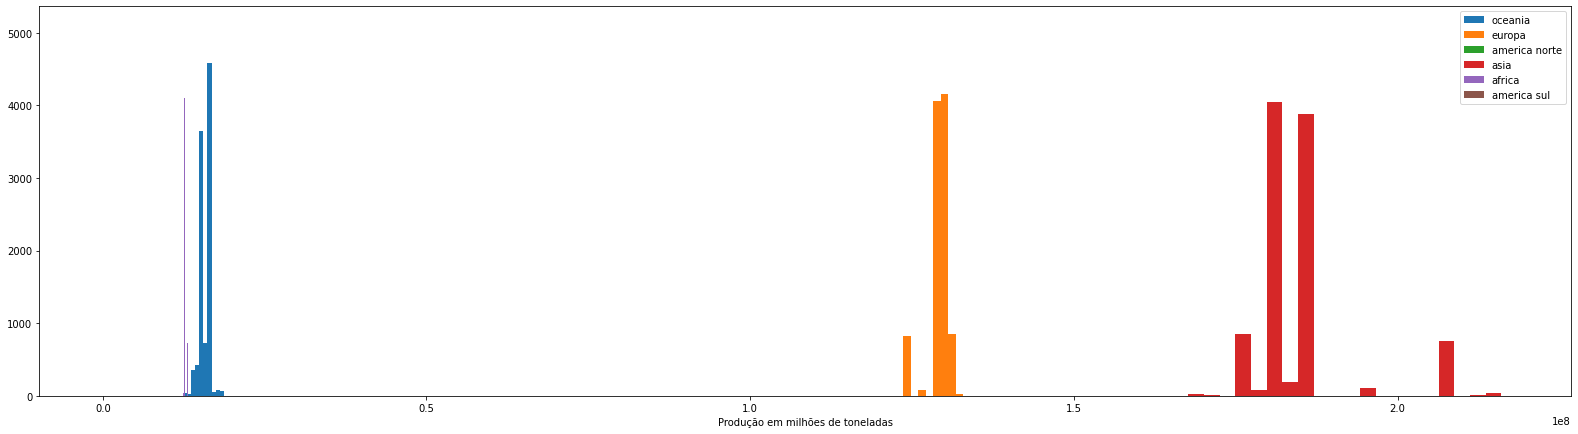

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()

axs.hist(values_oc, label='oceania')
axs.hist(values_eu, label='europa')
axs.hist(values_an, label='america norte')
axs.hist(values_asi, bins=20, label='asia')
axs.hist(values_a, label='africa')
axs.hist(values_as, label='america sul')

axs.set_xlabel('Produção em milhões de toneladas')
axs.legend()
plt.show()

É perceptível que a Ásia tem a maior produção de trigo esperada. Como a Ásia se posiciona como primeira colocada basta verificar se a tendência observada no Brasil se repete nela. 

0.9835332211890334


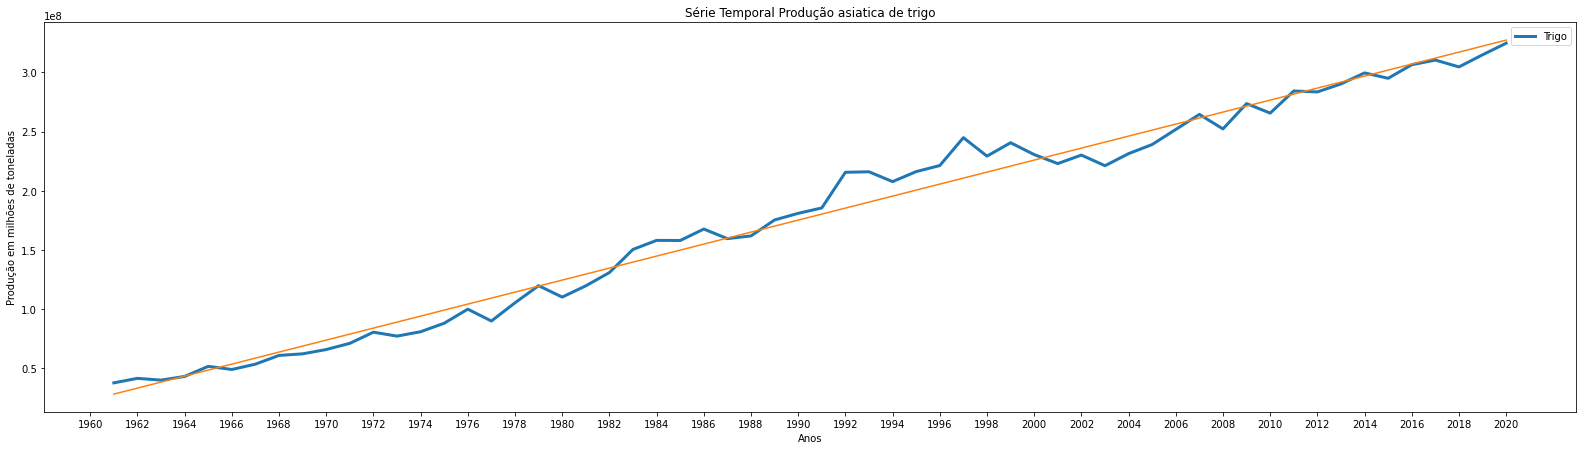

In [ ]:
trigo_a = continentes_prod['asia'].groupby('Year').sum()
trigo_a = trigo_a.reset_index()
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(trigo_a['Year'], trigo_a['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produção asiatica de trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em milhões de toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
reg = LinearRegression().fit(np.array(trigo_a['Year']).reshape(-1, 1), trigo_a['Value'])
print(reg.score(np.array(trigo_a['Year']).reshape(-1, 1), trigo_a['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

É perceptível um constante crescimento ao longo dos anos na produção de trigo da Ásia. Tal qual no Brasil.

### Produtividade

In [ ]:
produtividade = []
for country in prod_trigo['Area'].unique():
  for year in prod_trigo['Year'].unique():
    v = prod_trigo[(prod_trigo['Year'] == year) & (prod_trigo['Area'] == country)]
    a = area_trigo[(area_trigo['Year'] == year) & (area_trigo['Area'] == country)]
    if (len(v) > 0) and (len(a) > 0):
      if v.isna().iloc[0]['Value']:
        continue
      elif a.isna().iloc[0]['Value']:
        continue
      else:
        v = v.iloc[0]['Value']
        a = a.iloc[0]['Value']
        if a > 0:
          produtividade.append([year, country, (v/a)])

In [ ]:
df_prod = pd.DataFrame(produtividade, columns=['Year', 'Area', 'Value'])

#### Continentes

In [ ]:
continentes_produtiv = get_continentes(df_prod)

##### Africa

Top 10%
('Egypt', 4.973681201185705)
('Zambia', 4.767585568587387)
('Namibia', 3.8764667486795674)
('Zimbabwe', 3.7735160946795756)
Bottom 10%
('Somalia', 0.37419782709098415)


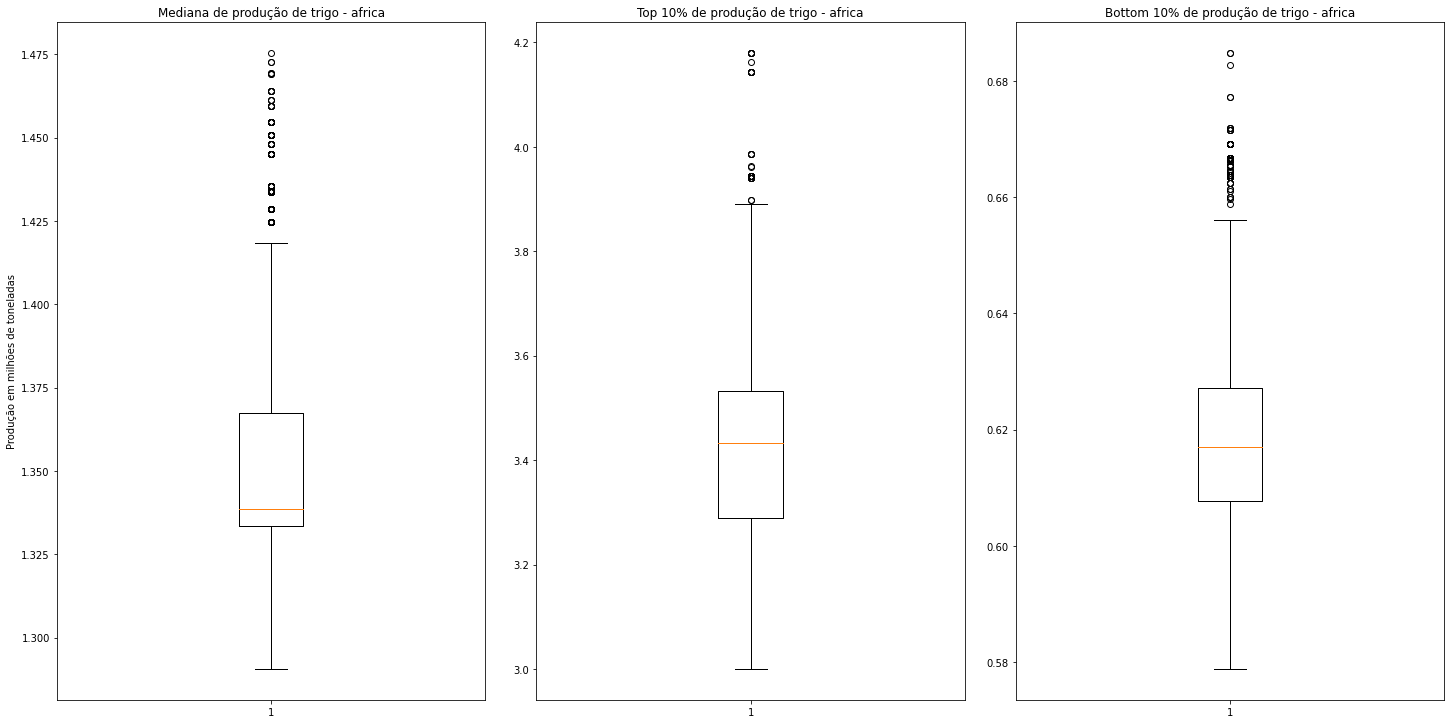

In [ ]:
# Africa
africa_produtiv = continentes_produtiv['africa']
values_a_p, li_a_p_median, ls_a_p_median = get_status_continente(africa_produtiv, 'africa', 'trigo', False)
africa_prod = continentes_prod['africa'].groupby('Year').sum()
africa_area = continentes_area['africa'].groupby('Year').sum()

0.9406545666698468


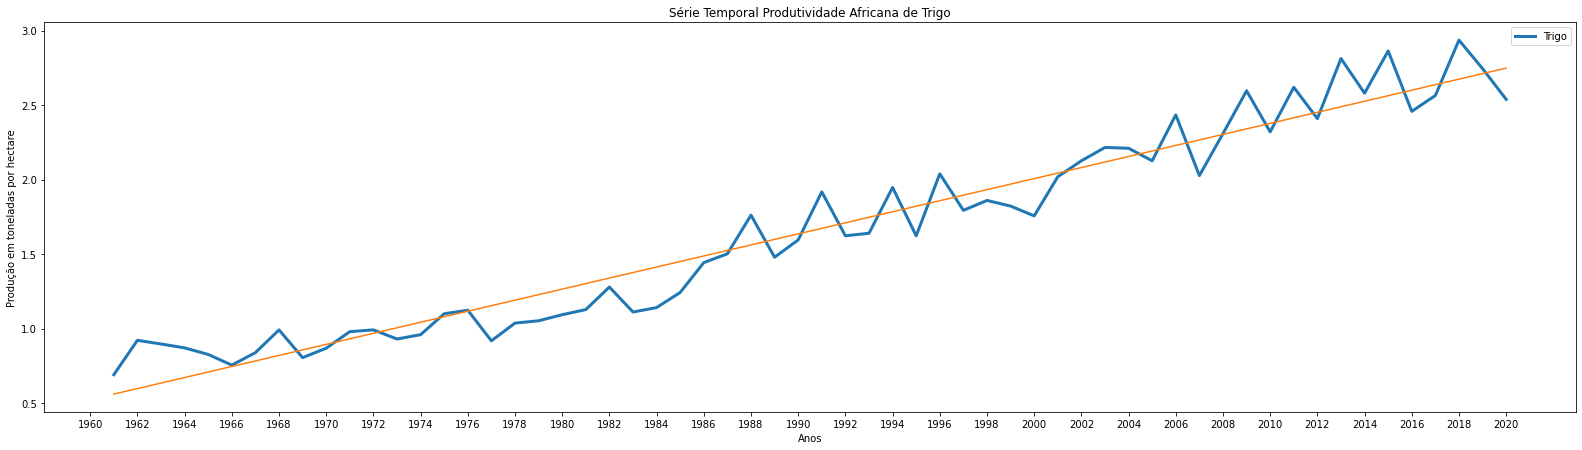

In [ ]:
africa_c_produtiv = (africa_prod / africa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(africa_c_produtiv['Year'], africa_c_produtiv['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Africana de Trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
trigo_a_reg = LinearRegression().fit(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value'])
print(trigo_a_reg.score(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = trigo_a_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Asia

Top 10%
('Saudi Arabia', 4.412745407598711)
('Uzbekistan', 4.200237682641228)
('Japan', 3.4445458225416963)
Bottom 10%
('Thailand', 0.7762952545646284)


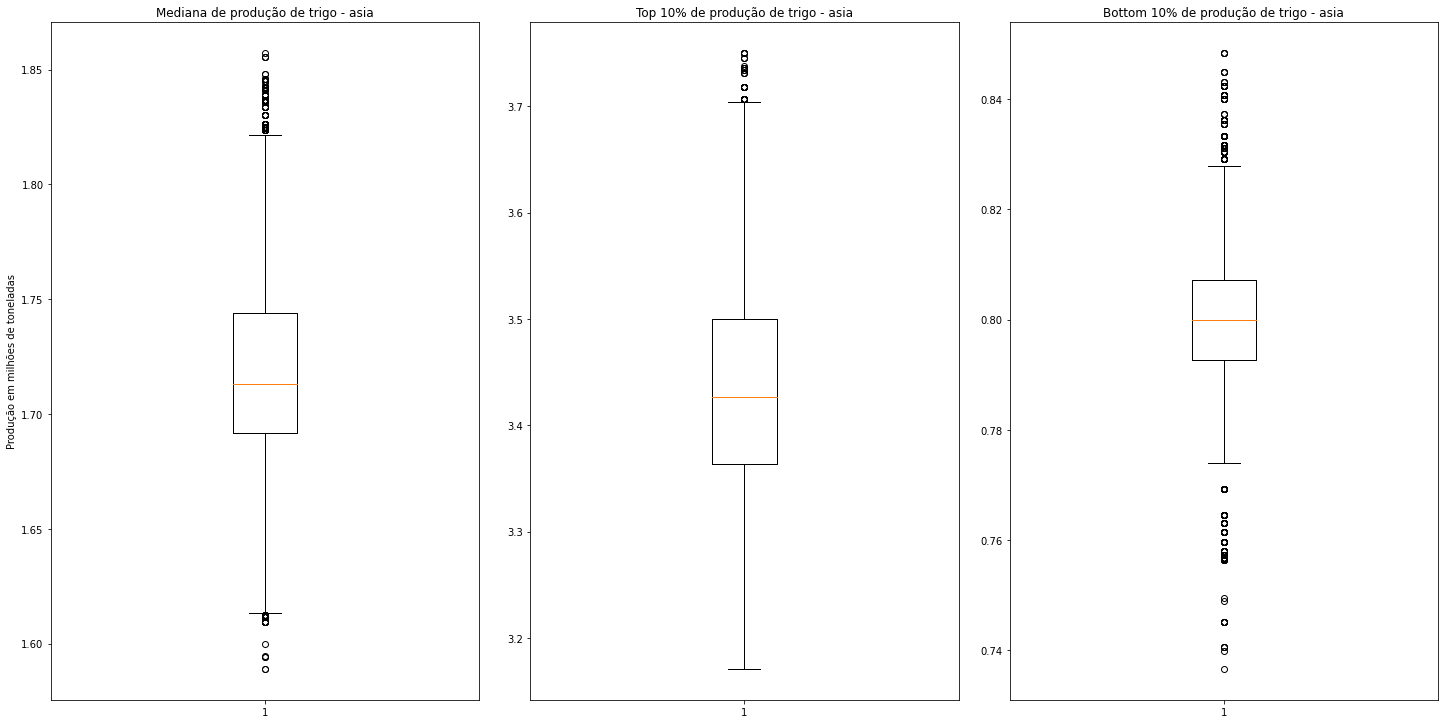

In [ ]:
# Asia
asia_produtiv = continentes_produtiv['asia']
values_asi_p, li_asi_p_median, ls_asi_p_median = get_status_continente(asia_produtiv, 'asia', 'trigo', False)
asia_prod = continentes_prod['asia'].groupby('Year').sum()
asia_area = continentes_area['asia'].groupby('Year').sum()

0.9732481447883347


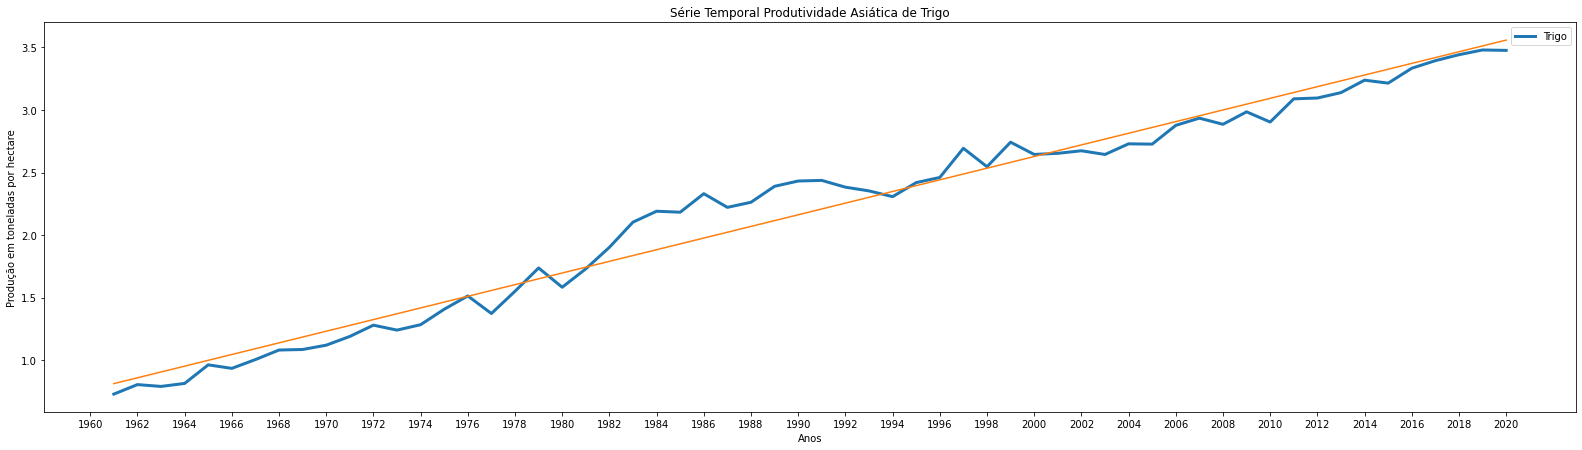

In [ ]:
asia_c_produtiv = (asia_prod / asia_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(asia_c_produtiv['Year'], asia_c_produtiv['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Asiática de Trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
trigo_asi_reg = LinearRegression().fit(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value'])
print(trigo_asi_reg.score(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = trigo_asi_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### America


###### Norte

Top 10%
('Mexico', 4.175900325837141)
Bottom 10%
('Honduras', 0.5910882259124521)


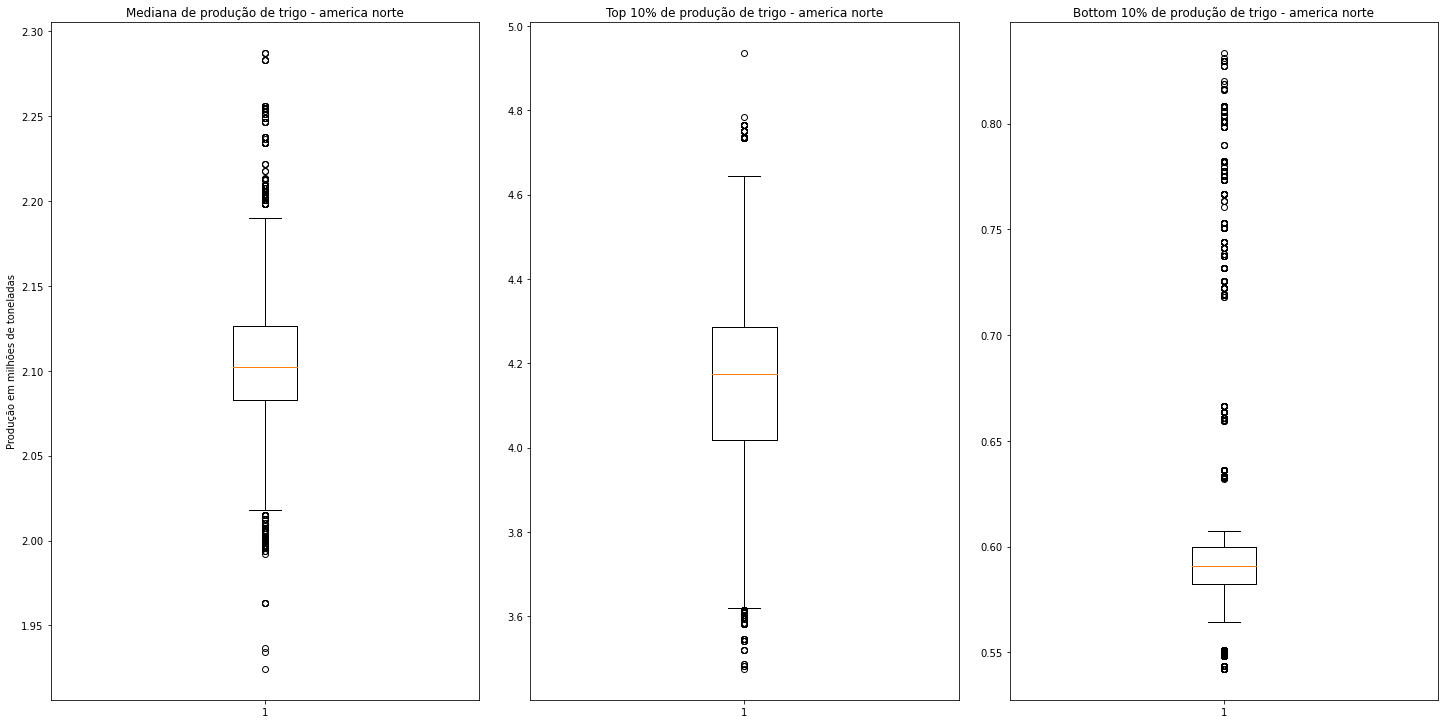

In [ ]:
# America Norte
america_n_produtiv = continentes_produtiv['america_n']
values_a_n_p, li_a_n_p_median, ls_a_n_p_median = get_status_continente(america_n_produtiv, 'america norte', 'trigo', False)
america_n_prod = continentes_prod['america_n'].groupby('Year').sum()
america_n_area = continentes_area['america_n'].groupby('Year').sum()

0.9005118033068652


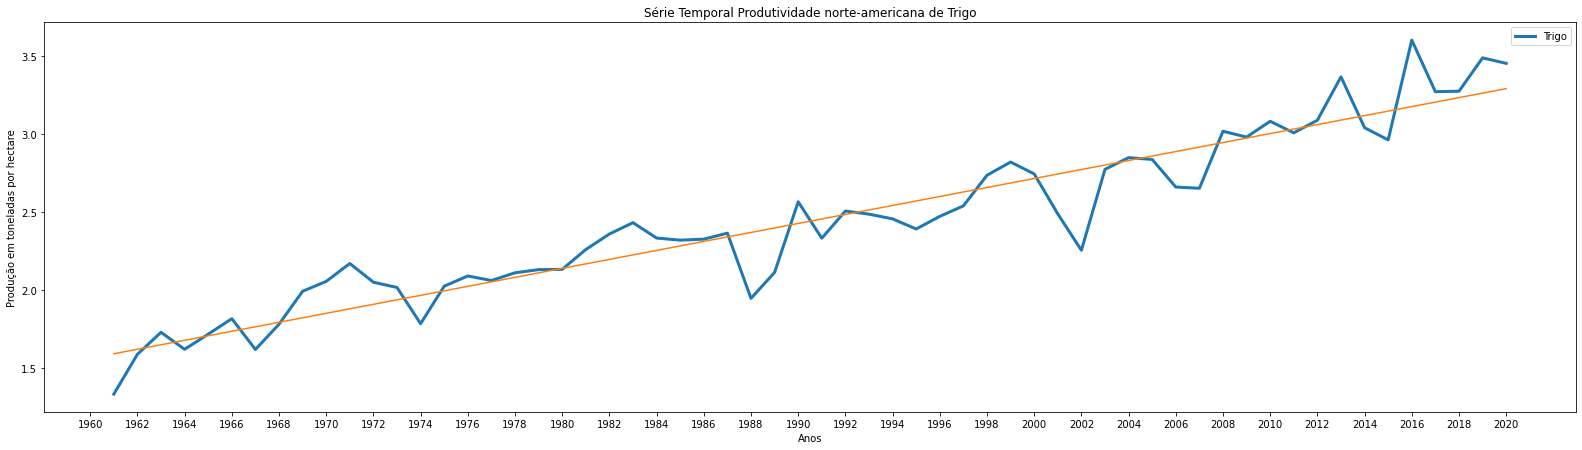

In [ ]:
america_n_c_produtiv = (america_n_prod / america_n_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_n_c_produtiv['Year'], america_n_c_produtiv['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade norte-americana de Trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
trigo_a_n_reg = LinearRegression().fit(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value'])
print(trigo_a_n_reg.score(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = trigo_a_n_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

###### Sul

Top 10%
('Chile', 3.2173900831897537)
Bottom 10%
('Venezuela (Bolivarian Republic of)', 0.5145012242966013)


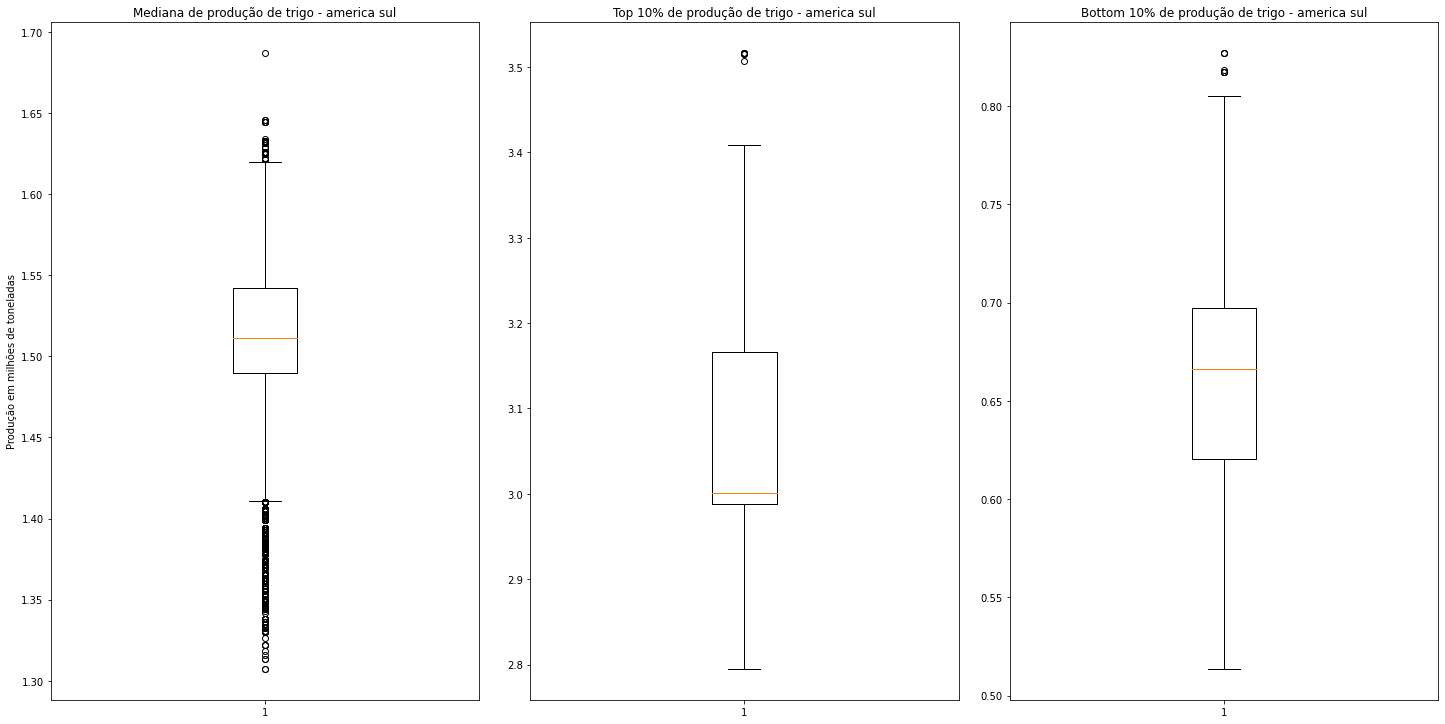

In [ ]:
# America sul
america_s_produtiv = continentes_produtiv['america_s']
values_a_s_p, li_a_s_p_median, ls_a_s_p_median = get_status_continente(america_s_produtiv, 'america sul', 'trigo', False)
america_s_prod = continentes_prod['america_s'].groupby('Year').sum()
america_s_area = continentes_area['america_s'].groupby('Year').sum()

0.8842015562579201


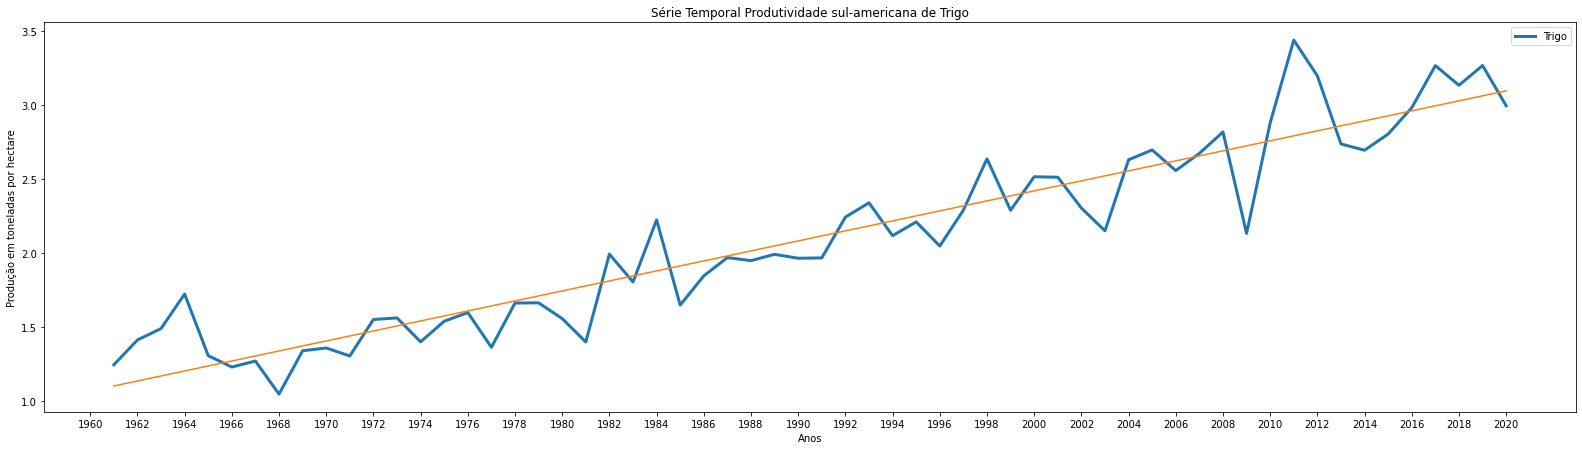

In [ ]:
america_s_c_produtiv = (america_s_prod / america_s_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_s_c_produtiv['Year'], america_s_c_produtiv['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade sul-americana de Trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
trigo_a_s_reg = LinearRegression().fit(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value'])
print(trigo_a_s_reg.score(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = trigo_a_s_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Europa

Top 10%
('Belgium', 8.577606957013634)
('Ireland', 7.708892306343042)
('Netherlands', 7.680832562450429)
('Denmark', 6.59311629384268)
Bottom 10%
('Cyprus', 1.4928616653184739)
('Portugal', 1.3422649114822338)


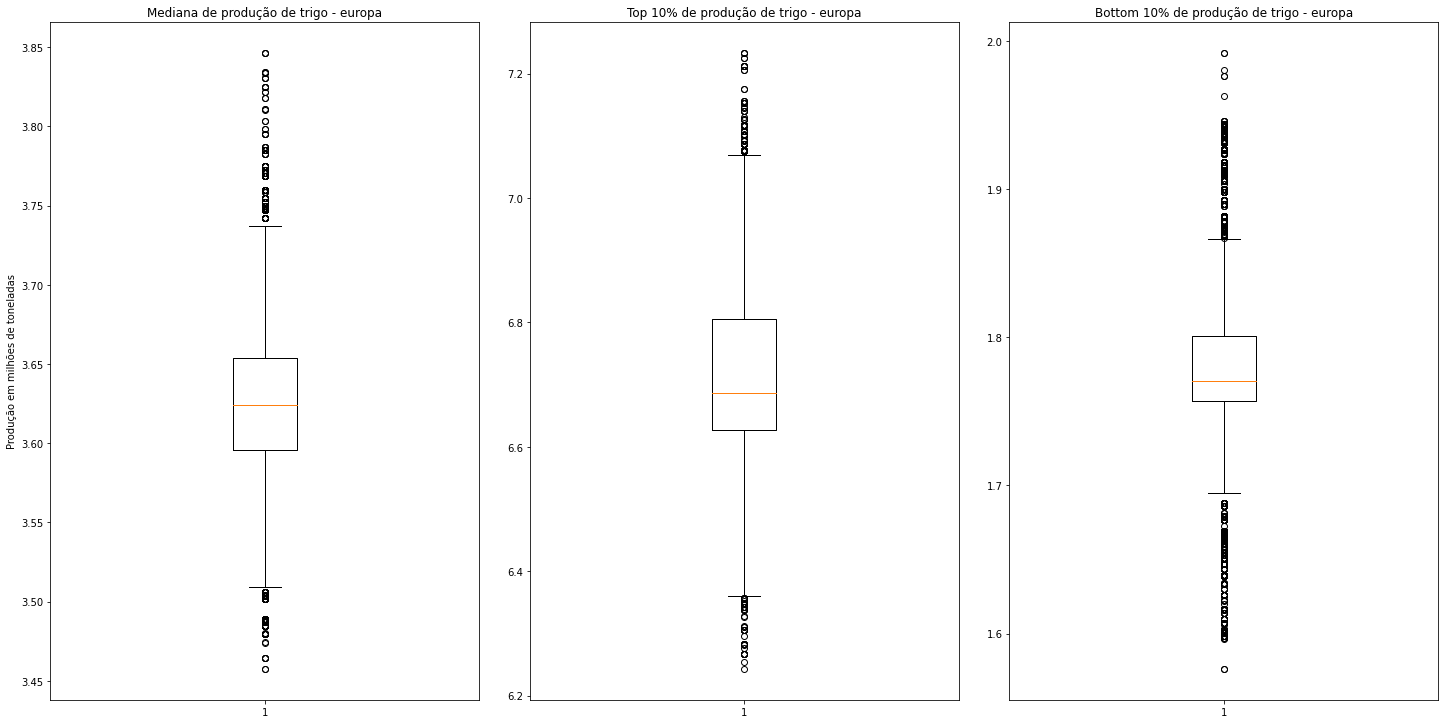

In [ ]:
# Europa
europa_produtiv = continentes_produtiv['europa']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(europa_produtiv, 'europa', 'trigo', False)
europa_prod = continentes_prod['europa'].groupby('Year').sum()
europa_area = continentes_area['europa'].groupby('Year').sum()

0.9273262721362798


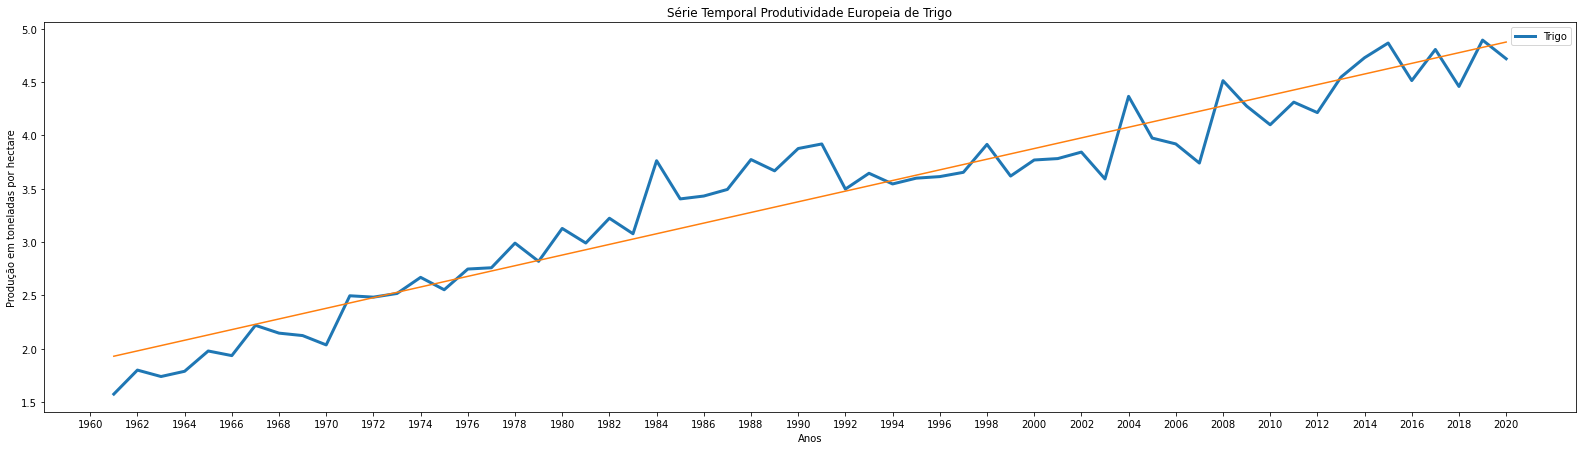

In [ ]:
europa_c_produtiv = (europa_prod / europa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(europa_c_produtiv['Year'], europa_c_produtiv['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Europeia de Trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
trigo_eu_reg = LinearRegression().fit(np.array(europa_c_produtiv['Year']).reshape(-1, 1), europa_c_produtiv['Value'])
print(trigo_eu_reg.score(np.array(europa_c_produtiv['Year']).reshape(-1, 1), europa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = trigo_eu_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Oceania

Top 10%
Bottom 10%


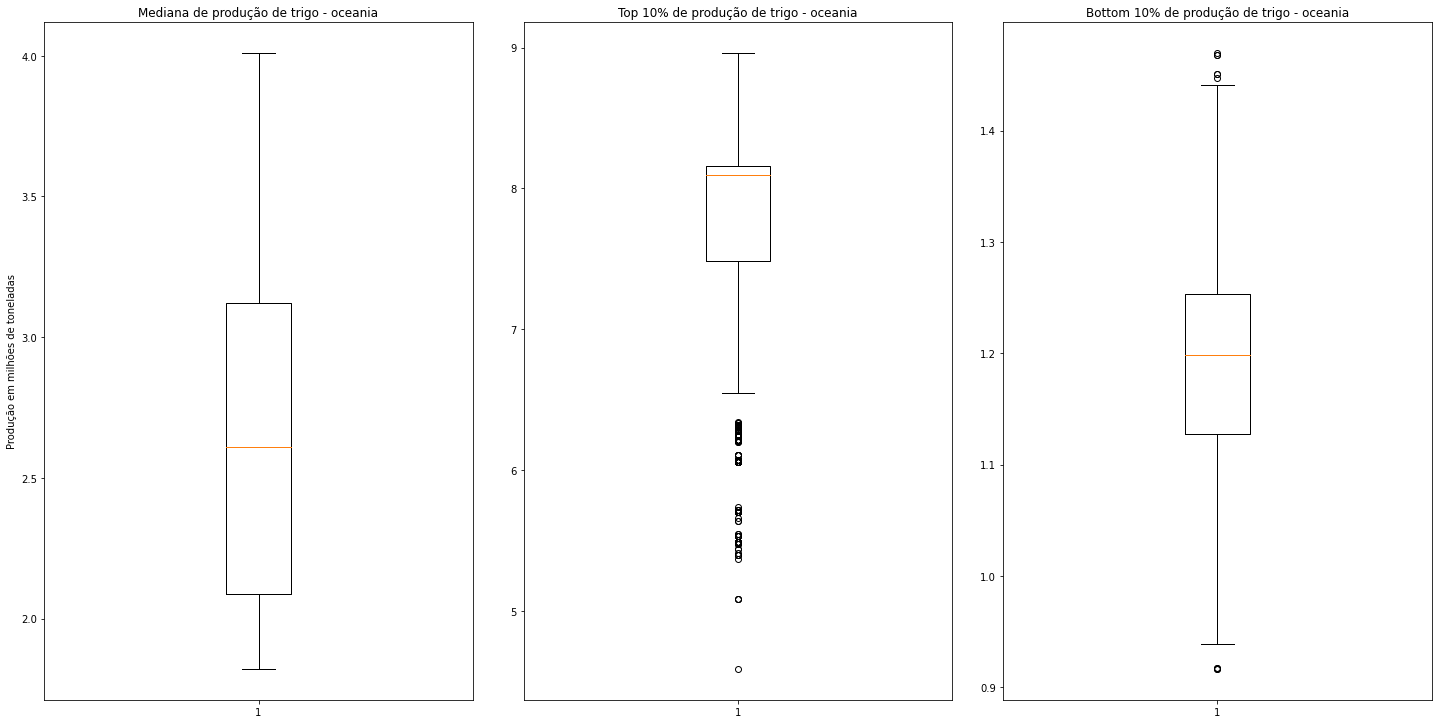

In [ ]:
# Oceania
oceania_produtiv = continentes_produtiv['oceania']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(oceania_produtiv, 'oceania', 'trigo', False)
oceania_prod = continentes_prod['oceania'].groupby('Year').sum()
oceania_area = continentes_area['oceania'].groupby('Year').sum()

0.3720473417674415


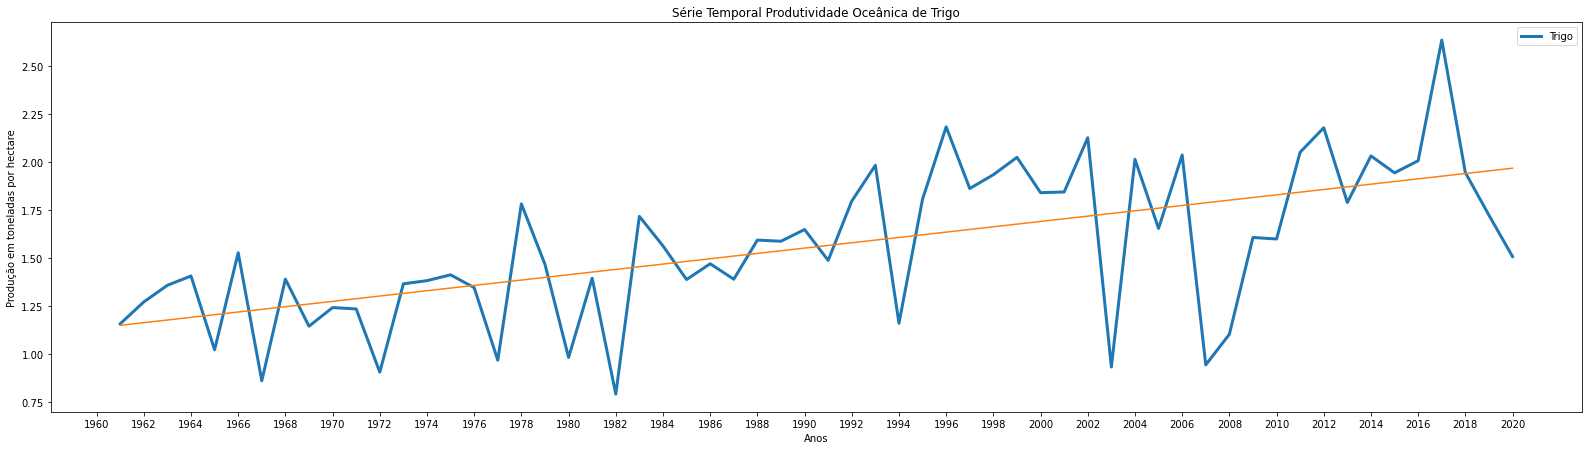

In [ ]:
oceania_c_produtiv = (oceania_prod / oceania_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(oceania_c_produtiv['Year'], oceania_c_produtiv['Value'], label='Trigo', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Oceânica de Trigo')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
trigo_oc_reg = LinearRegression().fit(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value'])
print(trigo_oc_reg.score(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = trigo_oc_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

Podemos concluir então, que para a produção de trigo mundial vemos uma tendência do aumento de produtividade, ou seja, mais toneladas de trigo sendo produzidos por hectare plantado. 

Continente   | LI (ton/ha) | LS (ton/ha)  
---|---|---
Asia |  0.57 | 0.63
Oceania   | 0.55  |   0.65
America sul | 0.48  | 0.56  |
America norte| 0.49  |  0.52 |
Africa | 0.39  |  0.42   


## Milho

In [ ]:
df_milho = producao[producao['Item'] == 'Maize']
area_milho = df_milho[df_milho['Element Code'] == 5312]
prod_milho = df_milho[df_milho['Element Code'] == 5510]
preco_milho['date'] = pd.to_datetime(preco_milho['date'], format='%Y-%m-%d')
preco_milho[' value']=33.3*preco_milho[' value'] #converte bushel para tonelada

Variação dos preços do milho


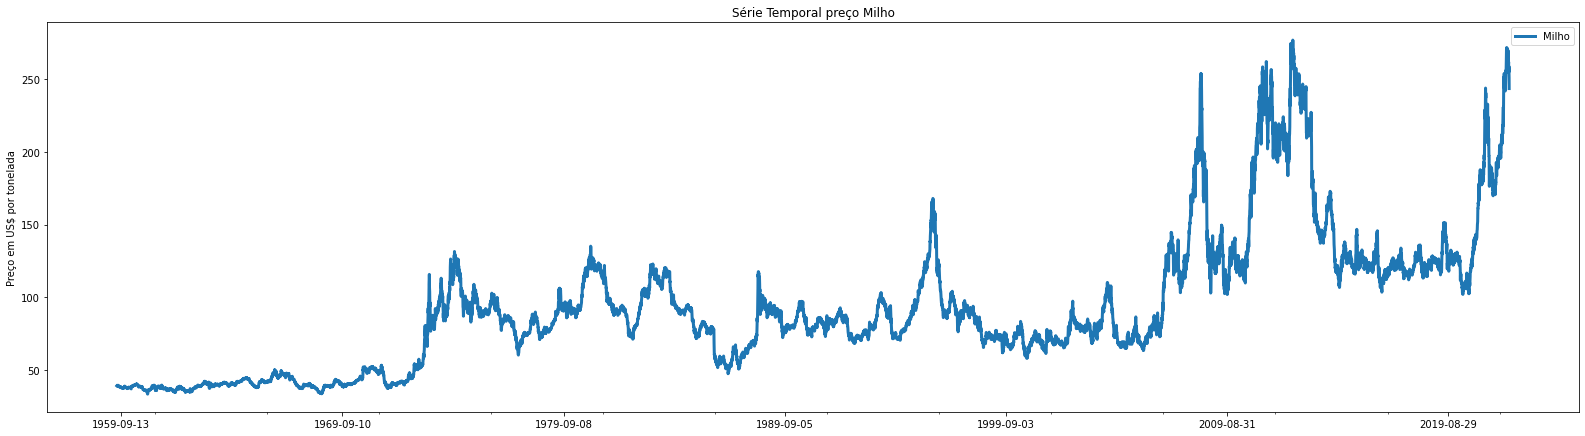

In [ ]:
#Serie temporal variacao de preco
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(preco_milho['date'], preco_milho[' value'], label='Milho', 
         linewidth=3)

axs.set_title('Série Temporal preço Milho')
axs.xaxis.set_major_locator(MultipleLocator(3650))
axs.xaxis.set_minor_locator(MultipleLocator(1850))
axs.set_ylabel('Preço em US$ por tonelada')

axs.legend()
axs.locator_params ('Data', nbins = 10) 

plt.show()

### Mundo

#### Variação da produção mundial

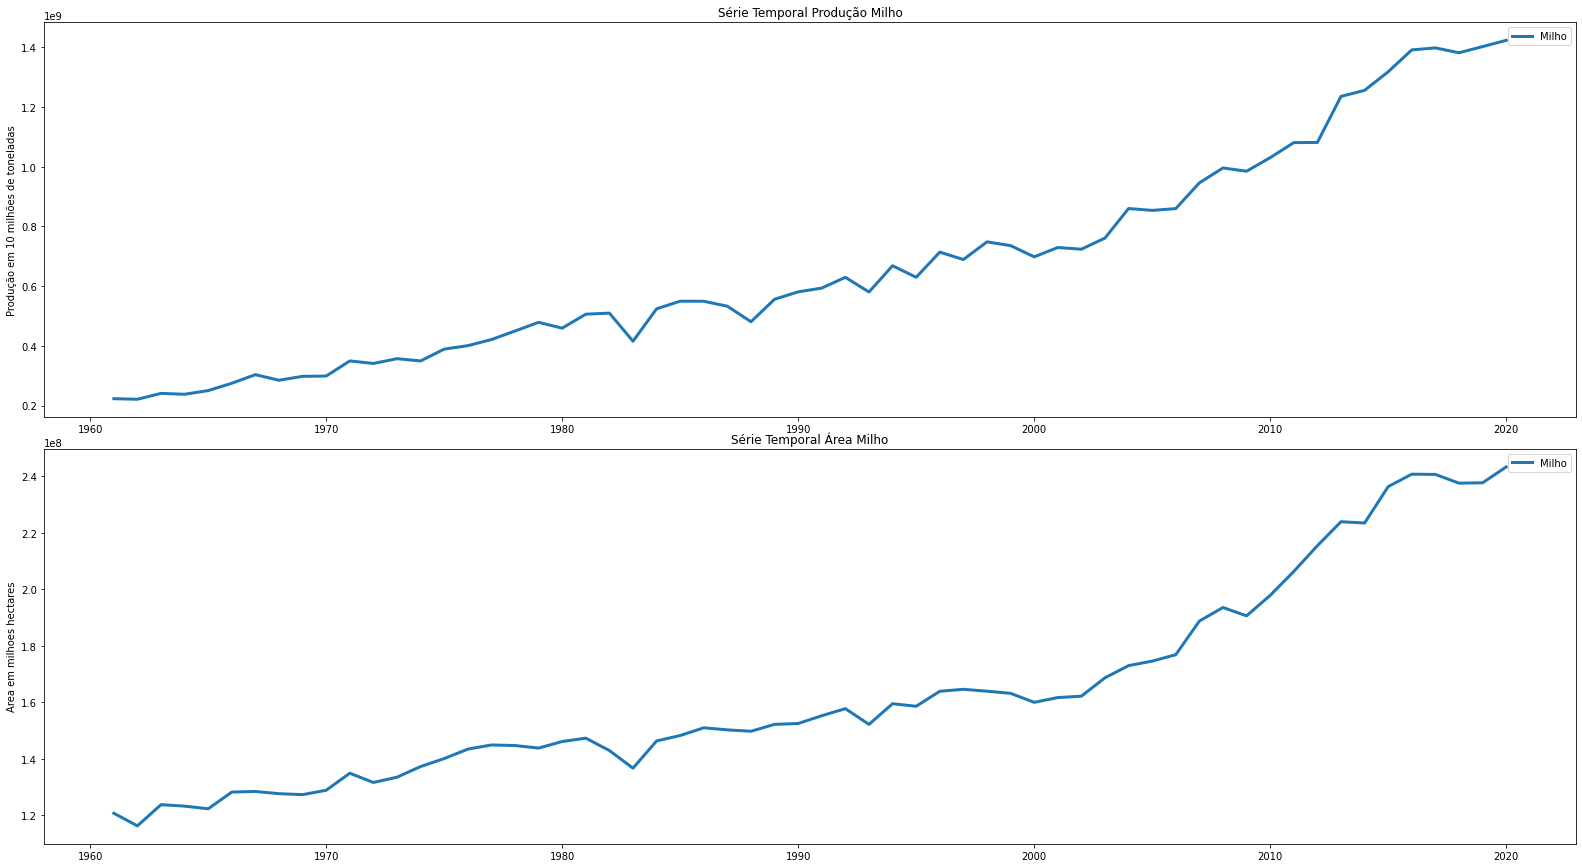

In [ ]:
#Serie temporal variacao da produção
prod_milho_anual = prod_milho[['Year', 'Value']].groupby('Year').sum()
prod_milho_anual = prod_milho_anual.reset_index()
#Serie temporal variacao da area
area_milho_anual = area_milho[['Year', 'Value']].groupby('Year').sum()
area_milho_anual = area_milho_anual.reset_index()
plot_mundo(prod_milho_anual, area_milho_anual, 'Milho')

### Continentes

In [ ]:
continentes_prod = get_continentes(prod_milho)
continentes_area = get_continentes(area_milho)

#### Africa

Top 10%
('South Africa', 9159056.17372577)
('Nigeria', 4944100.861450108)
('Egypt', 4671609.918341708)
('Ethiopia', 4091119.854271357)
('Kenya', 2412055.411342426)
Bottom 10%
('Algeria', 1998.6697774587221)
('Libya', 1279.4129576453697)
('Sao Tome and Principe', 827.2352835606605)
('Mauritius', 473.03553481694183)
('Djibouti', 10.0)


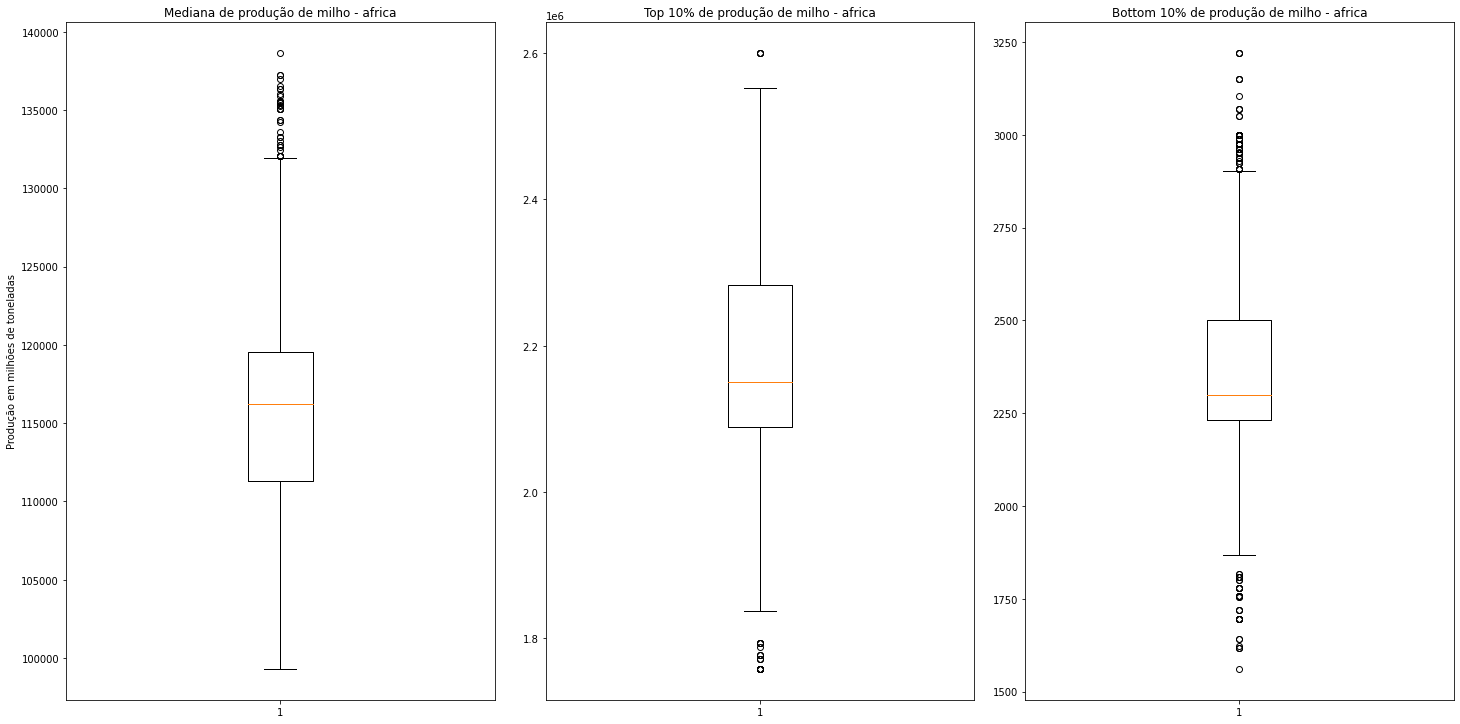

In [ ]:
# Africa
africa_prod = continentes_prod['africa']
values_a, li_a_median, ls_a_median = get_status_continente(africa_prod, 'africa', 'milho')

#### Asia

Top 10%
('China', 95398964.50927784)
('India', 8928794.408224674)
('Indonesia', 6547390.851303912)
Bottom 10%
('Qatar', 926.6188565697091)
('Japan', 781.0832497492478)
('Maldives', 13.508776328986961)


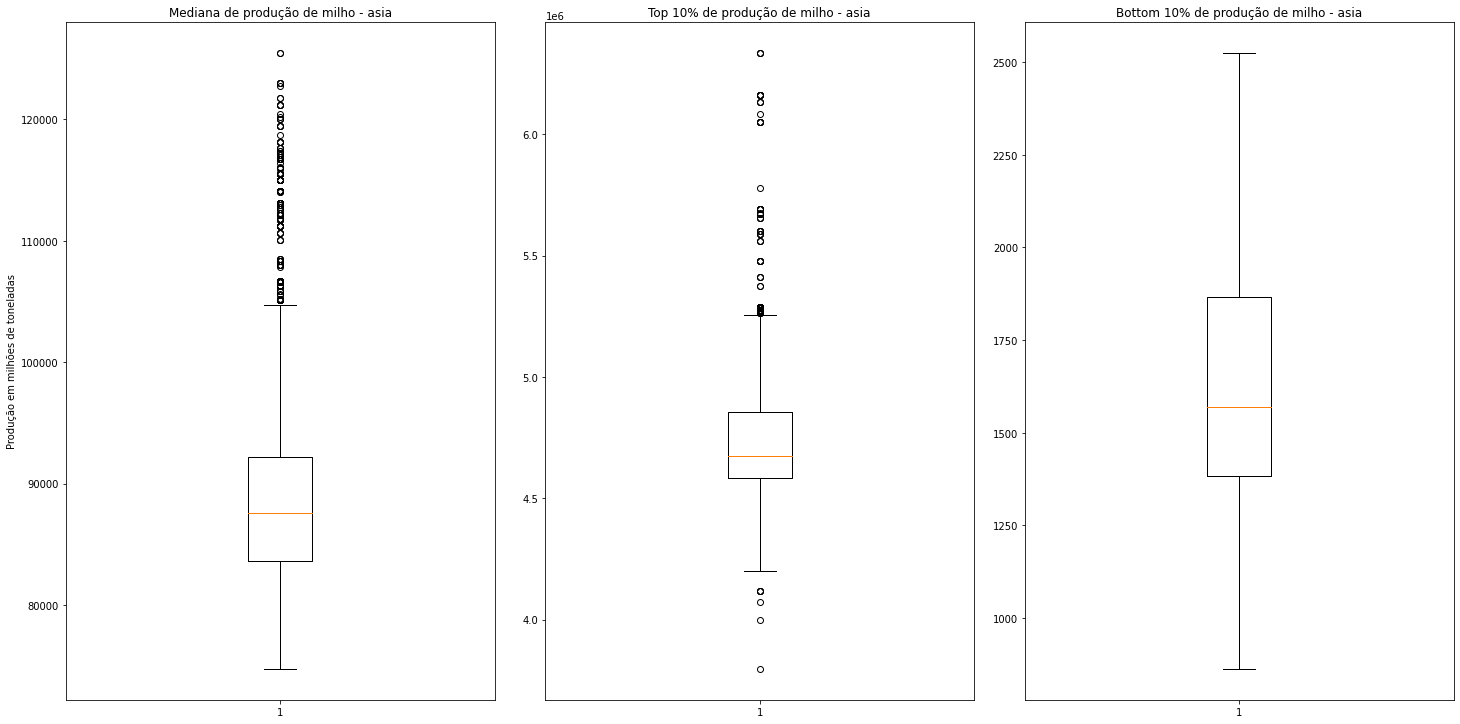

In [ ]:
# Asia
asia_prod = continentes_prod['asia']
values_asi, li_asi_median, ls_asi_median = get_status_continente(asia_prod, 'asia', 'milho')

#### America

##### Norte

Top 10%
('United States of America', 207014841.9764706)
('Mexico', 14714575.394509804)
('Canada', 6944375.529411765)
Bottom 10%
('Dominica', 179.5035294117647)
('Antigua and Barbuda', 51.015686274509804)
('Saint Lucia', 30.0)


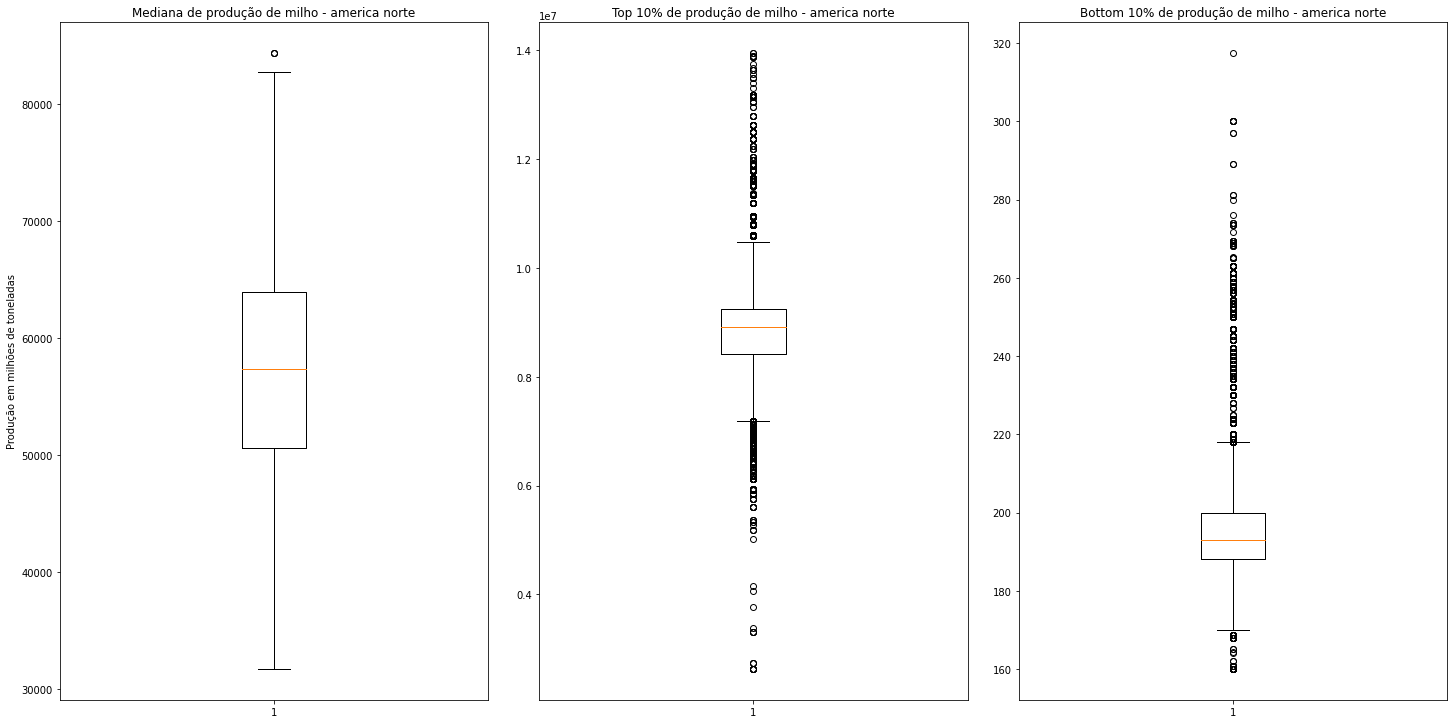

In [ ]:
# America Norte
america_n_prod = continentes_prod['america_n']
values_a_n, li_a_n_median, ls_a_n_median = get_status_continente(america_n_prod, 'america norte', 'milho')

##### Sul

Top 10%
('Argentina', 10593840.895)
Bottom 10%
('Suriname', 189.52833333333334)


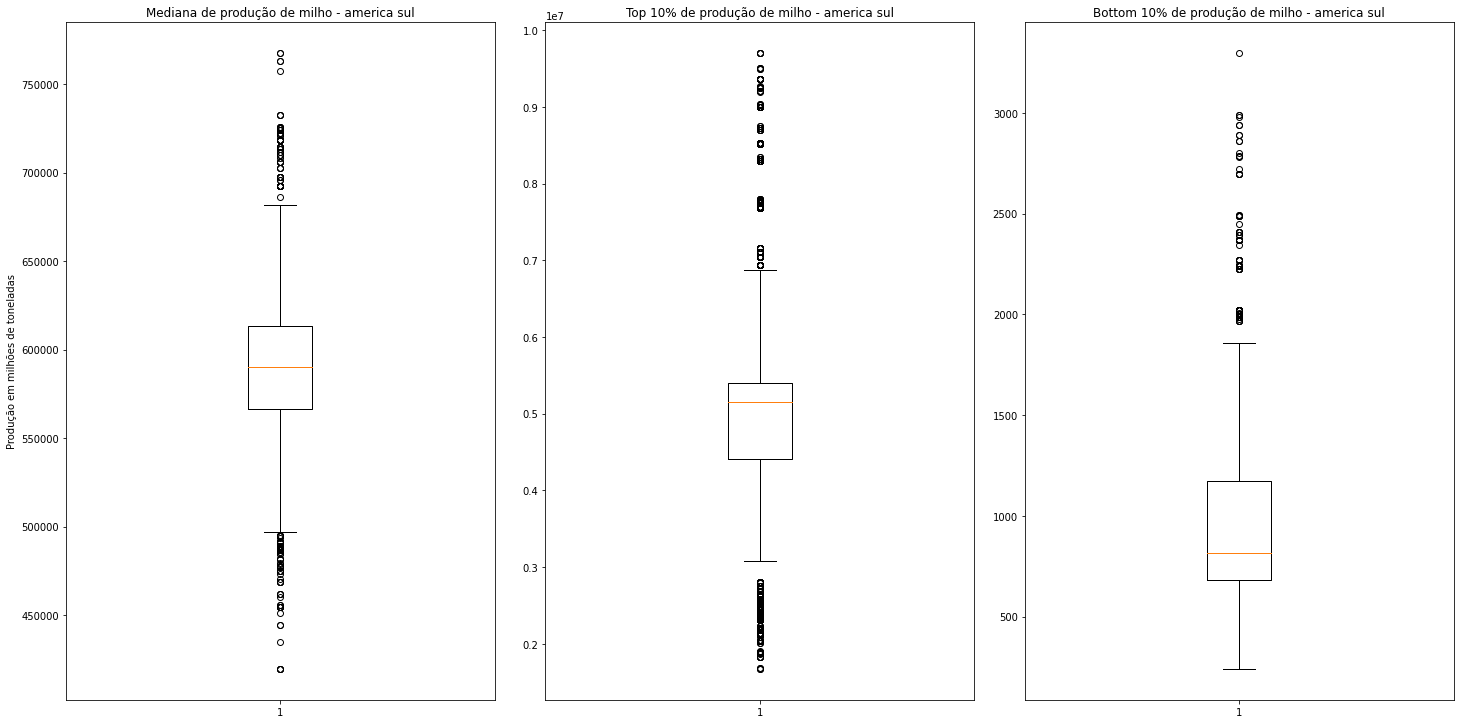

In [ ]:
# America sul
america_s_prod = continentes_prod['america_s']
values_a_s, li_a_s_median, ls_a_s_median = get_status_continente(america_s_prod, 'america sul', 'milho')

#### Europa

Top 10%
('France', 12515331.30357143)
('Romania', 9094433.475155279)
('Yugoslav SFR', 8053421.583850931)
Bottom 10%
('Denmark', 45694.09937888199)
('Netherlands', 43351.63043478261)
('Lithuania', 12425.634316770187)
('Sweden', 11300.0)
('Montenegro', 2687.0236801242236)
('Luxembourg', 2035.9689440993789)
('Estonia', 0.0)
('Ireland', 0.0)
('Latvia', 0.0)
('Malta', 0.0)


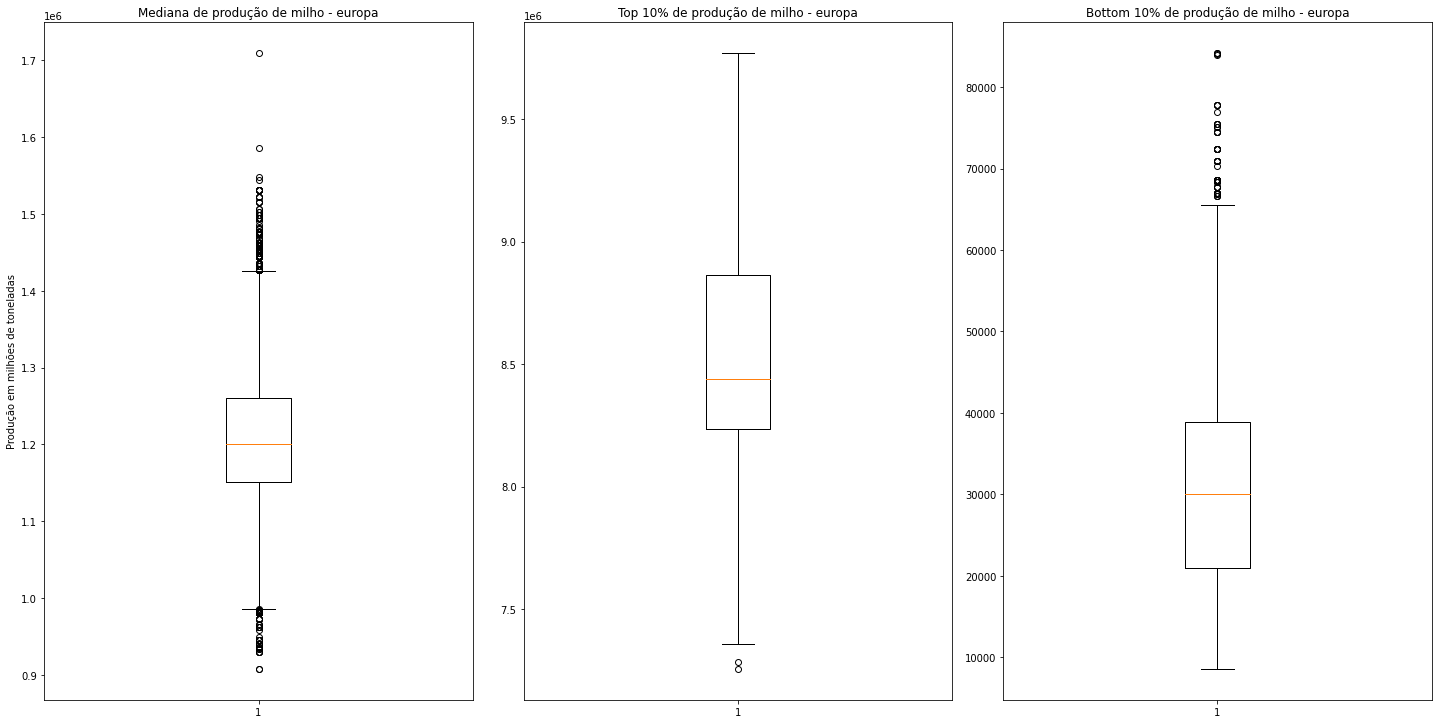

In [ ]:
# Europa
europa_prod = continentes_prod['europa']
values_eu, li_eu_median, ls_eu_median = get_status_continente(europa_prod, 'europa', 'milho')

#### Oceania

Top 10%
('Australia', 228000.1792763158)
Bottom 10%
('Nauru', 0.43914473684210525)


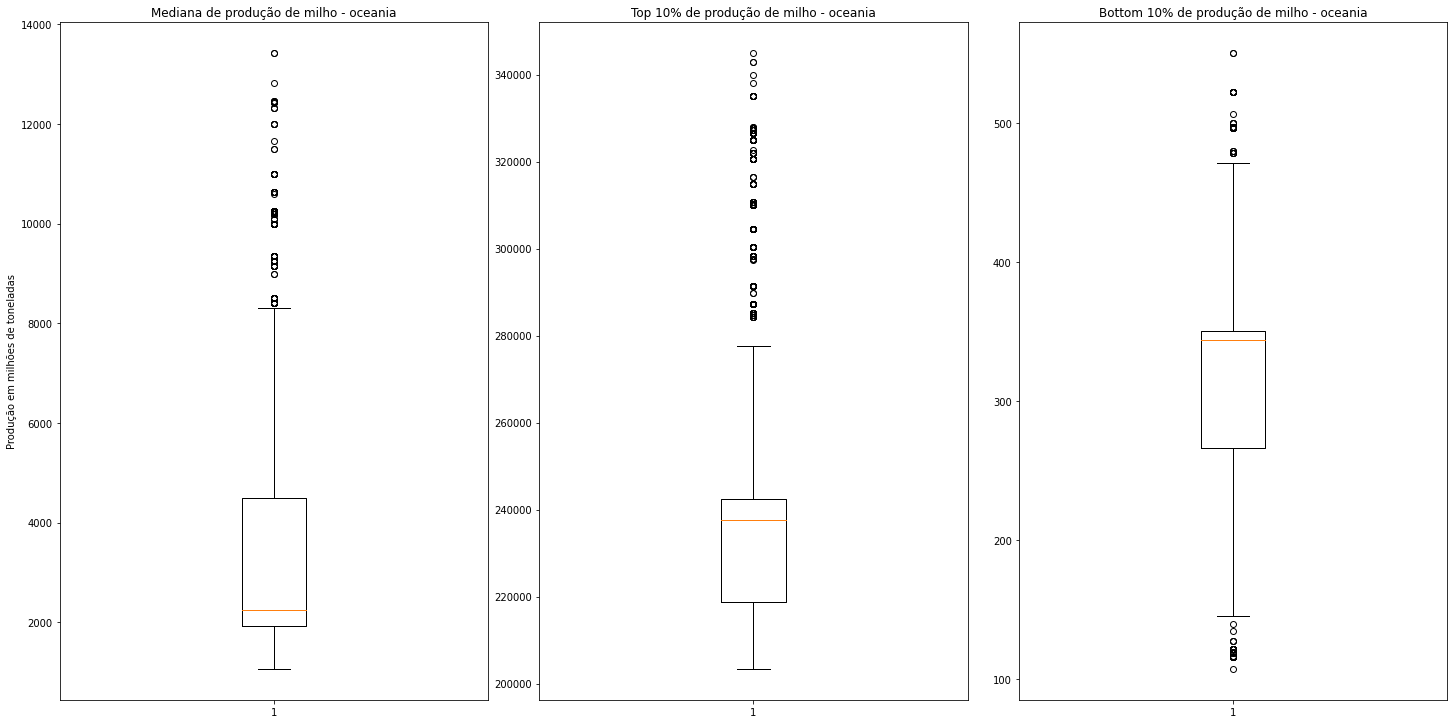

In [ ]:
# Oceania
oceania_prod = continentes_prod['oceania']
values_oc, li_oc_median, ls_oc_median = get_status_continente(oceania_prod, 'oceania', 'milho')

###Comparação

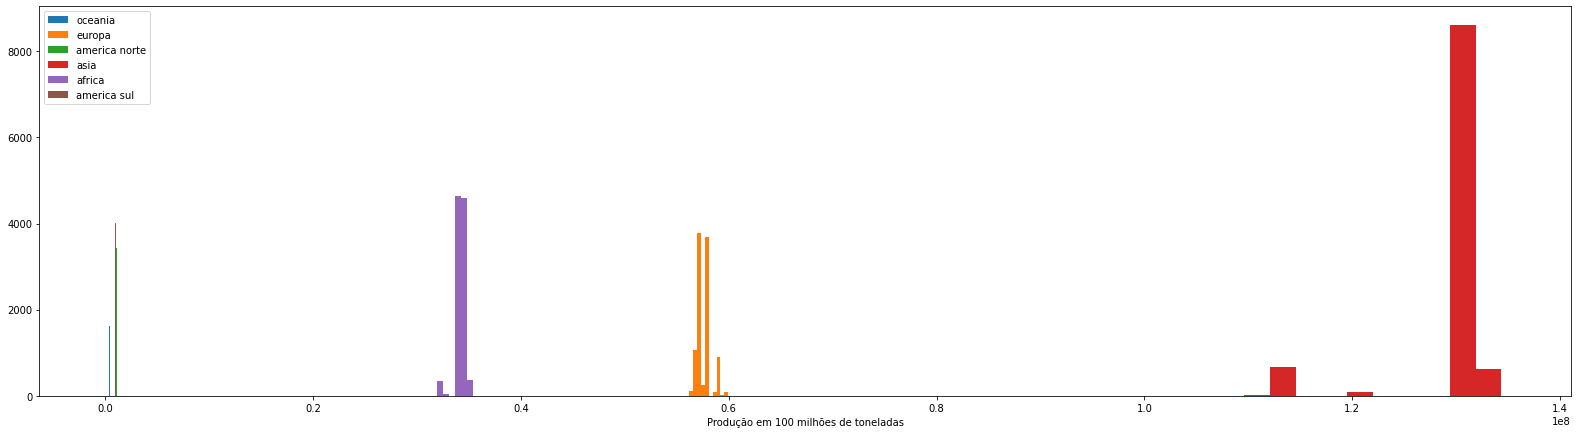

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()

axs.hist(values_oc, label='oceania')
axs.hist(values_eu, label='europa')
axs.hist(values_an, label='america norte')
axs.hist(values_asi, label='asia')
axs.hist(values_a, label='africa')
axs.hist(values_as, label='america sul')

axs.set_xlabel('Produção em 100 milhões de toneladas')
axs.legend()
plt.show()

É perceptível que a América do Sul não se posiciona em primeiro sem a produção do Brasil. Como a África se posiciona como primeira colocada basta verificar se a tendência observada no Brasil se repete nela. 

0.9027081631705265


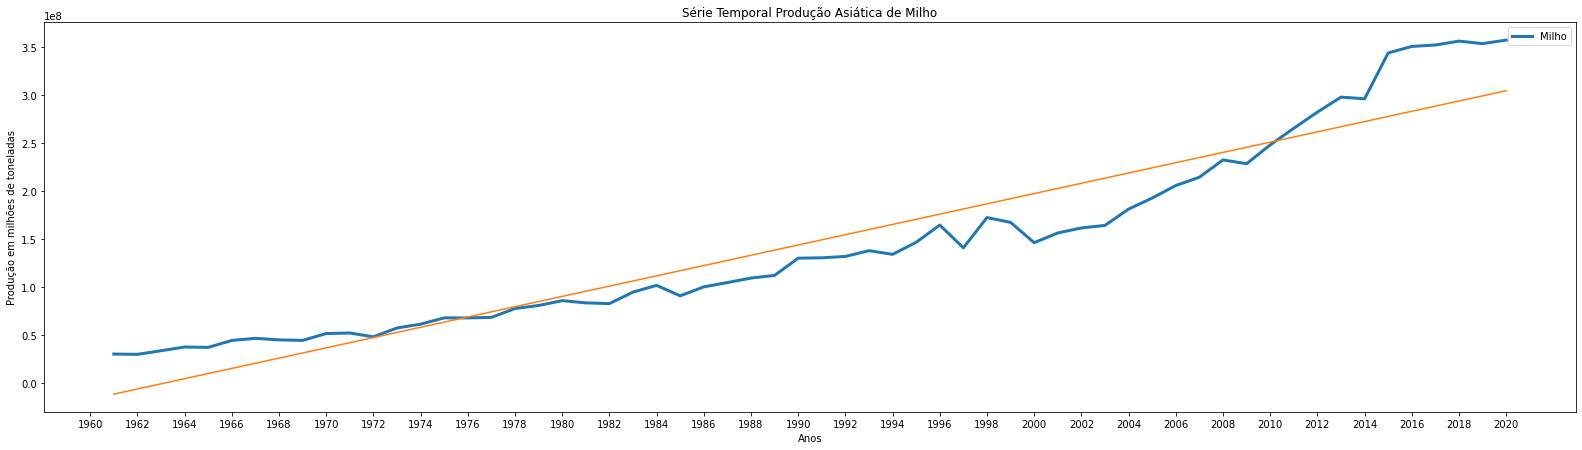

In [ ]:
milho_a = continentes_prod['asia'].groupby('Year').sum()
milho_a = milho_a.reset_index()
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(milho_a['Year'], milho_a['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produção Asiática de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em milhões de toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
reg = LinearRegression().fit(np.array(milho_a['Year']).reshape(-1, 1), milho_a['Value'])
print(reg.score(np.array(milho_a['Year']).reshape(-1, 1), milho_a['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

A Ásia domina também a produção de milho no mundo, demonstrando um grande crescimento de produção ao longo dos 60 anos.

### Produtividade

In [ ]:
produtividade = []
for country in prod_milho['Area'].unique():
  for year in prod_milho['Year'].unique():
    v = prod_milho[(prod_milho['Year'] == year) & (prod_milho['Area'] == country)]
    a = area_milho[(area_milho['Year'] == year) & (area_milho['Area'] == country)]
    if (len(v) > 0) and (len(a) > 0):
      if v.isna().iloc[0]['Value']:
        continue
      elif a.isna().iloc[0]['Value']:
        continue
      else:
        v = v.iloc[0]['Value']
        a = a.iloc[0]['Value']
        if a > 0:
          produtividade.append([year, country, (v/a)])

In [ ]:
df_prod = pd.DataFrame(produtividade, columns=['Year', 'Area', 'Value'])

#### Continentes

In [ ]:
continentes_produtiv = get_continentes(df_prod)

##### Africa

Desconsideramos as ilhas Maurício por estarem afetando a análise de produtividade da África, uma vez que o valor de 13 ton/ha está fora da realidade da maioria dos países africanos, mesmo os grandes produtores.

Top 10%
('Egypt', 5.265338359847849)
('Mauritius', 4.1997002710528815)
('South Africa', 2.268839473731752)
Bottom 10%
('Cabo Verde', 0.3251807457007053)
('Botswana', 0.26155352157914014)


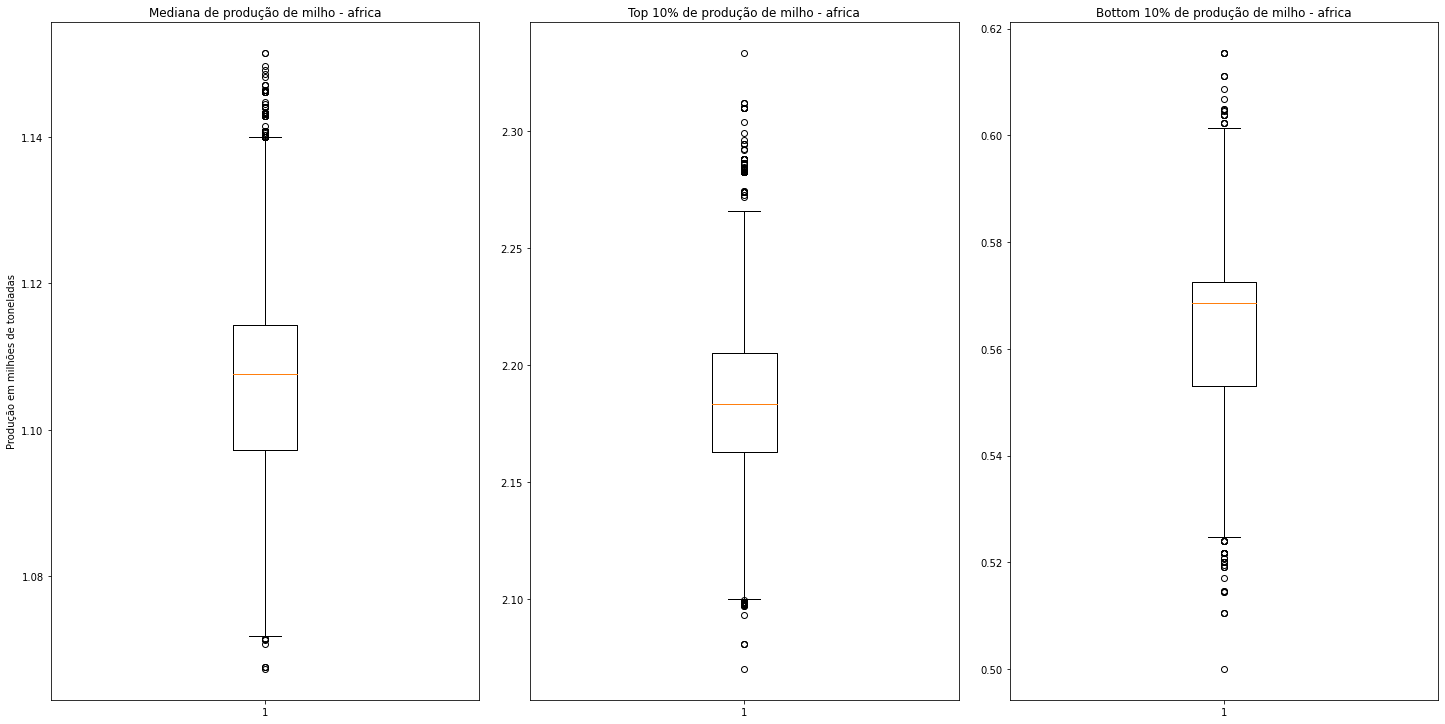

In [ ]:
# Africa
africa_produtiv = continentes_produtiv['africa']
values_a_p, li_a_p_median, ls_a_p_median = get_status_continente(africa_produtiv, 'africa', 'milho', False)
africa_prod = continentes_prod['africa'].groupby('Year').sum()
africa_area = continentes_area['africa'].groupby('Year').sum()

0.7934429797337673


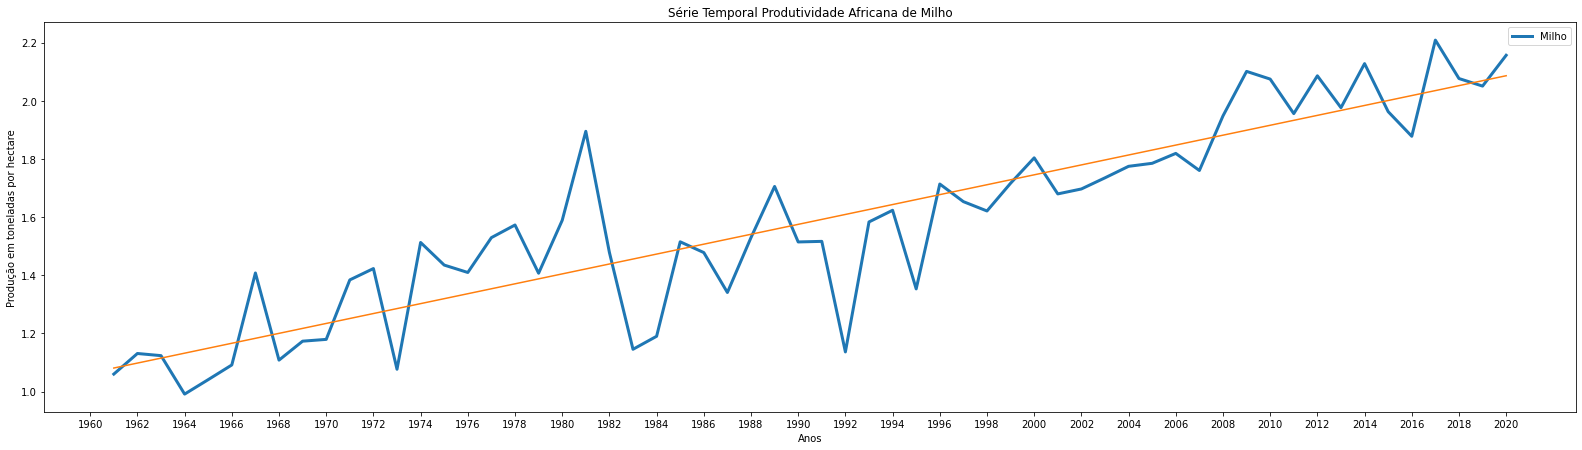

In [ ]:
africa_c_produtiv = (africa_prod / africa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(africa_c_produtiv['Year'], africa_c_produtiv['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Africana de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
milho_a_reg = LinearRegression().fit(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value'])
print(milho_a_reg.score(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = milho_a_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Asia

Top 10%
('United Arab Emirates', 21.549479354800837)
('Kuwait', 14.967246887849804)
('Israel', 12.618499781422429)
('Qatar', 12.526247201544319)
('Jordan', 9.280639232672508)
('Oman', 7.536244226910932)
Bottom 10%
('Maldives', 1.0)
('Bangladesh', 0.9377763783252338)


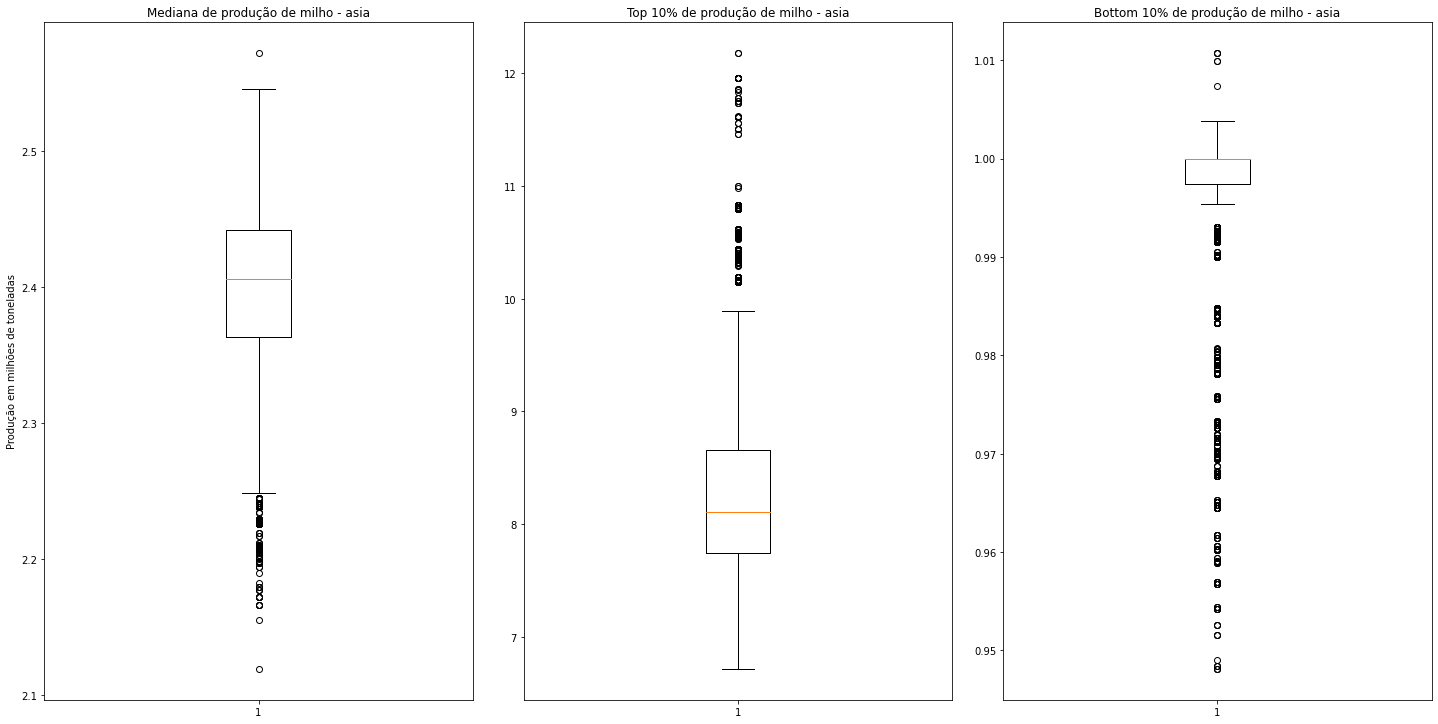

In [ ]:
# Asia
asia_produtiv = continentes_produtiv['asia']
values_asi_p, li_asi_p_median, ls_asi_p_median = get_status_continente(asia_produtiv, 'asia', 'milho', False)
asia_prod = continentes_prod['asia'].groupby('Year').sum()
asia_area = continentes_area['asia'].groupby('Year').sum()

0.9871841571257559


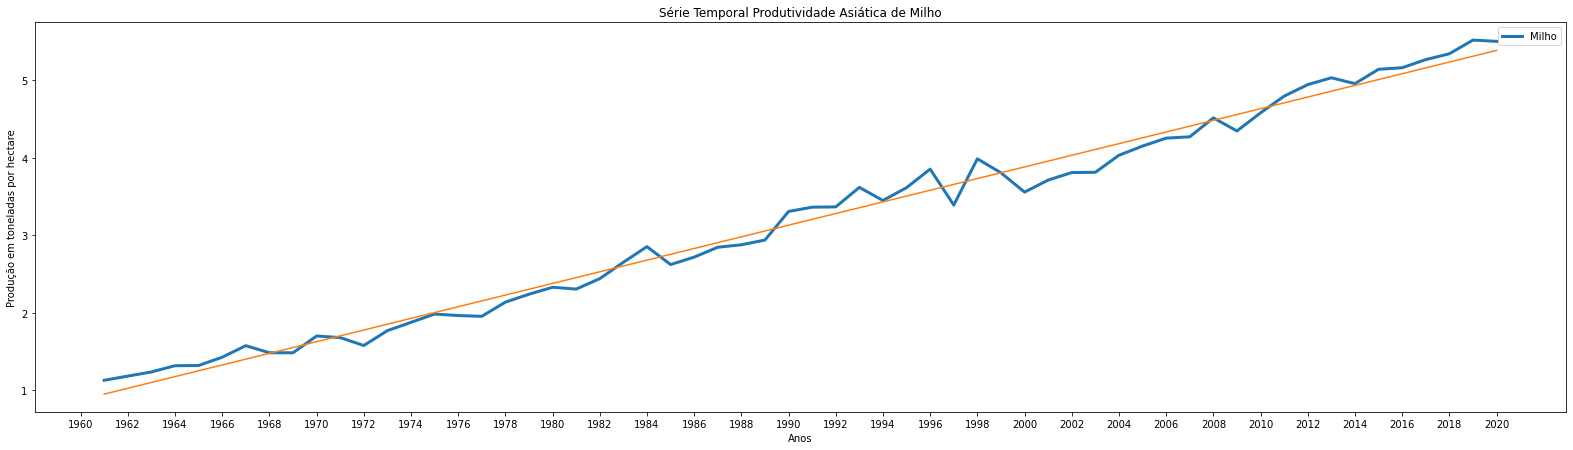

In [ ]:
asia_c_produtiv = (asia_prod / asia_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(asia_c_produtiv['Year'], asia_c_produtiv['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Asiática de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
milho_asi_reg = LinearRegression().fit(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value'])
print(milho_asi_reg.score(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = milho_asi_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### America


###### Norte

Top 10%
('United States of America', 7.413480909036938)
('Canada', 6.406614883511699)
Bottom 10%
('Saint Lucia', 0.839143866337744)
('Haiti', 0.8035393329705949)


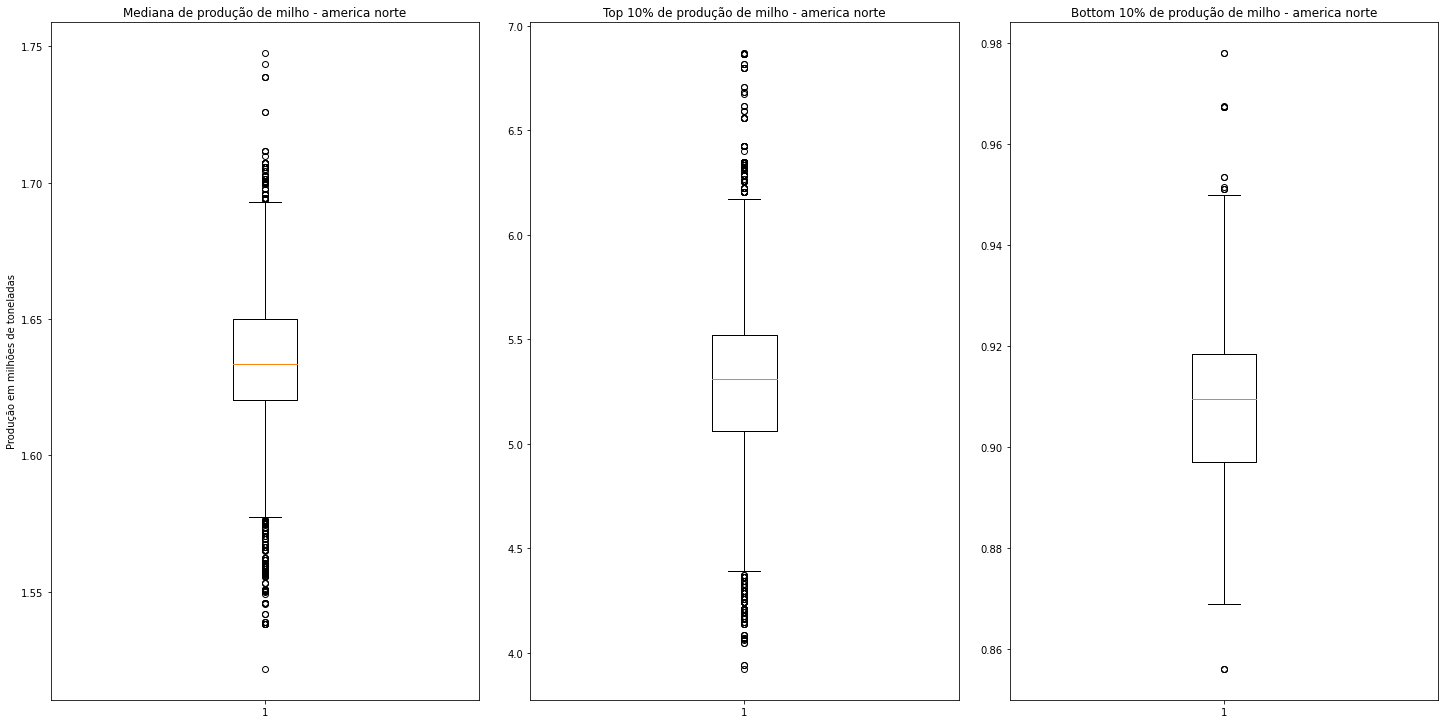

In [ ]:
# America Norte
america_n_produtiv = continentes_produtiv['america_n']
values_a_n_p, li_a_n_p_median, ls_a_n_p_median = get_status_continente(america_n_produtiv, 'america norte', 'milho', False)
america_n_prod = continentes_prod['america_n'].groupby('Year').sum()
america_n_area = continentes_area['america_n'].groupby('Year').sum()

0.9244875721907695


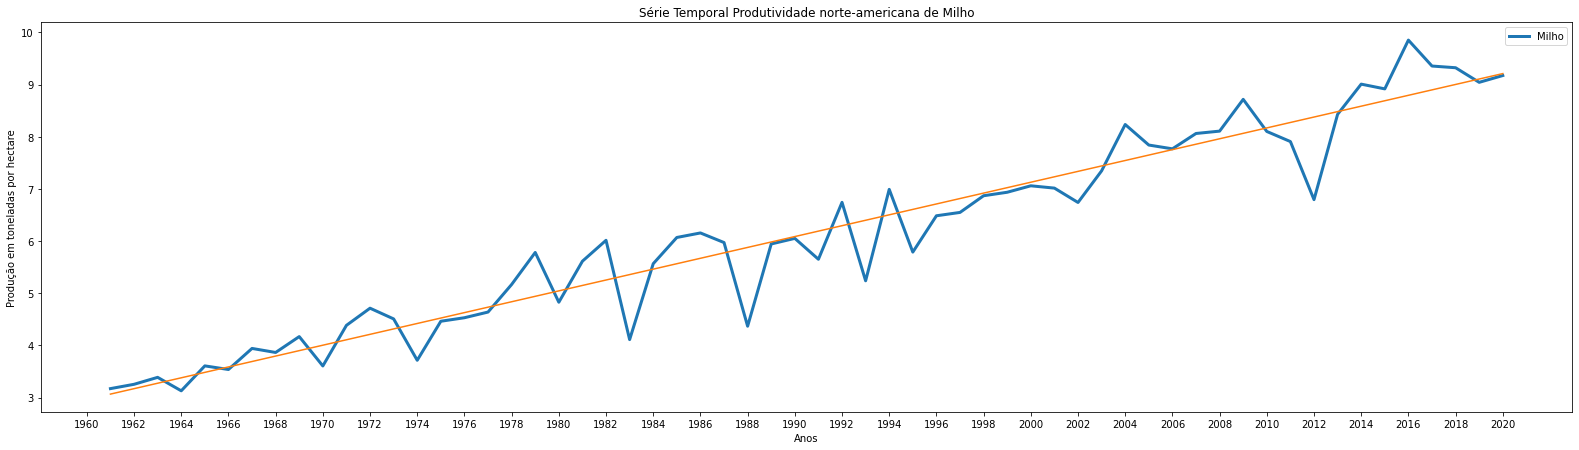

In [ ]:
america_n_c_produtiv = (america_n_prod / america_n_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_n_c_produtiv['Year'], america_n_c_produtiv['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade norte-americana de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
milho_a_n_reg = LinearRegression().fit(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value'])
print(milho_a_n_reg.score(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = milho_a_n_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

###### Sul

Top 10%
('Chile', 8.046324420477784)
Bottom 10%


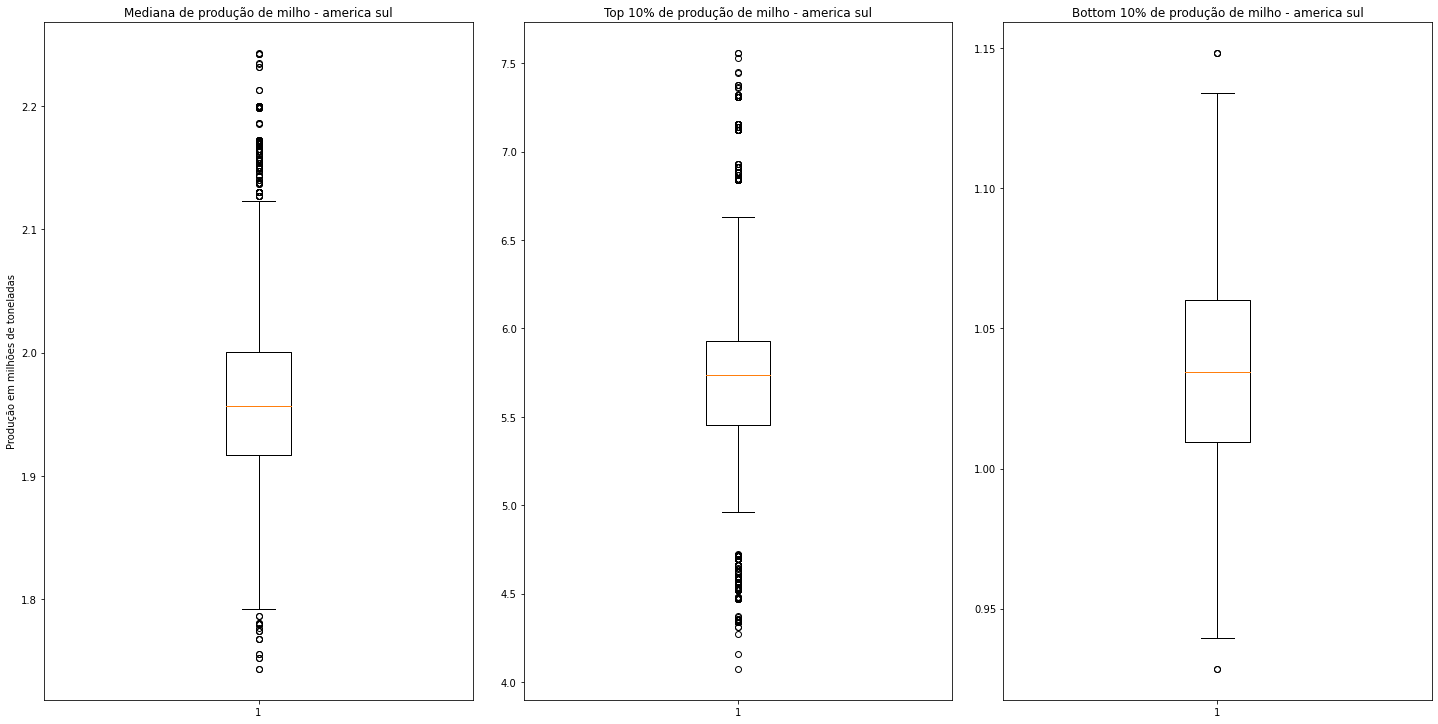

In [ ]:
# America sul
america_s_produtiv = continentes_produtiv['america_s']
values_a_s_p, li_a_s_p_median, ls_a_s_p_median = get_status_continente(america_s_produtiv, 'america sul', 'milho', False)
america_s_prod = continentes_prod['america_s'].groupby('Year').sum()
america_s_area = continentes_area['america_s'].groupby('Year').sum()

0.9113024017014626


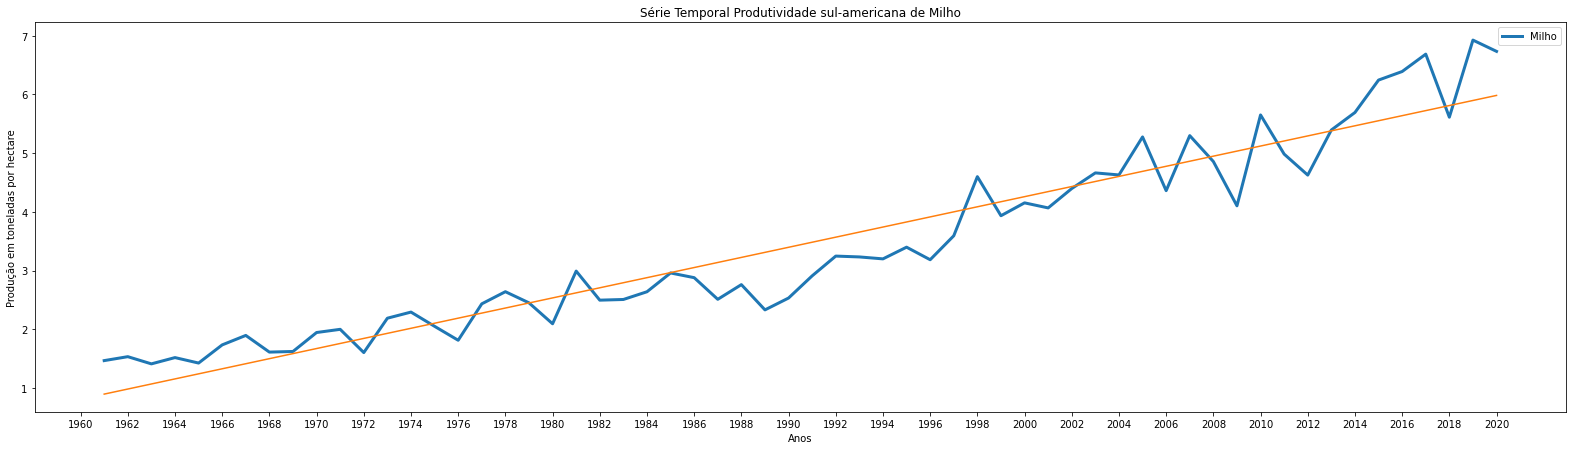

In [ ]:
america_s_c_produtiv = (america_s_prod / america_s_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_s_c_produtiv['Year'], america_s_c_produtiv['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade sul-americana de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
milho_a_s_reg = LinearRegression().fit(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value'])
print(milho_a_s_reg.score(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = milho_a_s_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Europa

Top 10%
('Belgium', 11.149847710839836)
('Greece', 9.576354620735954)
Bottom 10%


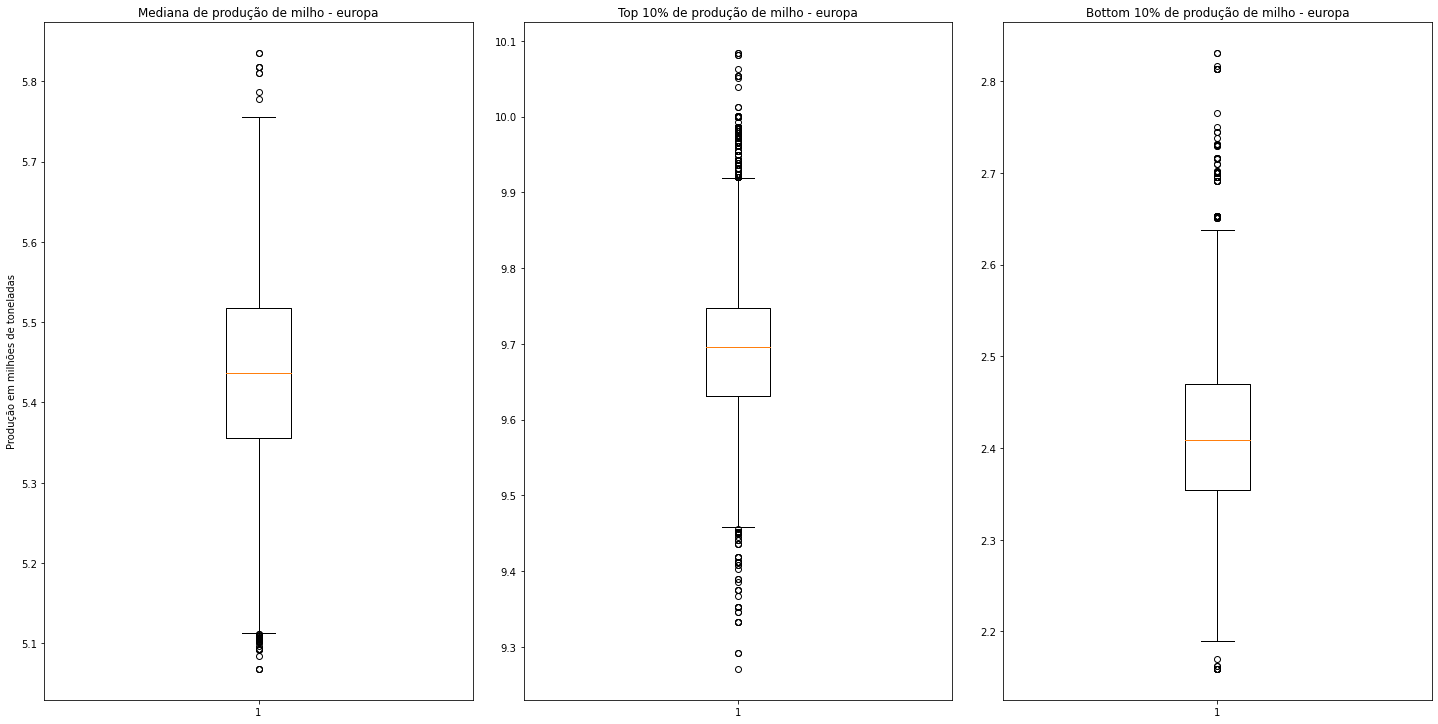

In [ ]:
# Europa
europa_produtiv = continentes_produtiv['europa']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(europa_produtiv, 'europa', 'milho', False)
europa_prod = continentes_prod['europa'].groupby('Year').sum()
europa_area = continentes_area['europa'].groupby('Year').sum()

0.9064121401016635


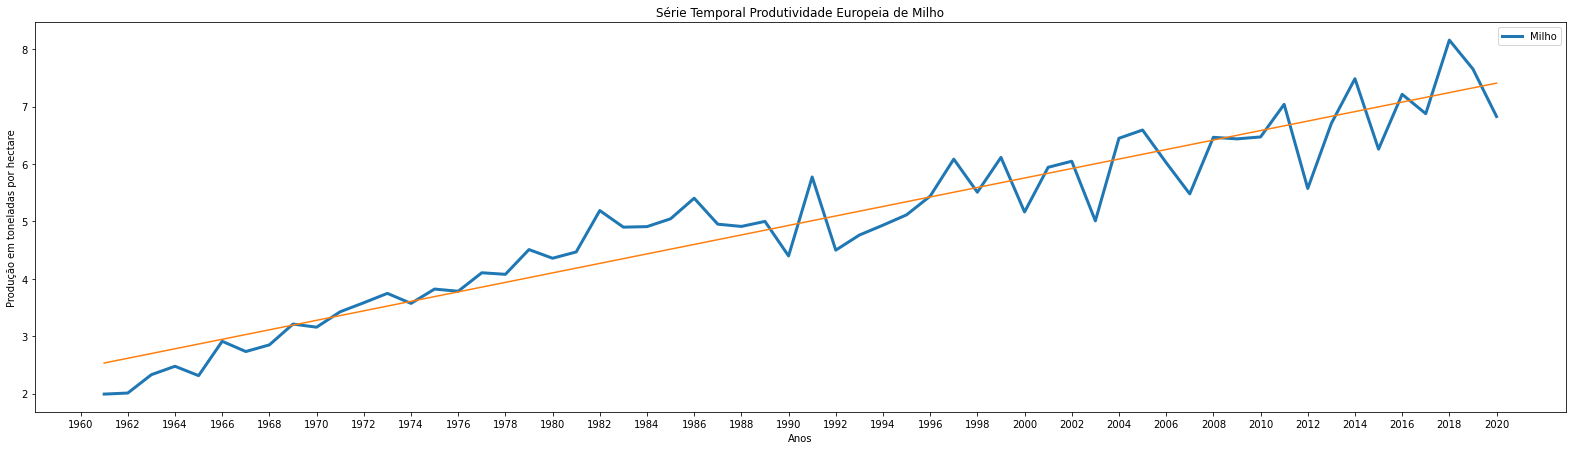

In [ ]:
europa_c_produtiv = (europa_prod / europa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(europa_c_produtiv['Year'], europa_c_produtiv['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Europeia de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
milho_eu_reg = LinearRegression().fit(np.array(europa_c_produtiv['Year']).reshape(-1, 1), europa_c_produtiv['Value'])
print(milho_eu_reg.score(np.array(europa_c_produtiv['Year']).reshape(-1, 1), europa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = milho_eu_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Oceania

Top 10%
('New Zealand', 9.331951331117255)
Bottom 10%
('Vanuatu', 0.5132324399735931)


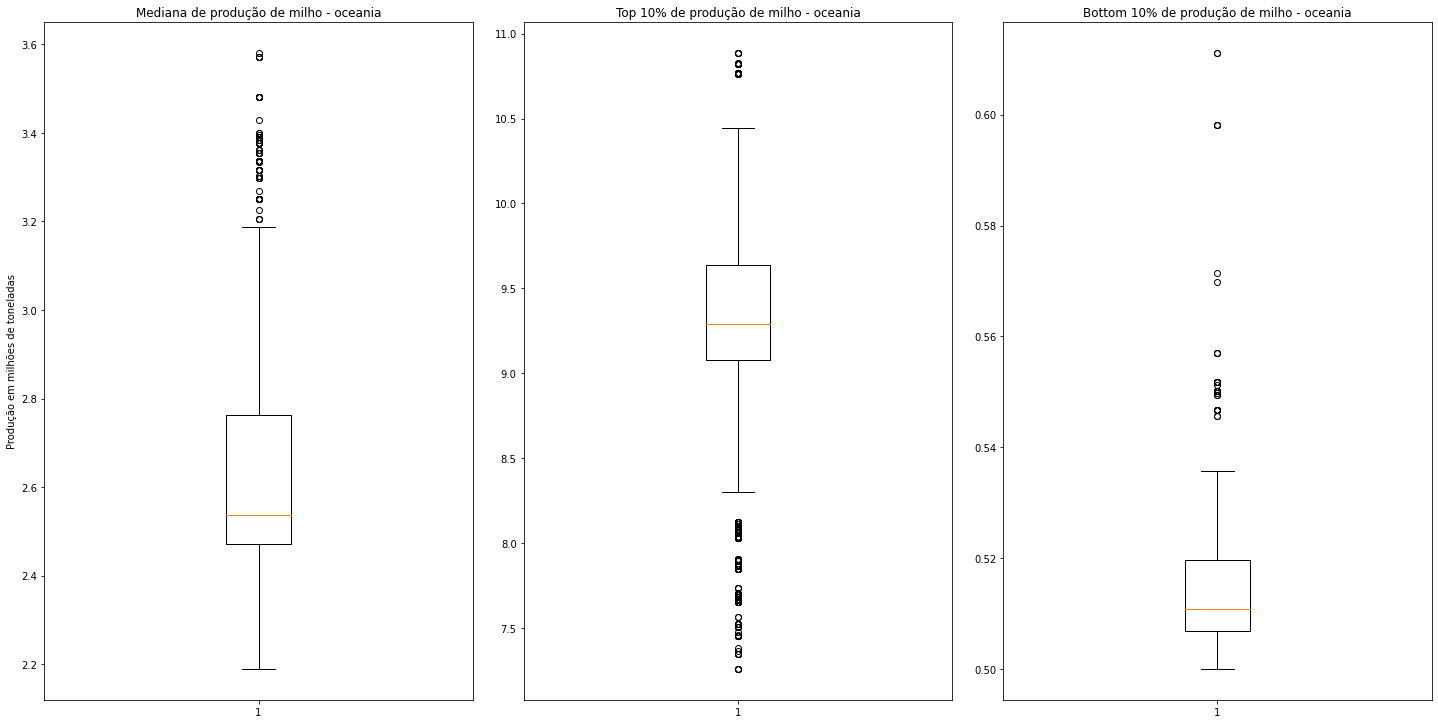

In [ ]:
# Oceania
oceania_produtiv = continentes_produtiv['oceania']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(oceania_produtiv, 'oceania', 'milho', False)
oceania_prod = continentes_prod['oceania'].groupby('Year').sum()
oceania_area = continentes_area['oceania'].groupby('Year').sum()

0.9258499813826043


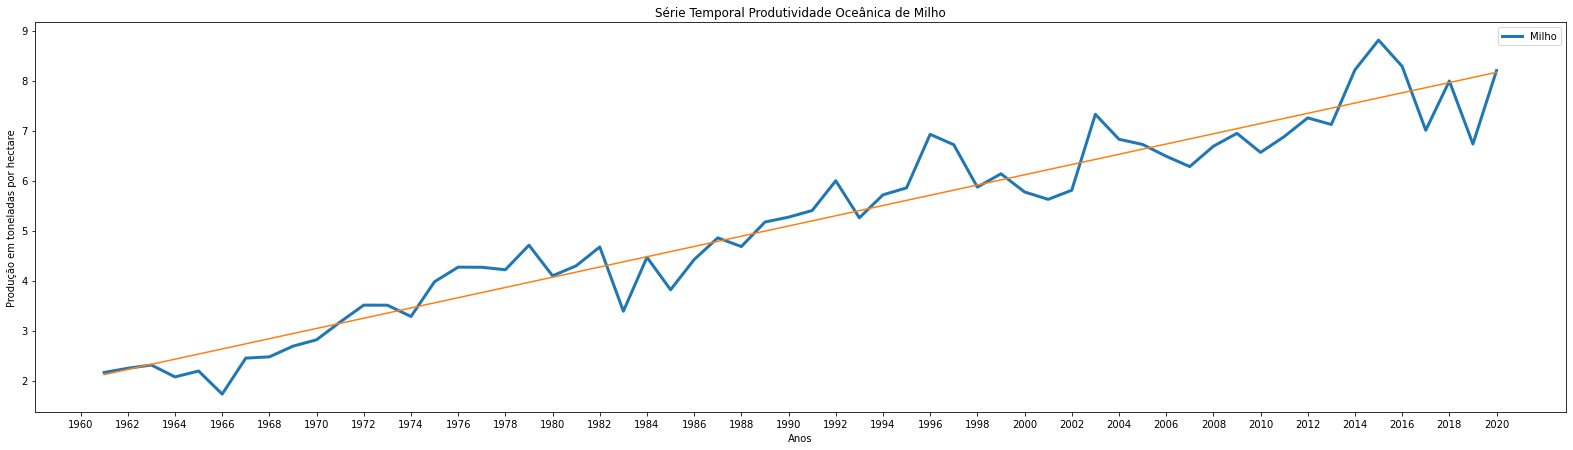

In [ ]:
oceania_c_produtiv = (oceania_prod / oceania_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(oceania_c_produtiv['Year'], oceania_c_produtiv['Value'], label='Milho', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Oceânica de Milho')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
milho_oc_reg = LinearRegression().fit(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value'])
print(milho_oc_reg.score(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = milho_oc_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

Podemos concluir então, que para a produção de café mundial vemos uma tendência do aumento de produtividade, ou seja, mais toneladas de café sendo produzidos por hectare plantado. 

Continente   | LI (ton/ha) | LS (ton/ha)  
---|---|---
Asia |  0.57 | 0.63
Oceania   | 0.55  |   0.65
America sul | 0.48  | 0.56  |
America norte| 0.49  |  0.52 |
Africa | 0.39  |  0.42   


##Soja

In [ ]:
df_soja = producao[producao['Item'] == 'Soybeans']
area_soja = df_soja[df_soja['Element Code'] == 5312]
prod_soja = df_soja[df_soja['Element Code'] == 5510]
preco_soja['date'] = pd.to_datetime(preco_soja['date'], format='%Y-%m-%d')
preco_soja[' value']=33.3*preco_soja[' value'] #converte bushel para tonelada



Variação dos preços da soja

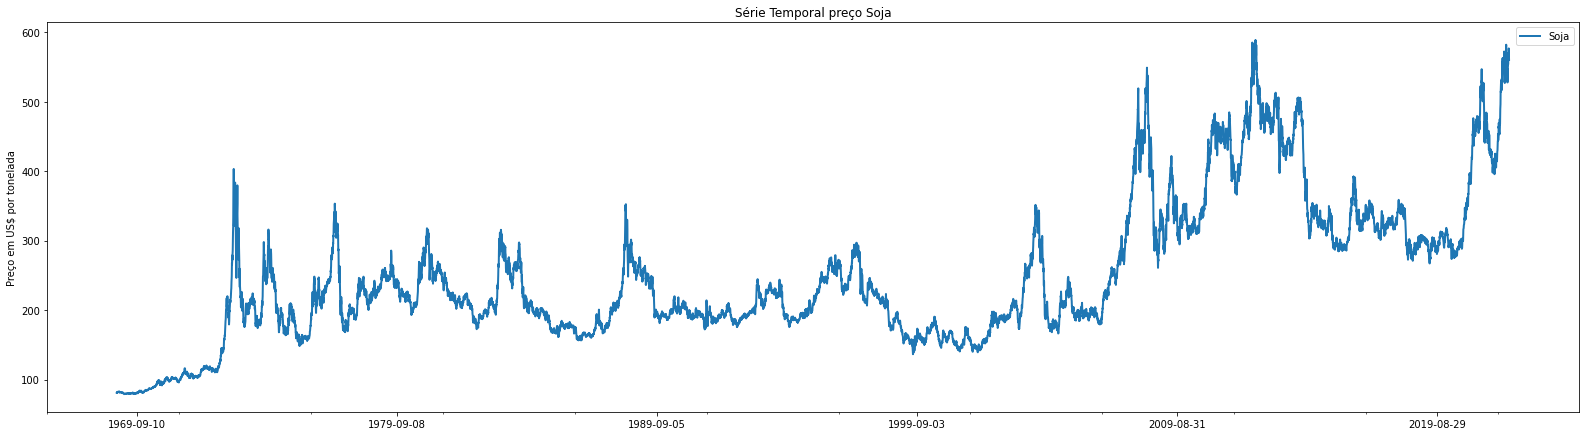

In [ ]:
#Serie temporal variacao de preco
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(preco_soja['date'], preco_soja[' value'], label='Soja', 
         linewidth=2)

axs.set_title('Série Temporal preço Soja')
axs.xaxis.set_major_locator(MultipleLocator(3650))
axs.xaxis.set_minor_locator(MultipleLocator(1850))
axs.set_ylabel('Preço em US$ por tonelada')

axs.legend()
axs.locator_params ('Data', nbins = 10) 

plt.show()

### Mundo

#### Variação da produção mundial

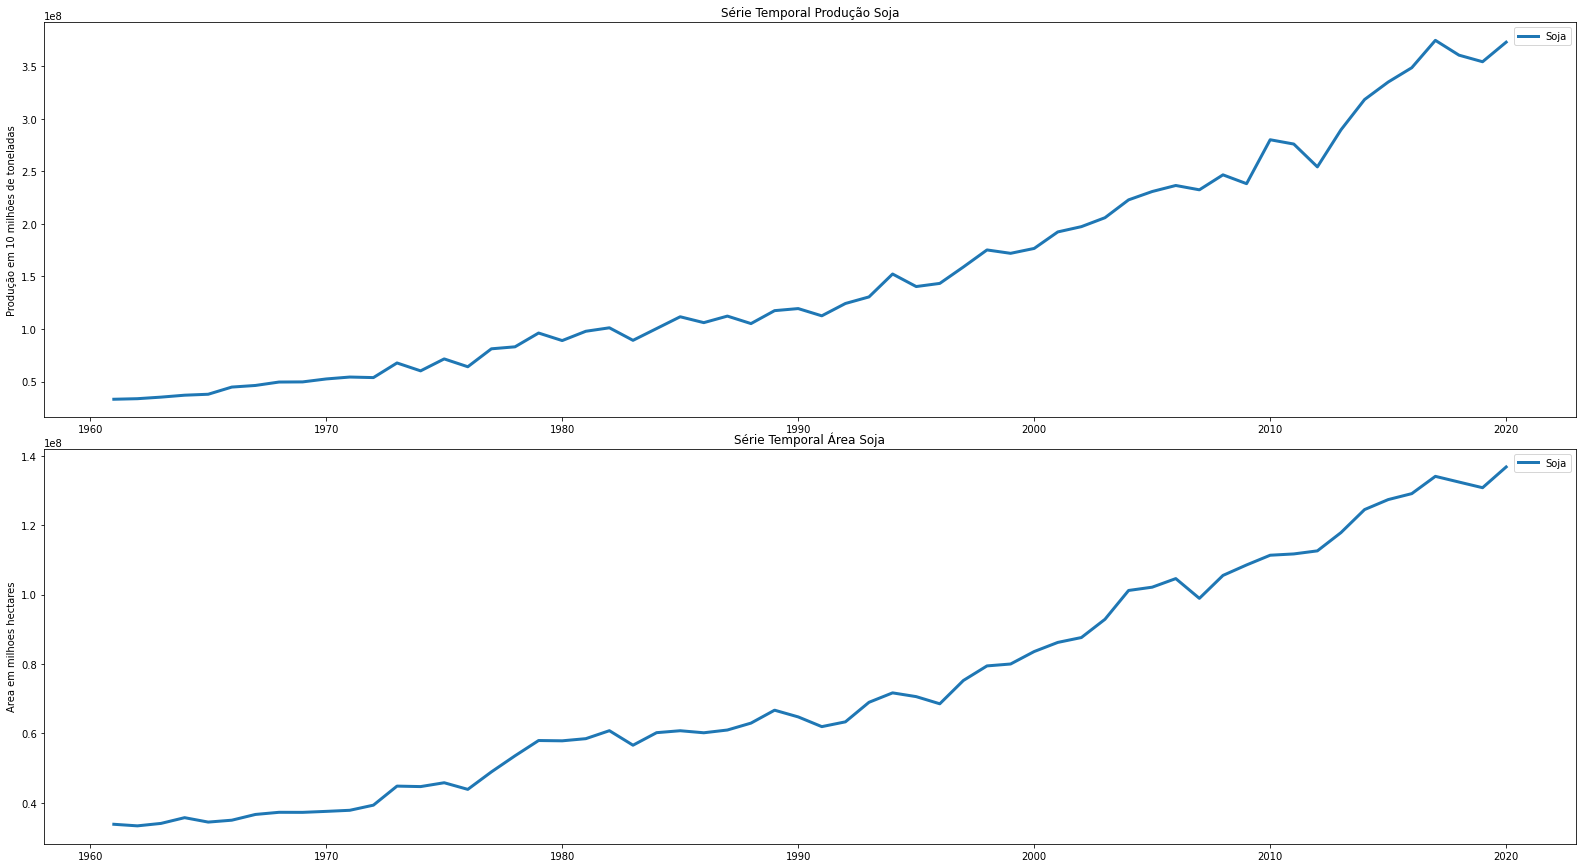

In [ ]:
#Serie temporal variacao da produção
prod_soja_anual = prod_soja[['Year', 'Value']].groupby('Year').sum()
prod_soja_anual = prod_soja_anual.reset_index()
#Serie temporal variacao da area
area_soja_anual = area_soja[['Year', 'Value']].groupby('Year').sum()
area_soja_anual = area_soja_anual.reset_index()
plot_mundo(prod_soja_anual, area_soja_anual, 'Soja')

### Continentes

In [ ]:
continentes_prod = get_continentes(prod_soja)
continentes_area = get_continentes(area_soja)

#### Africa

Top 10%
('Nigeria', 160784.2401500938)
('Ghana', 145992.66557223265)
Bottom 10%
('Madagascar', 47.92542213883677)
('Senegal', 0.0)


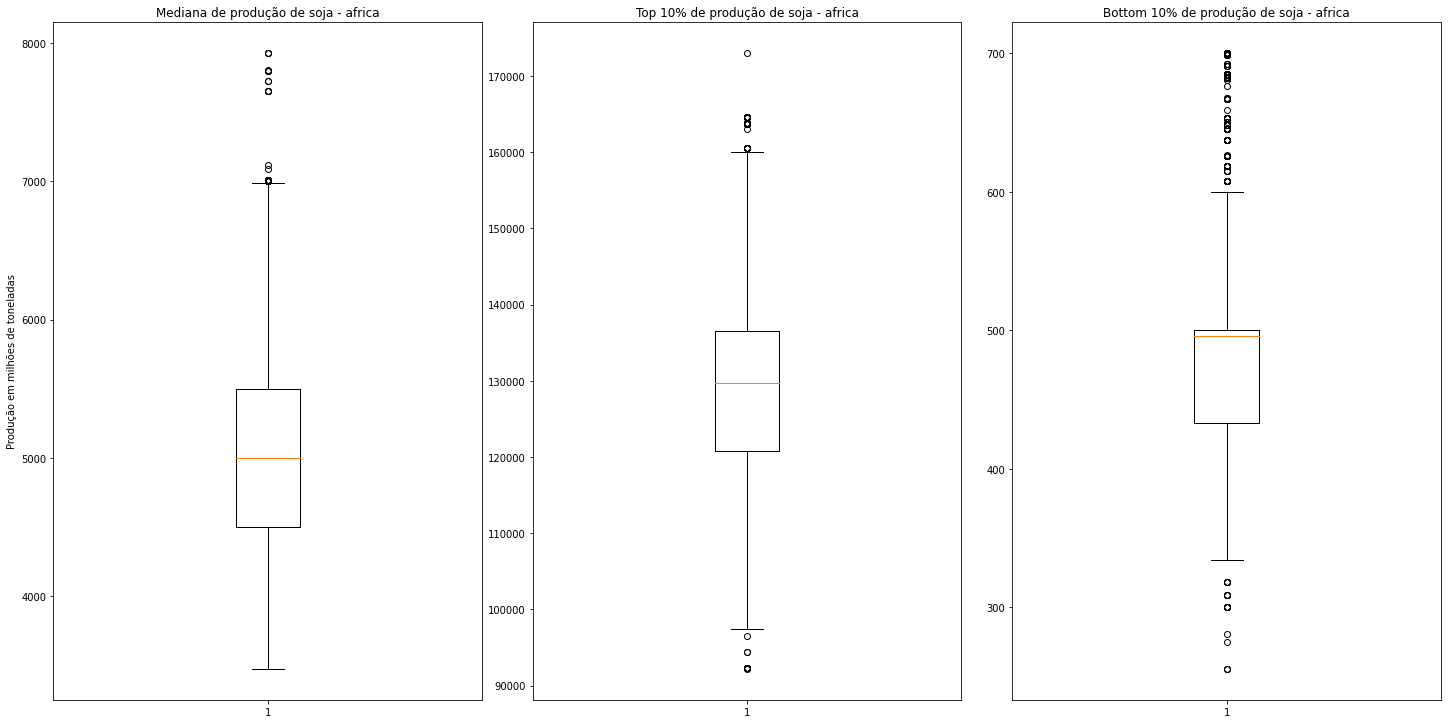

In [ ]:
# Africa
africa_prod = continentes_prod['africa']
values_a, li_a_median, ls_a_median = get_status_continente(africa_prod, 'africa', 'soja')

#### Asia

Top 10%
('China', 11578928.33072713)
('India', 2562187.412040657)
('Indonesia', 770763.4417513682)
Bottom 10%
('Azerbaijan', 30.18842845973417)
('Malaysia', 29.556684910086005)
('Tajikistan', 19.77013291634089)
('Jordan', 0.0)


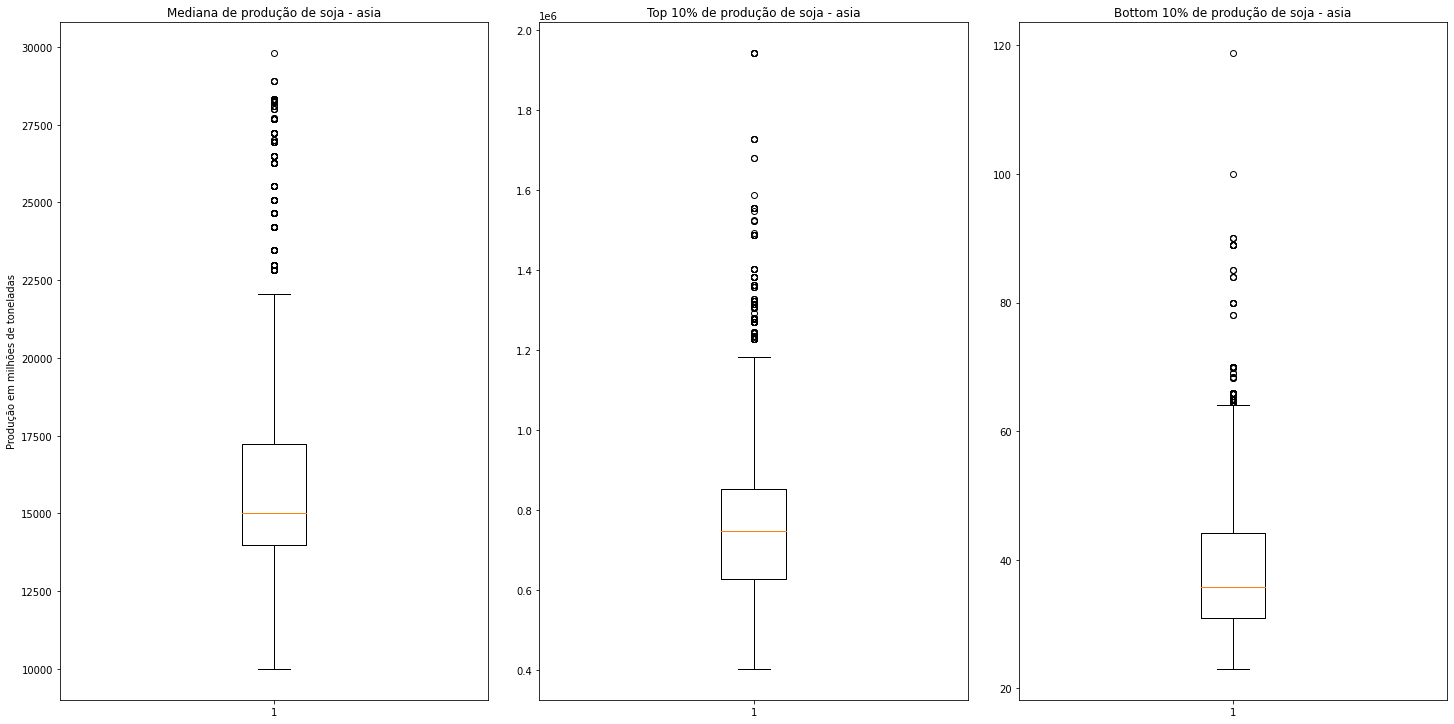

In [ ]:
# Asia
asia_prod = continentes_prod['asia']
values_asi, li_asi_median, ls_asi_median = get_status_continente(asia_prod, 'asia', 'soja')

#### America

##### Norte

Top 10%
('United States of America', 57493878.461904764)
Bottom 10%
('Panama', 100.0)


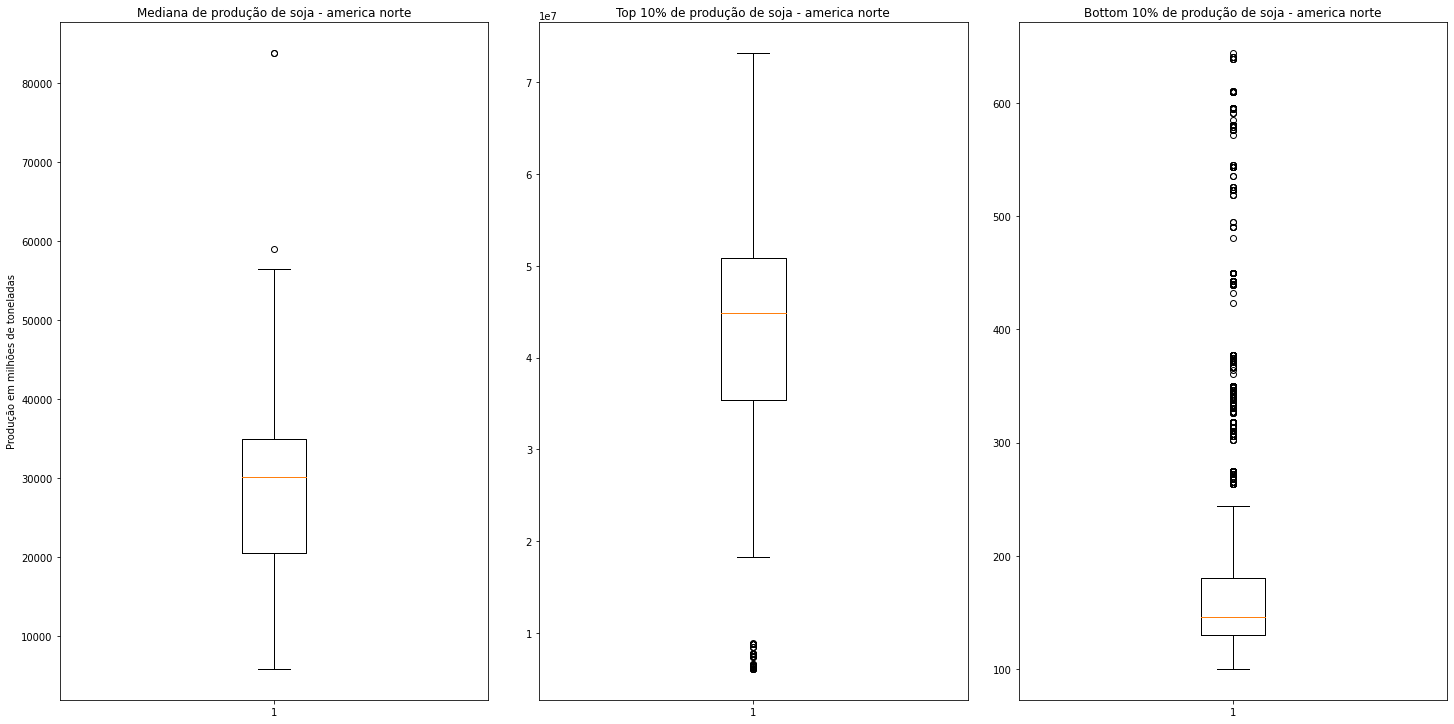

In [ ]:
# America Norte
america_n_prod = continentes_prod['america_n']
values_a_n, li_a_n_median, ls_a_n_median = get_status_continente(america_n_prod, 'america norte', 'soja')

##### Sul

Top 10%
('Argentina', 10312556.883910388)
Bottom 10%
('Suriname', 32.73930753564155)
('Guyana', 4.030549898167006)


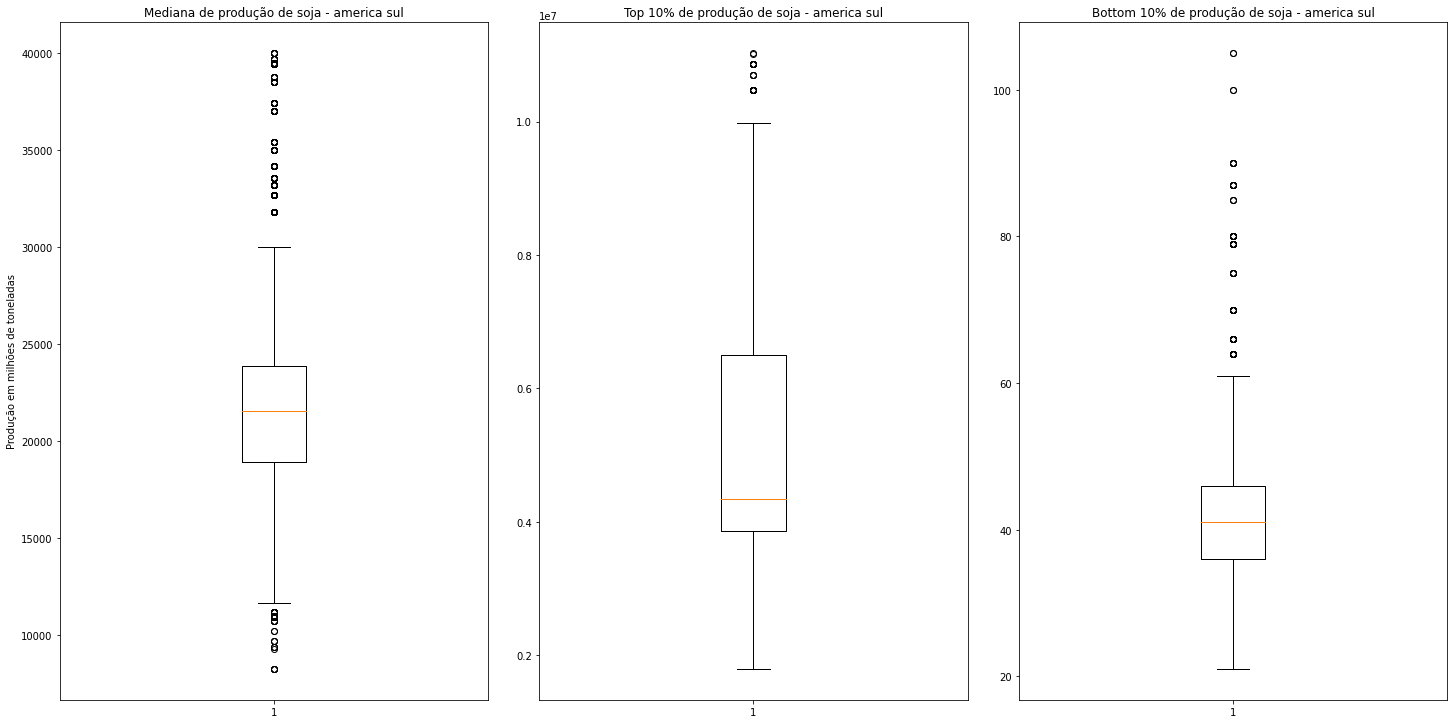

In [ ]:
# America sul
america_s_prod = continentes_prod['america_s']
values_a_s, li_a_s_median, ls_a_s_median = get_status_continente(america_s_prod, 'america sul', 'soja')

#### Europa

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/p

Top 10%
('Ukraine', 724401.6412661195)
('Italy', 492412.5521688159)
('Serbia', 454130.49355216883)
Bottom 10%
('Slovenia', 233.31887456037515)
('North Macedonia', 168.6459554513482)
('Luxembourg', 30.0)
('Cyprus', 0.0)
('Denmark', 0.0)
('Estonia', 0.0)
('Ireland', 0.0)
('Latvia', 0.0)
('Malta', 0.0)


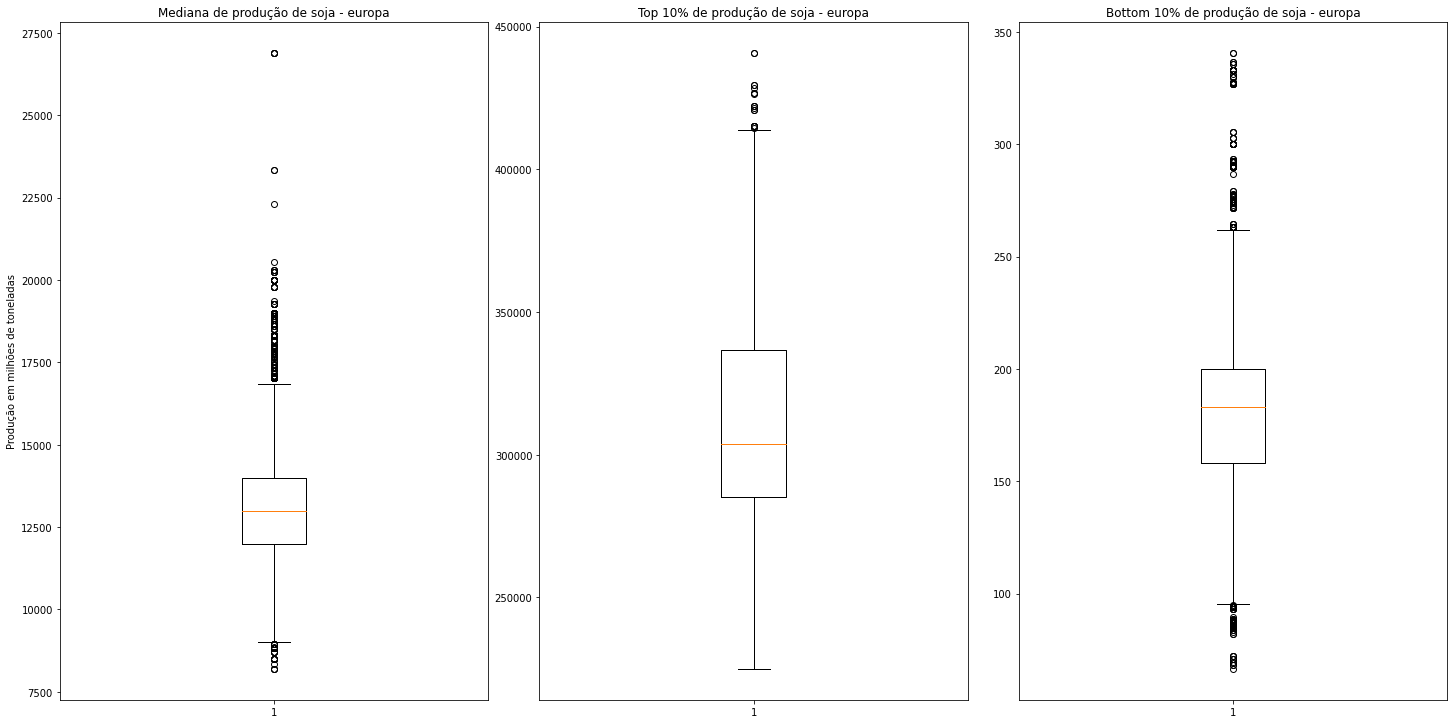

In [ ]:
# Europa
europa_prod = continentes_prod['europa']
values_eu, li_eu_median, ls_eu_median = get_status_continente(europa_prod, 'europa', 'soja')

#### Oceania

Top 10%
Bottom 10%
('New Zealand', 141.03896103896105)


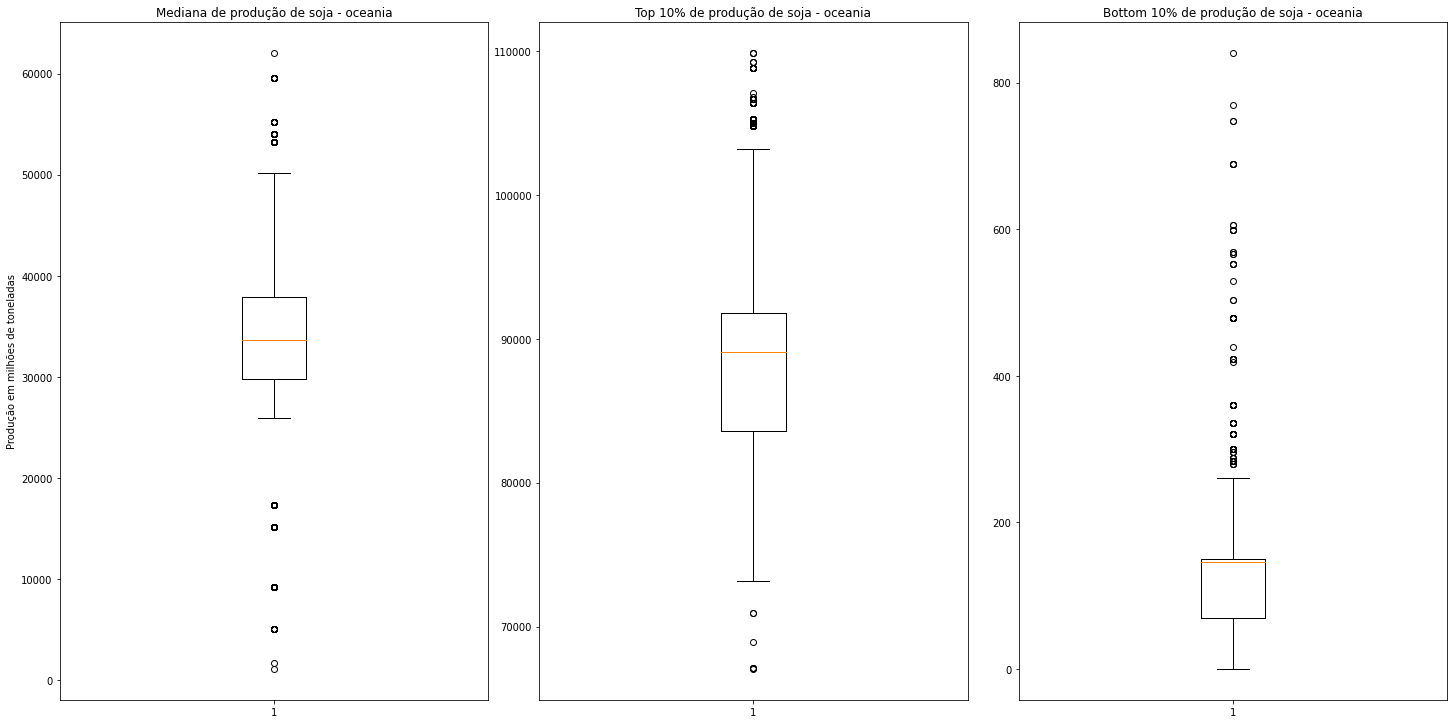

In [ ]:
# Oceania
oceania_prod = continentes_prod['oceania']
values_oc, li_oc_median, ls_oc_median = get_status_continente(oceania_prod, 'oceania', 'soja')

###Comparação

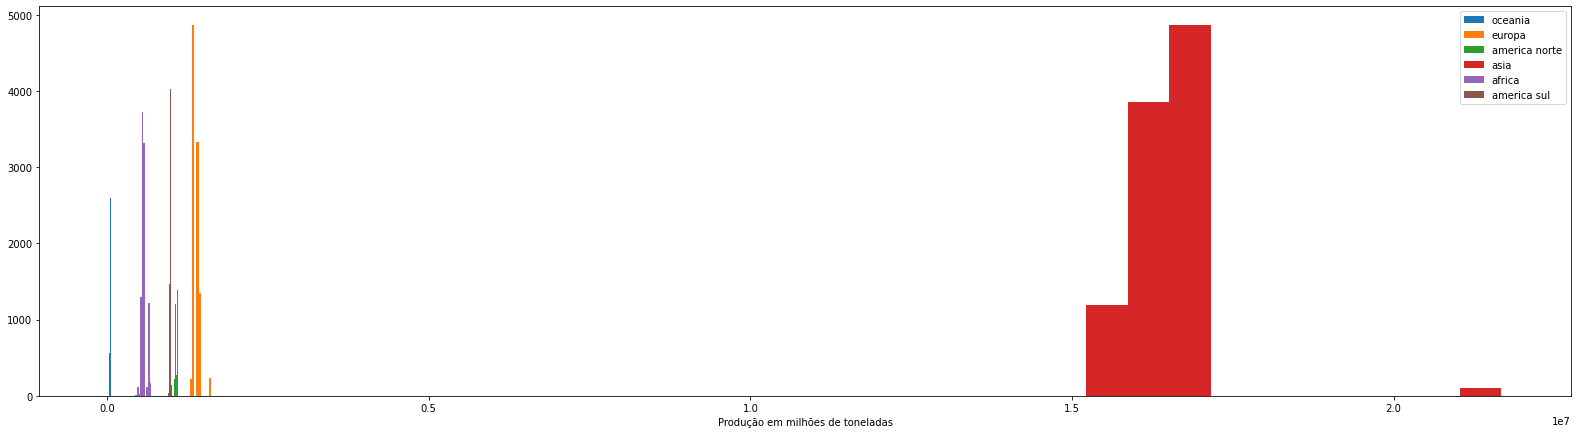

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()

axs.hist(values_oc, label='oceania')
axs.hist(values_eu, label='europa')
axs.hist(values_an, label='america norte')
axs.hist(values_asi, label='asia')
axs.hist(values_a, label='africa')
axs.hist(values_as, label='america sul')

axs.set_xlabel('Produção em milhões de toneladas')
axs.legend()
plt.show()

Ao removermos o Brasil a Ásia se posiciona como maior produtora de soja do mundo também, em grande parte por causa da China.

0.9220616532236264


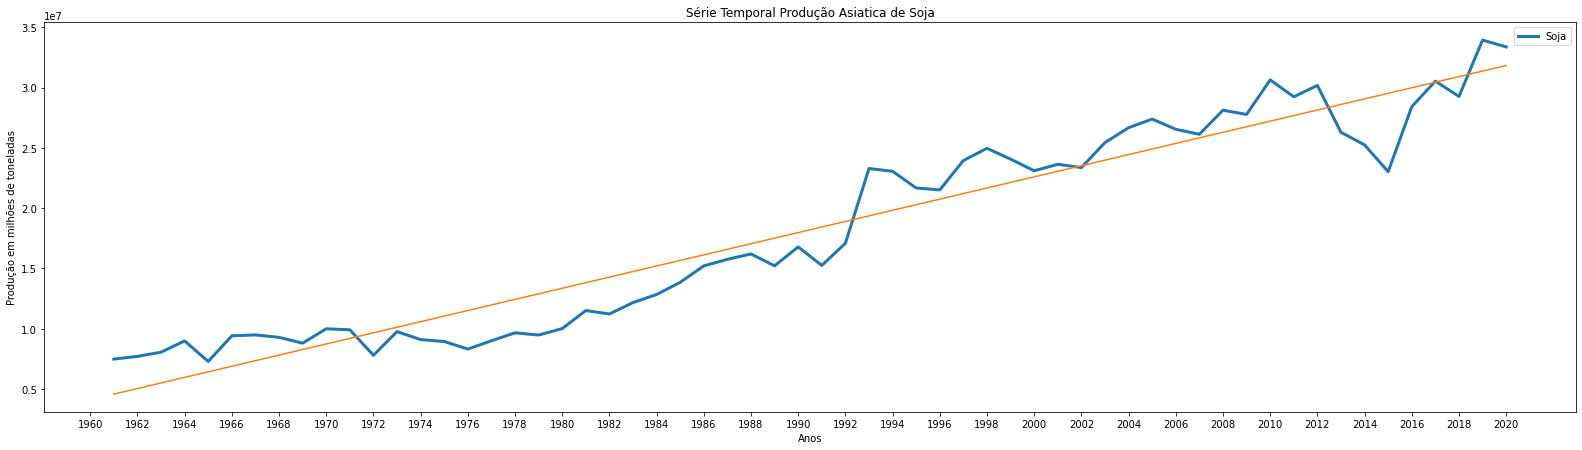

In [ ]:
soja_a = continentes_prod['asia'].groupby('Year').sum()
soja_a = soja_a.reset_index()
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(soja_a['Year'], soja_a['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produção Asiatica de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em milhões de toneladas')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
reg = LinearRegression().fit(np.array(soja_a['Year']).reshape(-1, 1), soja_a['Value'])
print(reg.score(np.array(soja_a['Year']).reshape(-1, 1), soja_a['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

Por mais que a África seja a maior produtora quando removemos o Brasil do cenário vemos uma leve tendência de diminuição na produção de café africano ao longo dos anos.

### Produtividade

In [ ]:
produtividade = []
for country in prod_soja['Area'].unique():
  for year in prod_soja['Year'].unique():
    v = prod_soja[(prod_soja['Year'] == year) & (prod_soja['Area'] == country)]
    a = area_soja[(area_soja['Year'] == year) & (area_soja['Area'] == country)]
    if (len(v) > 0) and (len(a) > 0):
      if v.isna().iloc[0]['Value']:
        continue
      elif a.isna().iloc[0]['Value']:
        continue
      else:
        v = v.iloc[0]['Value']
        a = a.iloc[0]['Value']
        if a > 0:
          produtividade.append([year, country, (v/a)])

In [ ]:
df_prod = pd.DataFrame(produtividade, columns=['Year', 'Area', 'Value'])

#### Continentes

In [ ]:
continentes_produtiv = get_continentes(df_prod)

##### Africa

Desconsideramos as ilhas Maurício por estarem afetando a análise de produtividade da África, uma vez que o valor de 13 ton/ha está fora da realidade da maioria dos países africanos, mesmo os grandes produtores.

Top 10%
('Egypt', 2.818727003243908)
('Ethiopia PDR', 2.5199345966043984)
Bottom 10%
('Liberia', 0.397580398409862)
('Nigeria', 0.3630039040780881)


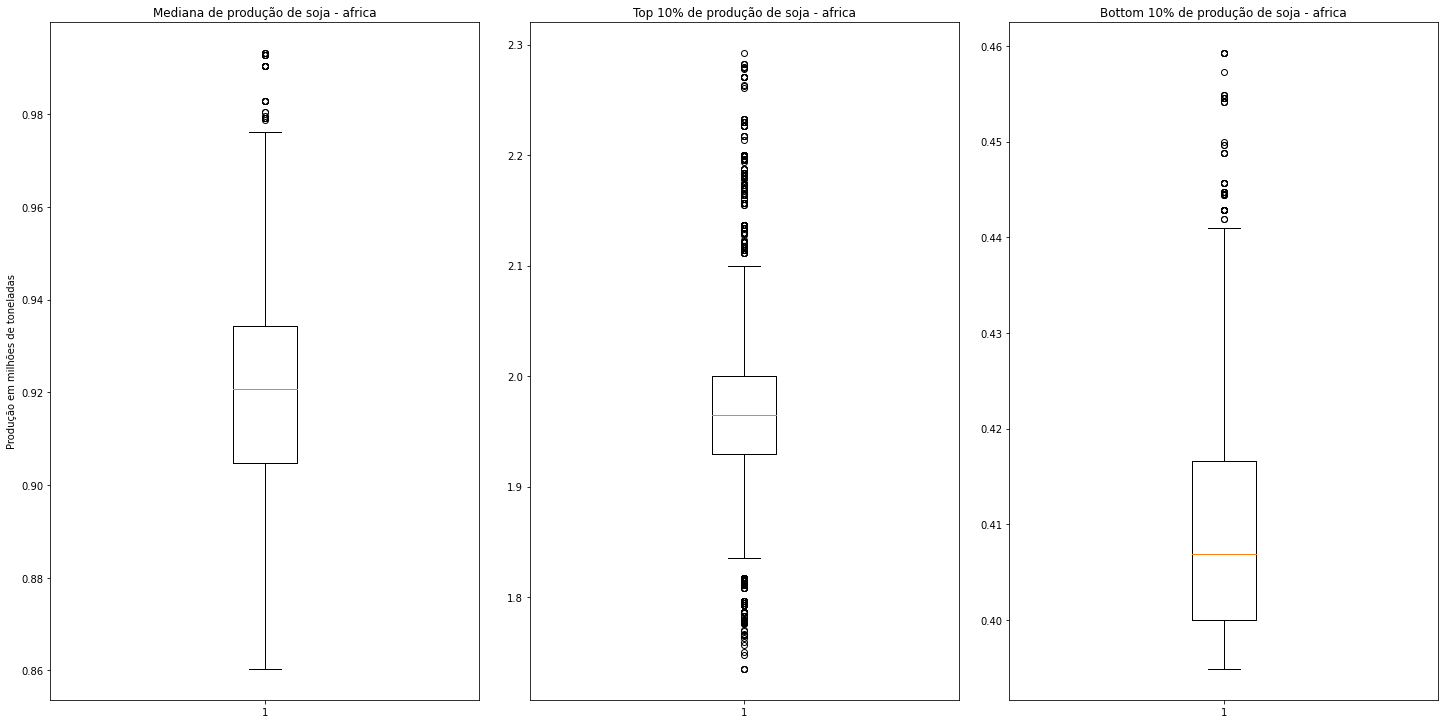

In [ ]:
# Africa
africa_produtiv = continentes_produtiv['africa']
values_a_p, li_a_p_median, ls_a_p_median = get_status_continente(africa_produtiv, 'africa', 'soja', False)
africa_prod = continentes_prod['africa'].groupby('Year').sum()
africa_area = continentes_area['africa'].groupby('Year').sum()

0.8666118920817495


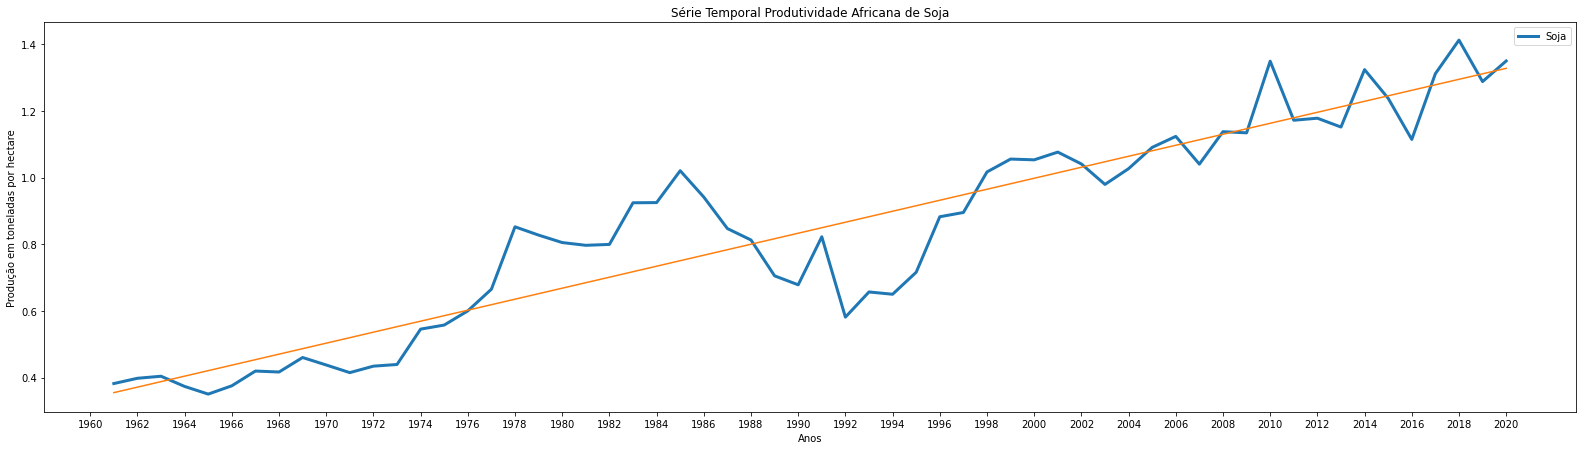

In [ ]:
africa_c_produtiv = (africa_prod / africa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(africa_c_produtiv['Year'], africa_c_produtiv['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Africana de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
soja_a_reg = LinearRegression().fit(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value'])
print(soja_a_reg.score(np.array(africa_c_produtiv['Year']).reshape(-1, 1), africa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = soja_a_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Asia

Top 10%
('Georgia', 2.6267377013980173)
('Uzbekistan', 1.9004668222740917)
('Iran (Islamic Republic of)', 1.7718494159621332)
Bottom 10%
('Tajikistan', 0.053403139926924685)


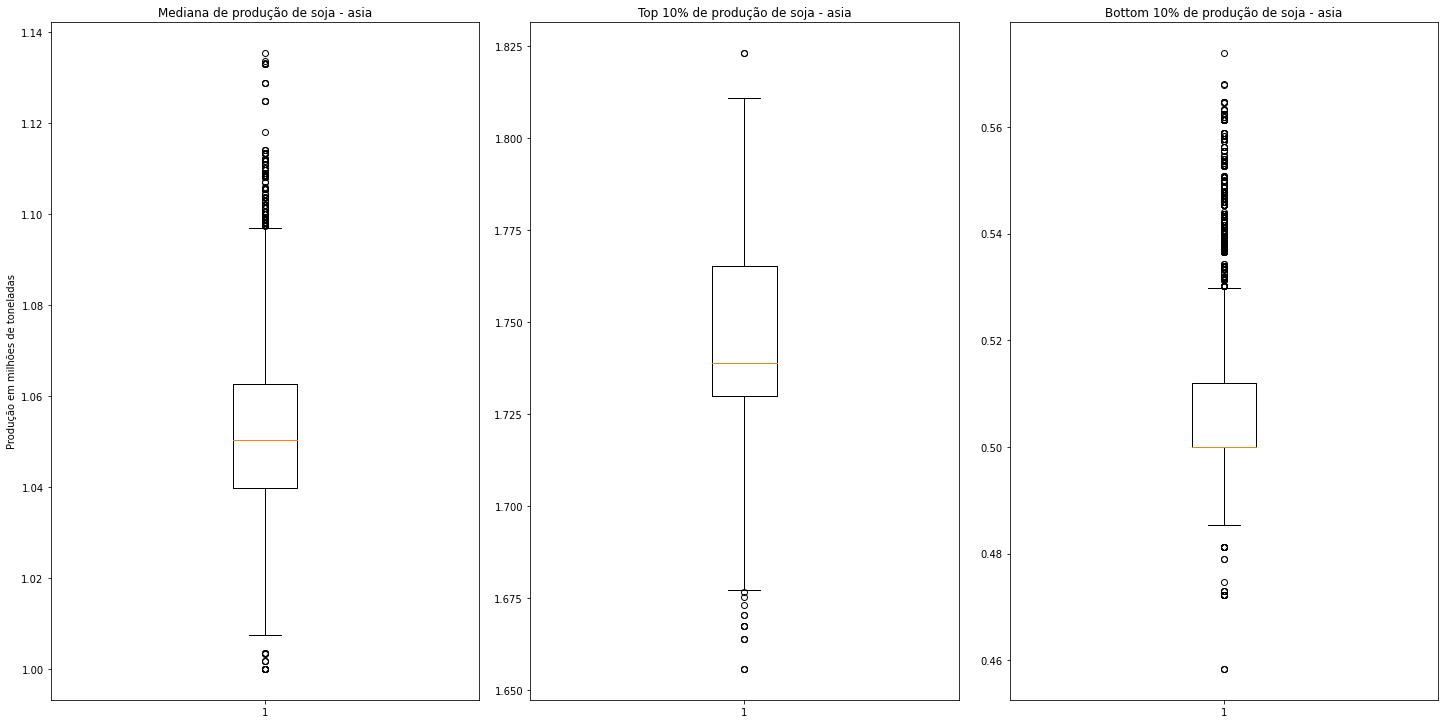

In [ ]:
# Asia
asia_produtiv = continentes_produtiv['asia']
values_asi_p, li_asi_p_median, ls_asi_p_median = get_status_continente(asia_produtiv, 'asia', 'soja', False)
asia_prod = continentes_prod['asia'].groupby('Year').sum()
asia_area = continentes_area['asia'].groupby('Year').sum()

0.776744338100137


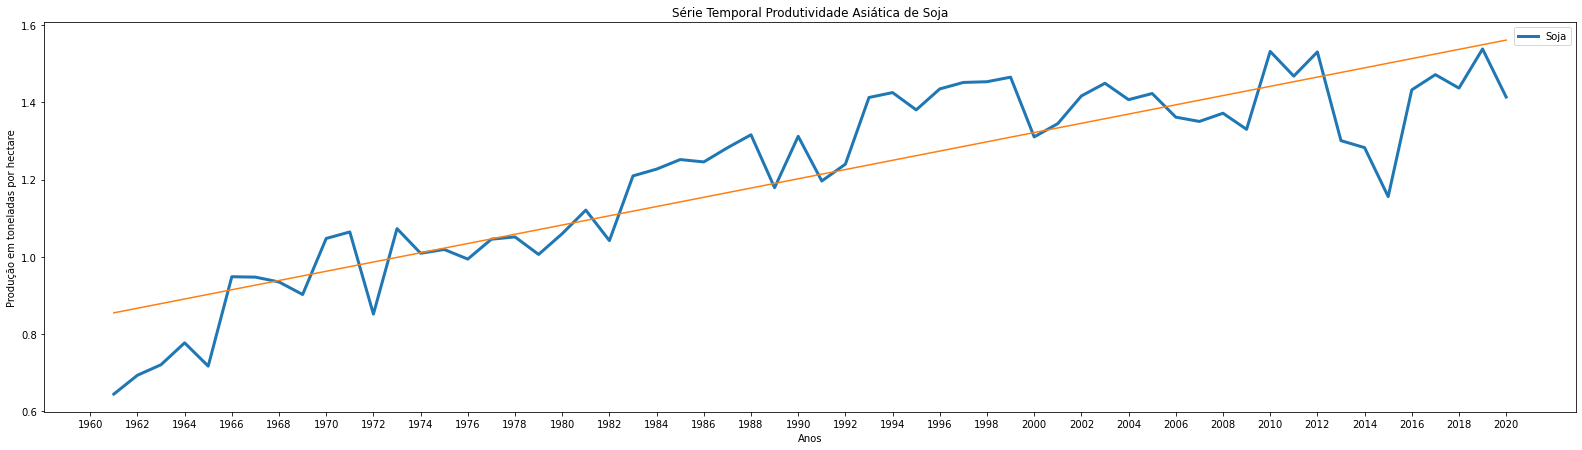

In [ ]:
asia_c_produtiv = (asia_prod / asia_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(asia_c_produtiv['Year'], asia_c_produtiv['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Asiática de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
soja_asi_reg = LinearRegression().fit(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value'])
print(soja_asi_reg.score(np.array(asia_c_produtiv['Year']).reshape(-1, 1), asia_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = soja_asi_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### America


###### Norte

Top 10%
Bottom 10%
('Panama', 0.5647154467575022)


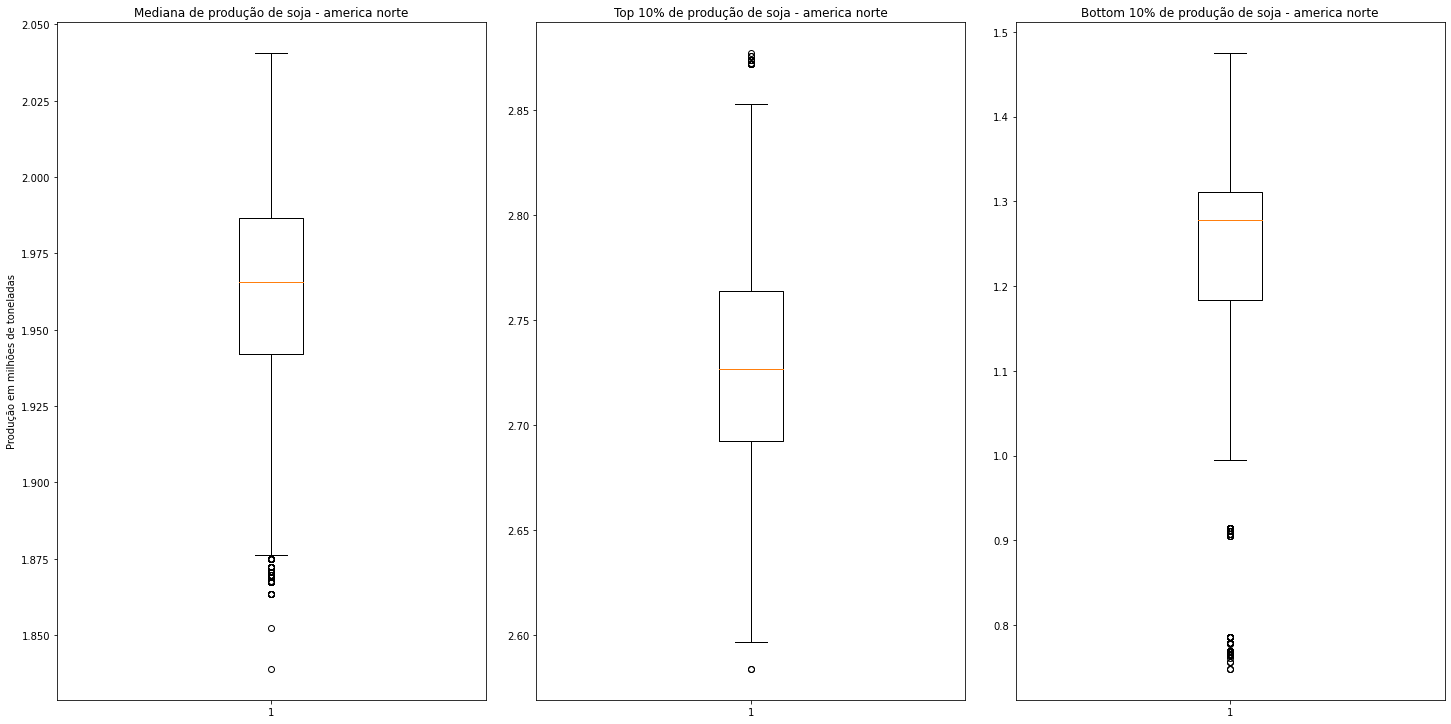

In [ ]:
# America Norte
america_n_produtiv = continentes_produtiv['america_n']
values_a_n_p, li_a_n_p_median, ls_a_n_p_median = get_status_continente(america_n_produtiv, 'america norte', 'soja', False)
america_n_prod = continentes_prod['america_n'].groupby('Year').sum()
america_n_area = continentes_area['america_n'].groupby('Year').sum()

0.9065913362170042


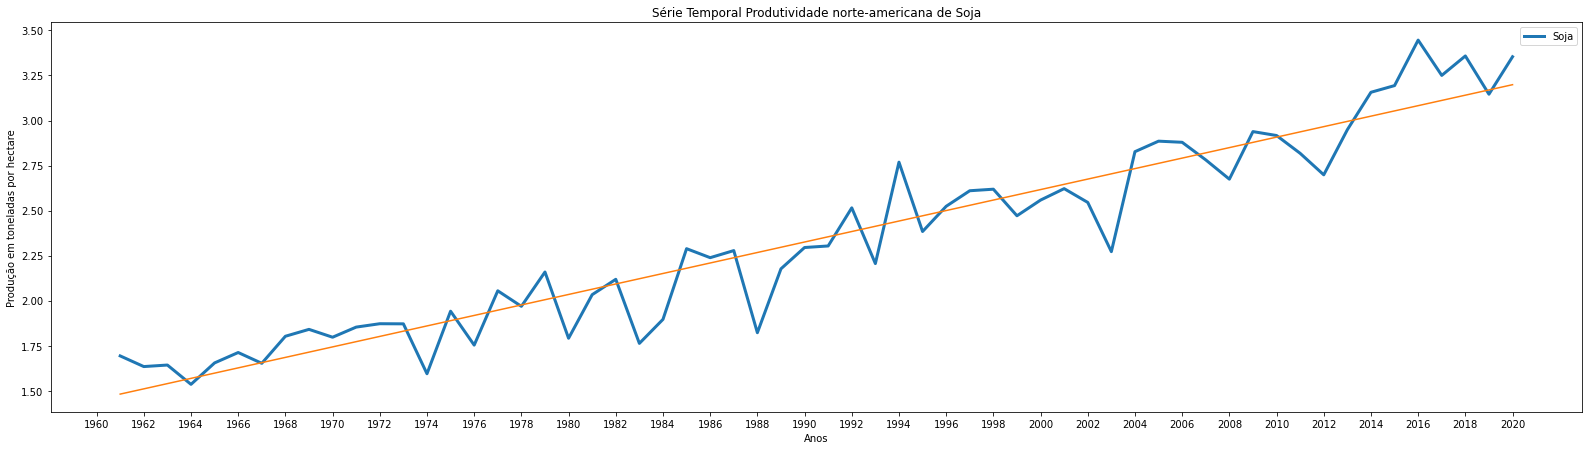

In [ ]:
america_n_c_produtiv = (america_n_prod / america_n_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_n_c_produtiv['Year'], america_n_c_produtiv['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade norte-americana de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
soja_a_n_reg = LinearRegression().fit(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value'])
print(soja_a_n_reg.score(np.array(america_n_c_produtiv['Year']).reshape(-1, 1), america_n_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_new = soja_a_n_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

###### Sul

Top 10%
Bottom 10%
('Chile', 1.0)
('Suriname', 0.9919688166697735)
('Guyana', 0.644736842105263)


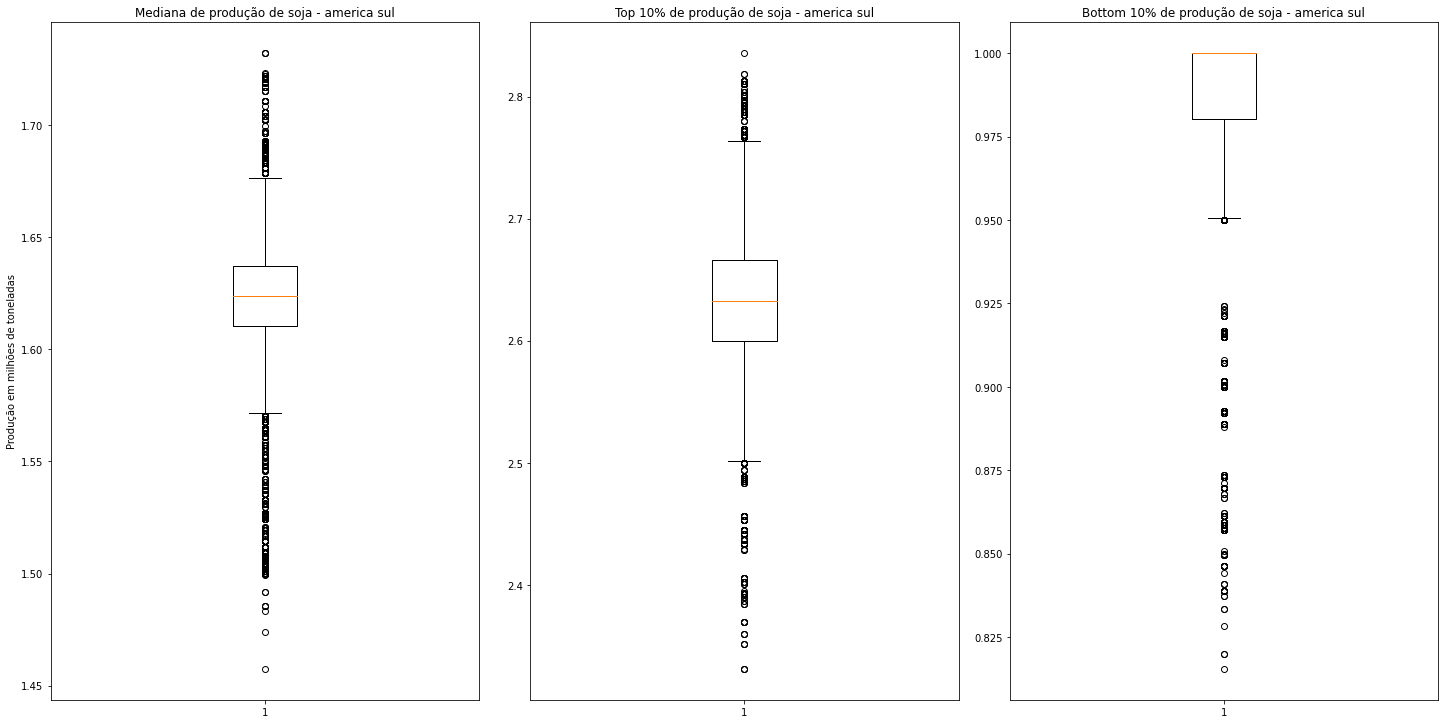

In [ ]:
# America sul
america_s_produtiv = continentes_produtiv['america_s']
values_a_s_p, li_a_s_p_median, ls_a_s_p_median = get_status_continente(america_s_produtiv, 'america sul', 'soja', False)
america_s_prod = continentes_prod['america_s'].groupby('Year').sum()
america_s_area = continentes_area['america_s'].groupby('Year').sum()

0.7866673572471576


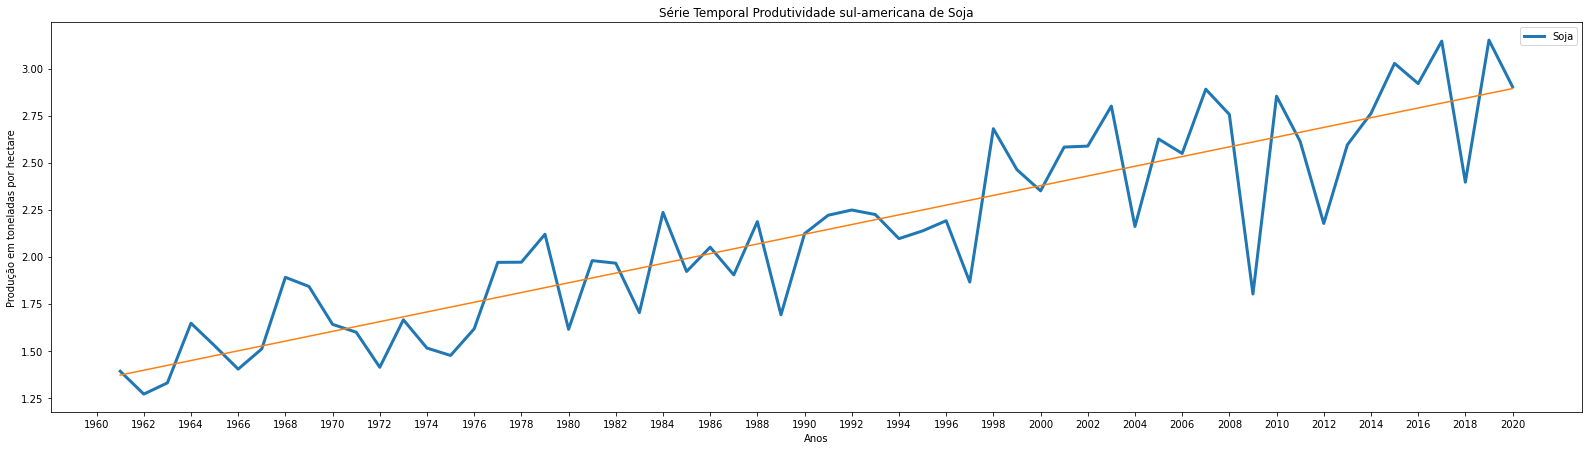

In [ ]:
america_s_c_produtiv = (america_s_prod / america_s_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(america_s_c_produtiv['Year'], america_s_c_produtiv['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade sul-americana de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
soja_a_s_reg = LinearRegression().fit(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value'])
print(soja_a_s_reg.score(np.array(america_s_c_produtiv['Year']).reshape(-1, 1), america_s_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = soja_a_s_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Europa

Top 10%
('Italy', 3.150886601619473)
('Luxembourg', 3.0)
Bottom 10%


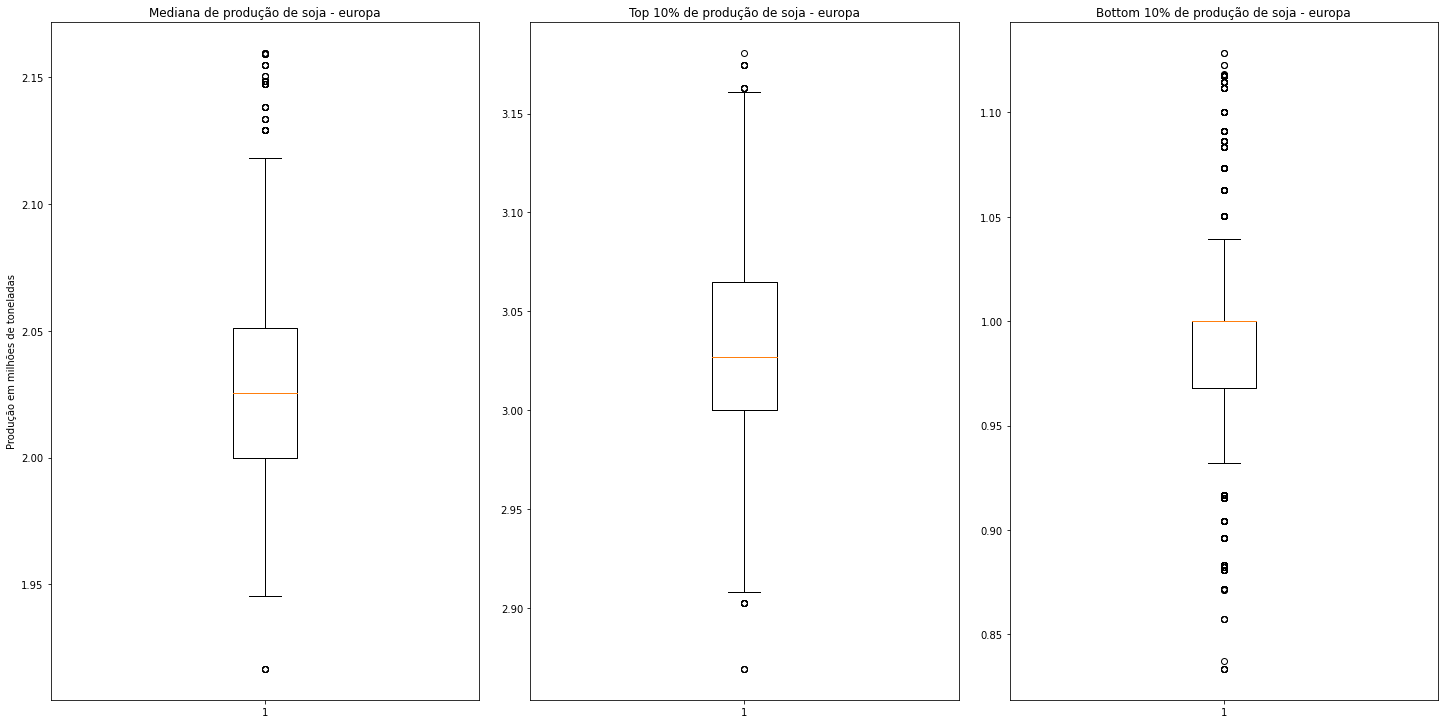

In [ ]:
# Europa
europa_produtiv = continentes_produtiv['europa']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(europa_produtiv, 'europa', 'soja', False)
europa_prod = continentes_prod['europa'].groupby('Year').sum()
europa_area = continentes_area['europa'].groupby('Year').sum()

0.6395179711142096


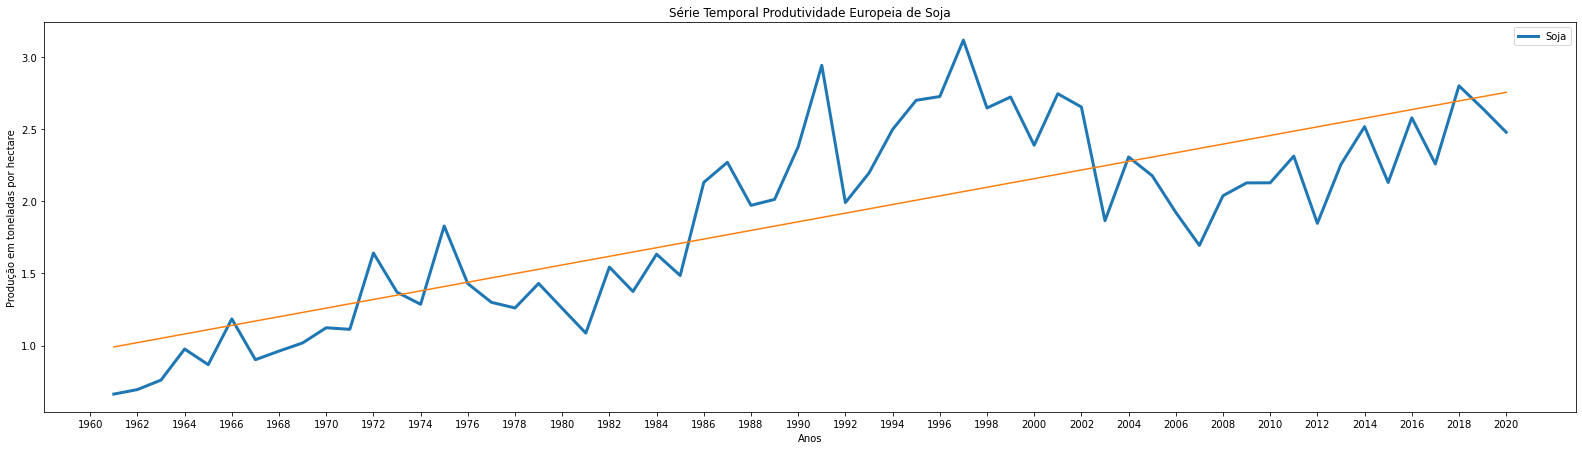

In [ ]:
europa_c_produtiv = (europa_prod / europa_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(europa_c_produtiv['Year'], europa_c_produtiv['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Europeia de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
soja_eu_reg = LinearRegression().fit(np.array(europa_c_produtiv['Year']).reshape(-1, 1), europa_c_produtiv['Value'])
print(soja_eu_reg.score(np.array(europa_c_produtiv['Year']).reshape(-1, 1), europa_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = soja_eu_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

##### Oceania

Top 10%
('New Zealand', 2.6660476915271434)
Bottom 10%


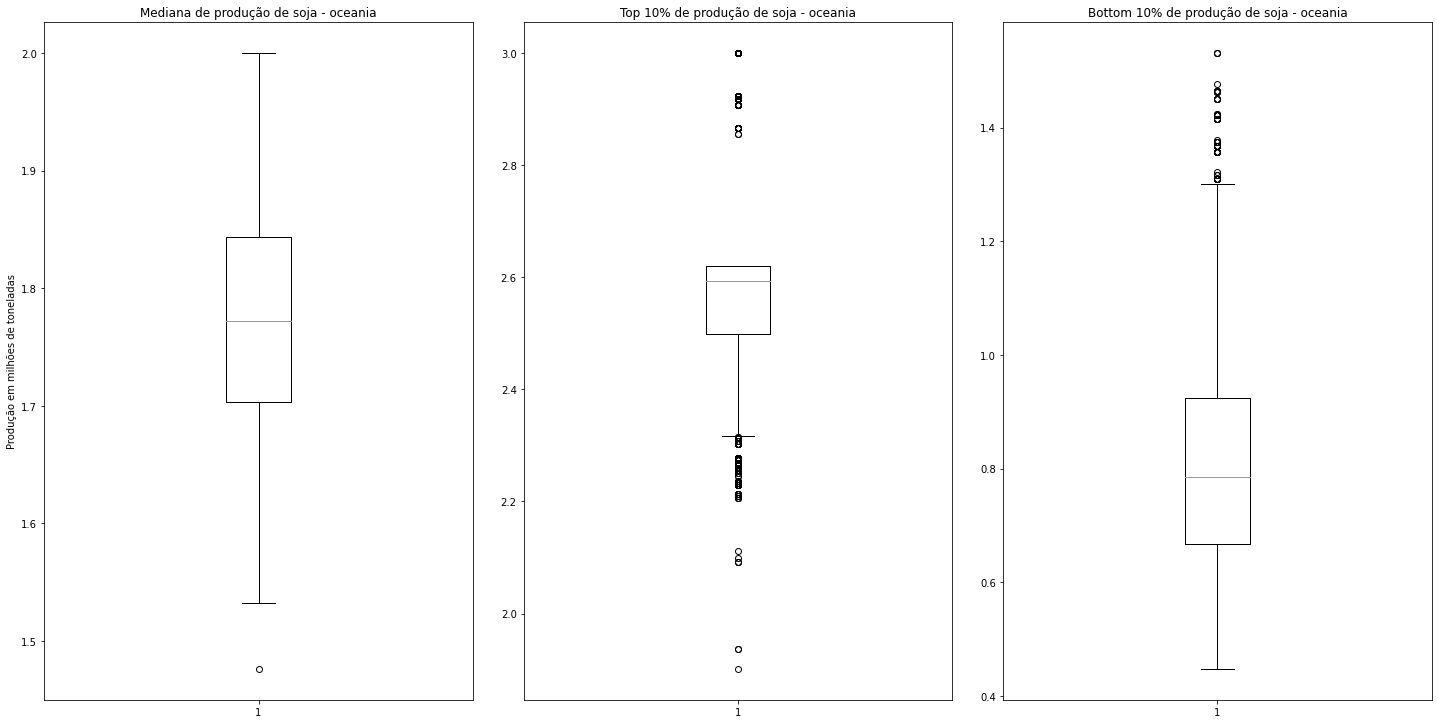

In [ ]:
# Oceania
oceania_produtiv = continentes_produtiv['oceania']
values_oc_p, li_oc_p_median, ls_oc_p_median = get_status_continente(oceania_produtiv, 'oceania', 'soja', False)
oceania_prod = continentes_prod['oceania'].groupby('Year').sum()
oceania_area = continentes_area['oceania'].groupby('Year').sum()

0.3598337148731515


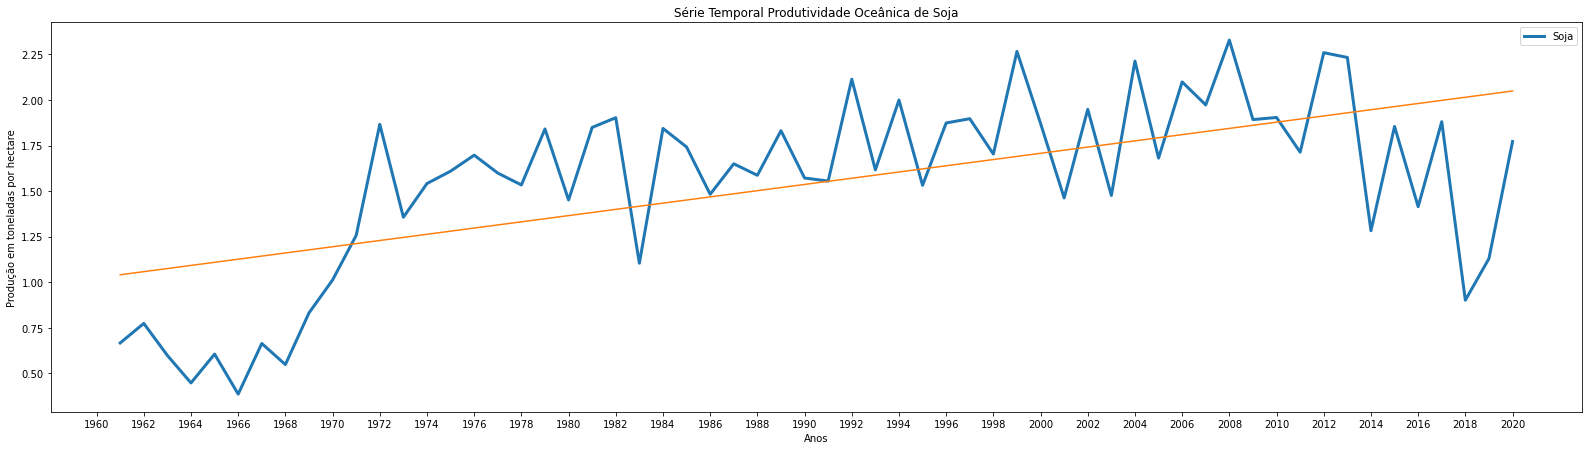

In [ ]:
oceania_c_produtiv = (oceania_prod / oceania_area).reset_index()[['Year', 'Value']]
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()
axs.plot(oceania_c_produtiv['Year'], oceania_c_produtiv['Value'], label='Soja', 
         linewidth=3)
axs.set_title('Série Temporal Produtividade Oceânica de Soja')
axs.set_xlabel('Anos')
axs.set_ylabel('Produção em toneladas por hectare')
axs.legend()
axs.set_xticks(np.arange(1960, 2022, 2))
soja_oc_reg = LinearRegression().fit(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value'])
print(soja_oc_reg.score(np.array(oceania_c_produtiv['Year']).reshape(-1, 1), oceania_c_produtiv['Value']))
x_predict = np.linspace(1961, 2020, 100)
y_predict = y_sew = soja_oc_reg.predict(x_predict[:, np.newaxis])
axs.plot(x_predict, y_predict)
plt.show()

Podemos concluir então, que para a produção de café mundial vemos uma tendência do aumento de produtividade, ou seja, mais toneladas de café sendo produzidos por hectare plantado. 

Continente   | LI (ton/ha) | LS (ton/ha)  
---|---|---
Asia |  0.57 | 0.63
Oceania   | 0.55  |   0.65
America sul | 0.48  | 0.56  |
America norte| 0.49  |  0.52 |
Africa | 0.39  |  0.42   


## Preço de venda dos produtos


In [ ]:
def inflacionar(produto,indice):
  atual=indice['CPIAUCSL'].iloc[-1]
  indice['CPIAUCSL']=indice['CPIAUCSL'].div(atual)
  indice['DATE'] = pd.to_datetime(indice['DATE'], format='%Y-%m-%d')
  indice=indice.loc[(indice['DATE'] >= '1973-08-20')]
  indice=indice.loc[(indice['DATE'] < '2022-04-3')]
  aux=0
  for i in range(len(produto)):
    while True:
      if(produto.iloc[i,0].month==indice.iloc[aux,0].month and produto.iloc[i,0].year==indice.iloc[aux,0].year):
        produto.iloc[i,1]=produto.iloc[i,1]/indice.iloc[aux,1]
        break
      else:
        aux+=1

  return produto

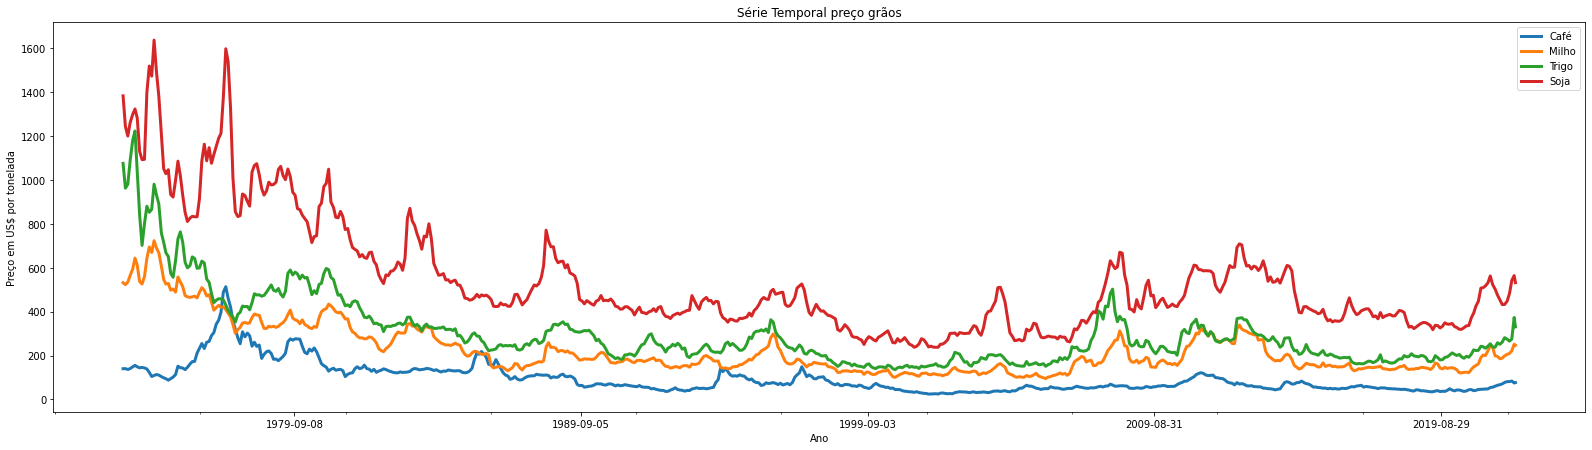

In [ ]:
auxiliar_cafe = preco_cafe.loc[(preco_cafe['date'] > '1973-08-31')]
auxiliar_soja = preco_soja.loc[(preco_soja['date'] > '1973-08-31')]
auxiliar_milho = preco_milho.loc[(preco_milho['date'] > '1973-08-31')]
auxiliar_trigo = preco_trigo.loc[(preco_trigo['date'] > '1973-08-31')]

auxiliar_cafe = auxiliar_cafe.loc[(auxiliar_cafe['date'] < '2022-04-3')]
auxiliar_soja = auxiliar_soja.loc[(auxiliar_soja['date'] < '2022-04-3')]
auxiliar_milho = auxiliar_milho.loc[(auxiliar_milho['date'] < '2022-04-3')]
auxiliar_trigo = auxiliar_trigo.loc[(auxiliar_trigo['date'] < '2022-04-3')]


auxiliar_cafe=auxiliar_cafe.groupby([auxiliar_cafe['date'].dt.year, auxiliar_cafe['date'].dt.month]).agg({'mean'})
auxiliar_soja=auxiliar_soja.groupby([auxiliar_soja['date'].dt.year, auxiliar_soja['date'].dt.month]).agg({'mean'})
auxiliar_milho=auxiliar_milho.groupby([auxiliar_milho['date'].dt.year, auxiliar_milho['date'].dt.month]).agg({'mean'})
auxiliar_trigo=preco_trigo.groupby([auxiliar_trigo['date'].dt.year, auxiliar_trigo['date'].dt.month]).agg({'mean'})

auxiliar_cafe=inflacionar(auxiliar_cafe,inflacao)
auxiliar_soja=inflacionar(auxiliar_soja,inflacao)
auxiliar_milho=inflacionar(auxiliar_milho,inflacao)
auxiliar_trigo=inflacionar(auxiliar_trigo,inflacao)
# Serie temporal variacao de preco
fig, axs = plt.subplots(figsize=(22, 6))
plt.tight_layout()


axs.plot(auxiliar_cafe['date'], auxiliar_cafe[' value'], label='Café', 
         linewidth=3)

axs.plot(auxiliar_milho['date'], auxiliar_milho[' value'], label='Milho', 
         linewidth=3)

axs.plot(auxiliar_trigo['date'], auxiliar_trigo[' value'], label='Trigo', 
         linewidth=3)

axs.plot(auxiliar_soja['date'], auxiliar_soja[' value'], label='Soja', 
         linewidth=3)



axs.set_title('Série Temporal preço grãos')
axs.set_xlabel('Ano')
axs.xaxis.set_major_locator(MultipleLocator(3650))
axs.xaxis.set_minor_locator(MultipleLocator(1850))
axs.set_ylabel('Preço em US$ por tonelada')

axs.legend()
axs.locator_params ('Data', nbins = 10) 

plt.show()


In [ ]:
preco_medio_anual_cafe=preco_cafe.groupby(preco_cafe['date'].dt.year).agg({'mean'})
preco_medio_anual_milho=preco_milho.groupby(preco_milho['date'].dt.year).agg({'mean'})
preco_medio_anual_soja=preco_soja.groupby(preco_soja['date'].dt.year).agg({'mean'})
preco_medio_anual_trigo=preco_trigo.groupby(preco_trigo['date'].dt.year).agg({'mean'})

## Comparação de produtividade

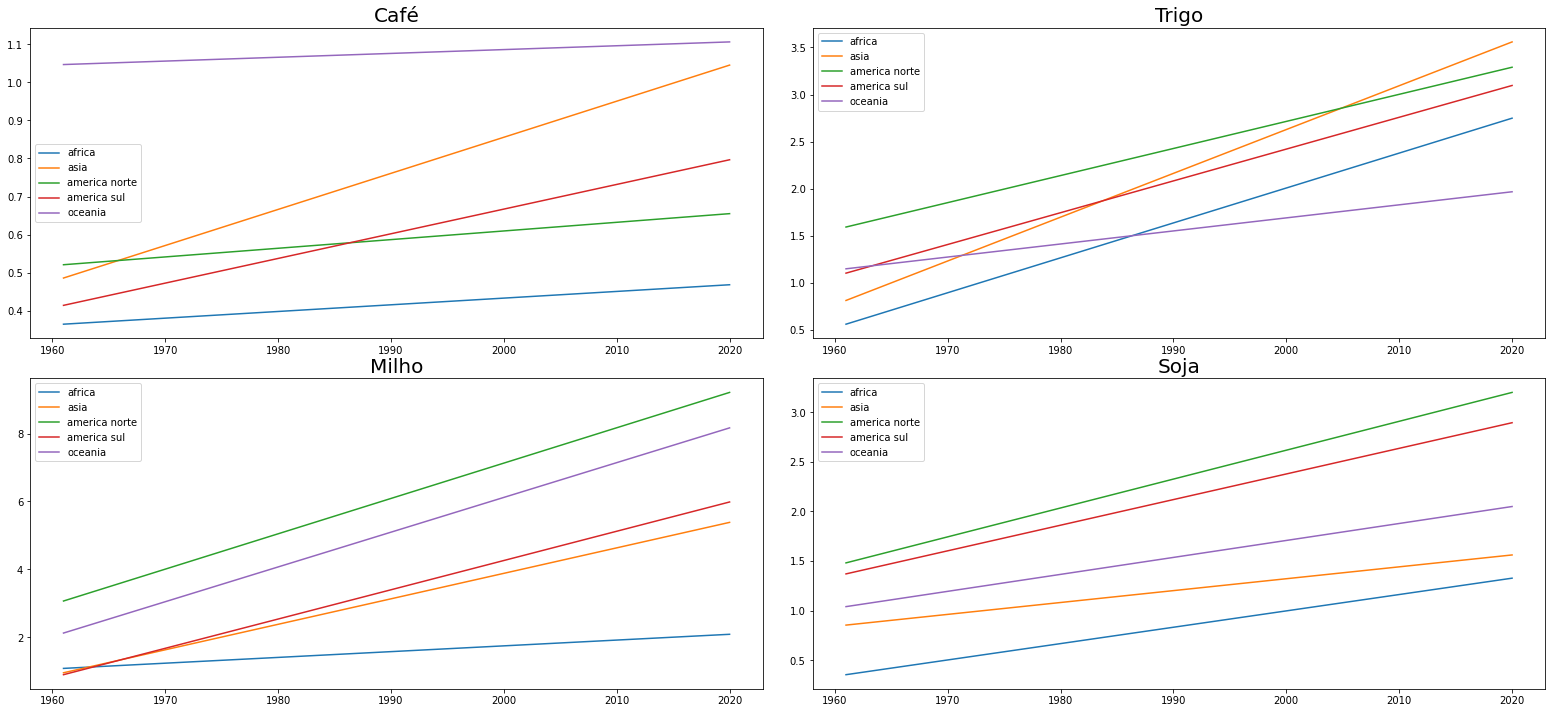

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 10))
plt.tight_layout(pad=1.9)
x_predict = np.linspace(1961, 2020, 100)
y_cafe_a = cafe_a_reg.predict(x_predict[:, np.newaxis])
y_cafe_asi = cafe_asi_reg.predict(x_predict[:, np.newaxis])
y_cafe_a_n = cafe_a_n_reg.predict(x_predict[:, np.newaxis])
y_cafe_a_s = cafe_a_s_reg.predict(x_predict[:, np.newaxis])
y_cafe_oc = cafe_oc_reg.predict(x_predict[:, np.newaxis])
axs[0][0].plot(x_predict, y_cafe_a, label="africa")
axs[0][0].plot(x_predict, y_cafe_asi, label="asia")
axs[0][0].plot(x_predict, y_cafe_a_n, label="america norte")
axs[0][0].plot(x_predict, y_cafe_a_s, label="america sul")
axs[0][0].plot(x_predict, y_cafe_oc, label="oceania")
axs[0][0].legend()
axs[0][0].set_title('Café', fontsize=20)
y_trigo_a = trigo_a_reg.predict(x_predict[:, np.newaxis])
y_trigo_asi = trigo_asi_reg.predict(x_predict[:, np.newaxis])
y_trigo_a_n = trigo_a_n_reg.predict(x_predict[:, np.newaxis])
y_trigo_a_s = trigo_a_s_reg.predict(x_predict[:, np.newaxis])
y_trigo_oc = trigo_oc_reg.predict(x_predict[:, np.newaxis])
axs[0][1].plot(x_predict, y_trigo_a, label="africa")
axs[0][1].plot(x_predict, y_trigo_asi, label="asia")
axs[0][1].plot(x_predict, y_trigo_a_n, label="america norte")
axs[0][1].plot(x_predict, y_trigo_a_s, label="america sul")
axs[0][1].plot(x_predict, y_trigo_oc, label="oceania")
axs[0][1].legend()
axs[0][1].set_title('Trigo', fontsize=20)
y_milho_a = milho_a_reg.predict(x_predict[:, np.newaxis])
y_milho_asi = milho_asi_reg.predict(x_predict[:, np.newaxis])
y_milho_a_n = milho_a_n_reg.predict(x_predict[:, np.newaxis])
y_milho_a_s = milho_a_s_reg.predict(x_predict[:, np.newaxis])
y_milho_oc = milho_oc_reg.predict(x_predict[:, np.newaxis])
axs[1][0].plot(x_predict, y_milho_a, label="africa")
axs[1][0].plot(x_predict, y_milho_asi, label="asia")
axs[1][0].plot(x_predict, y_milho_a_n, label="america norte")
axs[1][0].plot(x_predict, y_milho_a_s, label="america sul")
axs[1][0].plot(x_predict, y_milho_oc, label="oceania")
axs[1][0].legend()
axs[1][0].set_title('Milho', fontsize=20)
y_soja_a = soja_a_reg.predict(x_predict[:, np.newaxis])
y_soja_asi = soja_asi_reg.predict(x_predict[:, np.newaxis])
y_soja_a_n = soja_a_n_reg.predict(x_predict[:, np.newaxis])
y_soja_a_s = soja_a_s_reg.predict(x_predict[:, np.newaxis])
y_soja_oc = soja_oc_reg.predict(x_predict[:, np.newaxis])
axs[1][1].plot(x_predict, y_soja_a, label="africa")
axs[1][1].plot(x_predict, y_soja_asi, label="asia")
axs[1][1].plot(x_predict, y_soja_a_n, label="america norte")
axs[1][1].plot(x_predict, y_soja_a_s, label="america sul")
axs[1][1].plot(x_predict, y_soja_oc, label="oceania")
axs[1][1].legend()
axs[1][1].set_title('Soja', fontsize=20)
plt.show()